In [27]:
import os, json
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import random
import fsspec
import io

from mplsoccer import Pitch

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
BUCKET_NAME = "arthur_tmp"
BASE_GCS_PATH = f"gs://{BUCKET_NAME}"

DYNAMIC_DIR = f"{BASE_GCS_PATH}/dynamic"
META_DIR = f"{BASE_GCS_PATH}/meta"
TRACKING_DIR = f"{BASE_GCS_PATH}/tracking"
POSSESSION_DIR = f"{BASE_GCS_PATH}/possession"
PITCH_CONTROL_DIR = f"{BASE_GCS_PATH}/pitch_control"

# Pitch constants (SkillCorner → 105x68, origin at left-bottom after rescale)
X_MIN, X_MAX = -52, 52
Y_MIN, Y_MAX = -34, 34
PITCH_LENGTH, PITCH_WIDTH = 105.0, 68.0

In [18]:
fs = fsspec.filesystem("gs")

# Functions to prepare tracking data

In [4]:
# Cell 2: load helpers (meta, events, tracking) and rescale

def rescale_to_pitch_xy(x, y):
    """Map SkillCorner [-52..52, -34..34] to 105x68 meters."""
    xr = (x - X_MIN) / (X_MAX - X_MIN) * PITCH_LENGTH
    yr = (y - Y_MIN) / (Y_MAX - Y_MIN) * PITCH_WIDTH
    return xr, yr

def load_meta_mapping(match_id: int) -> pd.DataFrame:
    fpath = f"{META_DIR}/{match_id}.json"
    fs = fsspec.filesystem("gs")
    if not fs.exists(fpath):
        return pd.DataFrame()
    with fs.open(fpath, "r") as f:
        meta = json.load(f)

    home_team, away_team = meta["home_team"], meta["away_team"]
    rows = []
    for p in meta.get("players", []):
        if "id" not in p:
            continue
        team = home_team if p["team_id"] == home_team["id"] else away_team
        rows.append({
            "match_id": meta["id"],
            "player_id": p["id"],
            "team_id": p["team_id"],
            "team_name": team["name"],
            "team_short": team["short_name"],
            "player_short_name": p.get("short_name"),
            "player_role": p.get("player_role", {}).get("name"),
            "position_group": p.get("player_role", {}).get("position_group"),
            "home_team_id": home_team["id"],
            "away_team_id": away_team["id"],
        })
    return pd.DataFrame(rows)


def load_events_basic(match_id: int) -> pd.DataFrame:
    fpath = f"{DYNAMIC_DIR}/{match_id}.parquet"
    fs = fsspec.filesystem("gs")
    if not fs.exists(fpath):
        return pd.DataFrame()
    df = pd.read_parquet(fpath, storage_options={"token": "google_default"})
    keep = [
        "event_id","match_id","event_type","team_id","player_id",
        "time_start","time_end","frame_start","frame_end",
        "attacking_side","start_type","end_type","x_start","y_start","x_end","y_end",
        "period", "team_out_of_possession_phase_type"
    ]
    keep = [c for c in keep if c in df.columns]
    return df[keep].copy()


def load_tracking_full(match_id: int, sort_rows: bool = False, require_ball_detected: bool = True) -> pd.DataFrame:
    fpath = f"{TRACKING_DIR}/{match_id}.json"
    fs = fsspec.filesystem("gs")
    if not fs.exists(fpath):
        raise FileNotFoundError(f"No tracking for match {match_id}")

    with fs.open(fpath, "r") as f:
        raw = json.load(f)

    rows = []
    for d in raw:
        frame = int(d.get("frame"))
        ts = d.get("timestamp")
        period = d.get("period")

        players = d.get("player_data") or []
        for p in players:
            pid = p.get("player_id")
            rows.append({
                "match_id": match_id,
                "time": ts,
                "frame": frame,
                "period": period,
                "player_id": pid,
                "is_detected": bool(p.get("is_detected", False)),
                "is_ball": False,
                "x": p.get("x"),
                "y": p.get("y"),
            })

        ball = d.get("ball_data")
        if ball is not None:
            if (not require_ball_detected) or (ball.get("is_detected") is not None):
                rows.append({
                    "match_id": match_id,
                    "time": ts,
                    "frame": frame,
                    "period": period,
                    "player_id": -1,
                    "is_detected": bool(ball.get("is_detected", False)),
                    "is_ball": True,
                    "x": ball.get("x"),
                    "y": ball.get("y"),
                })

    df = pd.DataFrame(rows)
    if df.empty:
        return df

    df["is_ball"] = df["is_ball"].astype(bool)
    df["is_detected"] = df["is_detected"].astype(bool)
    df["frame"] = df["frame"].astype(int)

    den_x, den_y = (X_MAX - X_MIN), (Y_MAX - Y_MIN)
    valid_xy = df[["x","y"]].notna().all(axis=1)
    df["x_rescaled"] = np.where(valid_xy, (df["x"] - X_MIN) / den_x * PITCH_LENGTH, np.nan)
    df["y_rescaled"] = np.where(valid_xy, (df["y"] - Y_MIN) / den_y * PITCH_WIDTH, np.nan)

    if sort_rows:
        df = df.sort_values(["frame","is_ball","player_id"]).reset_index(drop=True)
    else:
        df = df.sort_values(["frame"]).reset_index(drop=True)

    print(f"[match {match_id}] rows: {len(df)}, players: {(~df['is_ball']).sum()}, ball: {df['is_ball'].sum()}")
    return df

In [5]:
def to_seconds(series: pd.Series) -> pd.Series:
    """
    Convert time to seconds.
    Handles strings like 'HH:MM:SS.ff' (e.g., '00:00:00.10'),
    numeric seconds, and large integers/floats in ms.
    Returns a float Series.
    """
    # if already numeric-ish, start there
    s_num = pd.to_numeric(series, errors="coerce")

    # try timedelta parsing for strings like HH:MM:SS.ff
    s_td = pd.to_timedelta(series.astype(str).str.strip().str.replace(",", ".", regex=False),
                           errors="coerce")
    s_sec_td = s_td.dt.total_seconds()

    # prefer timedelta parse when available, else numeric
    s = s_sec_td.fillna(s_num)

    # if values look like milliseconds (very large), convert to seconds
    if s.notna().any():
        median_val = s.dropna().median()
        # heuristic: median > 1e6 suggests ms ticks (e.g., 1,650,000,000)
        if median_val is not None and median_val > 1e6:
            s = s / 1000.0

    return s.astype(float)

In [6]:
def estimate_fps_from_time_df(df: pd.DataFrame, group_cols=("match_id",)) -> float:
    """
    Estimate frames-per-second from median time delta.
    Works even if you pass only ball rows or all rows.
    """
    t = to_seconds(df["time"])
    # compute dt within each group (match)
    if not isinstance(group_cols, (list, tuple)):
        group_cols = (group_cols,)
    dt = t.groupby([df[c] for c in group_cols]).diff().astype(float)
    dt = dt[(dt > 0) & dt.notna()]
    if dt.empty:
        return 25.0
    fps = 1.0 / float(dt.median())
    return float(np.clip(fps, 5, 120))

In [7]:
def compute_ball_kinematics(tr_df: pd.DataFrame,
                            interp_gap_s: float = 0.40,
                            smooth_window_s: float = 0.70,
                            clip_speed_mps: float = 40.0) -> pd.DataFrame:
    """
    Returns one row per ball frame with columns:
      match_id, frame, time_s, x_s, y_s, vx_mps, vy_mps, speed_mps, fps_used
    """
    ball = tr_df[tr_df["is_ball"]].copy()
    # parse time
    ball["time_s"] = to_seconds(ball["time"])
    # numeric positions
    ball["x_rescaled"] = pd.to_numeric(ball["x_rescaled"], errors="coerce")
    ball["y_rescaled"] = pd.to_numeric(ball["y_rescaled"], errors="coerce")
    ball["frame"] = pd.to_numeric(ball["frame"], errors="coerce")

    # sort per match/frame
    ball = ball.sort_values(["match_id", "frame"]).reset_index(drop=True)

    # fps & dt
    fps = estimate_fps_from_time_df(ball, group_cols=("match_id",))
    dt = 1.0 / fps

    # convert seconds -> frames for parameters
    max_gap_frames = max(1, int(round(interp_gap_s * fps)))
    window_frames  = max(3, int(round(smooth_window_s * fps)))
    if window_frames % 2 == 0:  # make odd for centered window
        window_frames += 1

    # interpolate short gaps only
    x = ball["x_rescaled"]
    y = ball["y_rescaled"]
    x_i = x.interpolate(limit=max_gap_frames, limit_direction="both")
    y_i = y.interpolate(limit=max_gap_frames, limit_direction="both")

    # smooth with centered rolling median
    x_s = x_i.rolling(window_frames, center=True, min_periods=max(1, window_frames//2)).median()
    y_s = y_i.rolling(window_frames, center=True, min_periods=max(1, window_frames//2)).median()


    #x_s, y_s are the smoothed/interpolated positions used to compute speed.

    # central differences for velocity
    vx = (x_s.shift(-1) - x_s.shift(1)) / (2*dt)
    vy = (y_s.shift(-1) - y_s.shift(1)) / (2*dt)

    speed = np.sqrt(vx**2 + vy**2).clip(lower=0, upper=clip_speed_mps)

    kin = pd.DataFrame({
        "match_id": ball["match_id"].values,
        "frame":    ball["frame"].astype("Int64").values,
        "time_s":   ball["time_s"].values,
        "x_s":      x_s.values,
        "y_s":      y_s.values,
        "vx_mps":   vx.values,
        "vy_mps":   vy.values,
        "speed_mps": speed.values,
        "fps_used": fps
    })
    return kin


In [8]:
def make_ball_in_play_mask(tr_df: pd.DataFrame,
                           kin: pd.DataFrame,
                           speed_threshold_mps: float = 1.0,
                           dilate_seconds: float = 1.0) -> pd.DataFrame:
    """
    Add a 'ball_in_play' column to tr_df using ball speed.
    - tr_df: full tracking DataFrame (players + ball)
    - kin: ball kinematics DataFrame (from compute_ball_kinematics)
    """
    out = tr_df.copy()
    fps = kin["fps_used"].iloc[0] if not kin.empty else 10.0
    pad_frames = int(round(dilate_seconds * fps))

    # Step 1: build raw mask from speed
    kin_mask = (kin["speed_mps"] >= speed_threshold_mps).astype(int)

    # Step 2: dilate with rolling max
    dilated = kin_mask.rolling(2*pad_frames+1, center=True, min_periods=1).max().astype(bool)

    # Step 3: assign back to frames
    mask_df = kin[["match_id", "frame"]].copy()
    mask_df["ball_in_play"] = dilated.values

    out = out.merge(mask_df, on=["match_id","frame"], how="left")
    out["ball_in_play"] = out["ball_in_play"].fillna(False)

    return out


In [9]:
def enrich_tracking_with_meta(tr_df: pd.DataFrame, match_id: int) -> pd.DataFrame:
    """
    Merge tracking with meta info (team and role for each player).
    """
    df_meta = load_meta_mapping(match_id)
    if df_meta.empty:
        return tr_df

    df = tr_df.merge(
        df_meta[[
            "match_id","player_id",
            "team_id","team_name","team_short",
            "position_group","player_role","player_short_name",
            "home_team_id","away_team_id"
        ]],
        on=["match_id","player_id"], how="left"
    )

    return df

In [10]:
def filter_bip_and_11v11(tr_df: pd.DataFrame) -> pd.DataFrame:
    """
    Keep only ball-in-play frames with 11 players per team.
    Requires `player_team_id`.
    """
    df = tr_df.copy()

    # keep only ball-in-play
    df = df[df["ball_in_play"]].copy()

    # count players per team per frame
    #players = df[~df["is_ball"] & df["is_detected"]]
    players = df[~df["is_ball"] & df[["x","y"]].notna().all(axis=1)]

    counts = players.groupby(["match_id","frame","period","team_id"]).size().reset_index(name="n_players")

    # keep only frames where all teams have at least 11 players
    valid_frames = counts.groupby(["match_id","frame"])["n_players"].min()
    valid_frames = valid_frames[valid_frames >= 11].reset_index()[["match_id","frame"]]

    # join back
    df = df.merge(valid_frames, on=["match_id","frame"], how="inner")
    return df

In [11]:
def normalize_direction(tr_df: pd.DataFrame, ev_df: pd.DataFrame) -> pd.DataFrame:
    """
    Pour un seul match :
    - S'assure que chaque équipe garde le même 'attacking_side' qu'en 1ère mi-temps.
    - Inverse les positions (x, y) de la 2e mi-temps pour que les équipes attaquent
      toujours dans la même direction (gauche -> droite pour la 1ère équipe, etc.).
    Retourne tr_df avec colonnes ajoutées : 'attacking_side' et 'x_norm','y_norm'.
    """
    df = tr_df.copy()

    # identifier les équipes du match
    teams = ev_df["team_id"].dropna().unique().astype(int)
    if len(teams) != 2:
        raise ValueError(f"Nombre d'équipes inattendu : {teams}")

    # déterminer les sides d'attaque en 1ère mi-temps (period == 1)
    sides_p1 = (
        ev_df.loc[ev_df["period"] == 1]
        .dropna(subset=["attacking_side"])
        .drop_duplicates(subset=["team_id"])
        .set_index("team_id")["attacking_side"]
        .to_dict()
    )

    # mapping de référence = orientation 1ère mi-temps
    side_map = {team_id: sides_p1.get(team_id, "left_to_right") for team_id in teams}

    # pour chaque ligne, déterminer la side de référence selon son équipe
    df["attacking_side_team"] = df["team_id"].map(side_map)

    # pour le ballon (team_id NaN), on ne peut pas mapper
    # => on le traitera simplement comme "suivant la logique de la période"
    df["attacking_side_team"] = df["attacking_side_team"].fillna("left_to_right")

    # maintenant, on inverse les positions si on est en 2e période (ou plus)
    df["x_norm"] = df["x_rescaled"].copy()
    df["y_norm"] = df["y_rescaled"].copy()

    mask_period2 = df["period"] >= 2
    df.loc[mask_period2, "x_norm"] = PITCH_LENGTH - df.loc[mask_period2, "x_rescaled"]
    df.loc[mask_period2, "y_norm"] = PITCH_WIDTH - df.loc[mask_period2, "y_rescaled"]

    # on garde la colonne attacking_side pour info
    df["attacking_side"] = df["attacking_side_team"]

    # clean
    df = df.drop(columns=["attacking_side_team"], errors="ignore")

    return df

In [12]:
def build_possession_mask(events: pd.DataFrame, tracking: pd.DataFrame) -> pd.DataFrame:
    """
    Build a possession mask from events using frame_start / frame_end.
    For each frame in tracking, mark which team is in possession.
    """
    # keep only possession-relevant events
    ev_poss = events[events["event_type"].isin(["player_possession", "passing_option"])].copy()

    if ev_poss.empty:
        print("⚠️ No possession events found!")
        tracking["in_possession_team"] = np.nan
        return tracking

    # expand into frame-level mask
    pos_mask = []
    for _, row in ev_poss.iterrows():
        for fr in range(int(row["frame_start"]), int(row["frame_end"]) + 1):
            pos_mask.append({
                "match_id": row["match_id"],
                "frame": fr,
                "in_possession_team": row["team_id"]
            })

    df_mask = pd.DataFrame(pos_mask).drop_duplicates(["match_id", "frame"])

    # merge into tracking
    tracking = tracking.merge(df_mask, on=["match_id","frame"], how="left")

    return tracking

In [13]:
def create_possession_df(tr_df: pd.DataFrame, ev_df: pd.DataFrame):
    """
    Pour le calcul du Pitch Control, on veut toujours que les équipes attaquent de gauche à droite, car on s'intéresse à la possession en phase offensive, et qu'on veut seulement calculer les probas sur la partie droite du terrain.
    Donc on créé 2 dataframes : 1 où l'équipe home attaque de gauche à droite, et 1 où l'équipe away attaque de gauche à droite, puis on les concatène.
    On en profiter pour filtrer sur les frames où l'équipe qui n'a pas la possession est en "low block" uniquement.
    """
    team_ids = tr_df["team_id"].dropna().unique()
    home_team_id = tr_df["home_team_id"].iloc[0]
    away_team_id = tr_df["away_team_id"].iloc[0]

    for team_id in team_ids:
        df_ev_pos = ev_df[(ev_df["event_type"] == "player_possession")&(ev_df["team_id"] ==team_id)]
        df_ev_pos_low_block = df_ev_pos[df_ev_pos["team_out_of_possession_phase_type"] == "low_block"]

        df_ev_pos_low_block = df_ev_pos_low_block[
            [
                "event_id", "match_id", "player_id", "frame_start", "frame_end",
            ]
        ]
        df_ev_pos_low_block = df_ev_pos_low_block.rename(columns={'player_id':'player_in_possession_id'})

        if team_id == home_team_id:
            df_home = tr_df.merge(
                df_ev_pos_low_block,
                left_on=["match_id", "frame"],
                right_on=["match_id", "frame_end"],
                how="inner"
            )
            if len(df_home[df_home["team_id"] == team_id]["attacking_side"].unique()) > 1:
                raise ValueError(f"2 sens d'attaque détectées pour la même équipe : {team_id}")
            if not df_home[df_home["team_id"] == team_id]["attacking_side"].iloc[0] == "left_to_right":
                df_home["x_norm"] = PITCH_LENGTH - df_home["x_norm"]
                df_home["y_norm"] = PITCH_WIDTH - df_home["y_norm"]
                df_home.loc[df_home["team_id"] == team_id, "attacking_side"] = "left_to_right"
                df_home.loc[df_home["team_id"] == away_team_id, "attacking_side"] = "right_to_left"
                
        else:
            df_away = tr_df.merge(
                df_ev_pos_low_block,
                left_on=["match_id", "frame"],
                right_on=["match_id", "frame_end"],
                how="inner"
            )
            if len(df_away[df_away["team_id"] == team_id]["attacking_side"].unique()) > 1:
                raise ValueError(f"2 sens d'attaque détectées pour la même équipe : {team_id}")
            if not df_away[df_away["team_id"] == team_id]["attacking_side"].iloc[0] == "left_to_right":
                df_away["x_norm"] = PITCH_LENGTH - df_away["x_norm"]
                df_away["y_norm"] = PITCH_WIDTH - df_away["y_norm"]
                df_away.loc[df_away["team_id"] == team_id, "attacking_side"] = "left_to_right"
                df_away.loc[df_away["team_id"] == home_team_id, "attacking_side"] = "right_to_left"

    possession_df = pd.concat([df_home, df_away]).reset_index(drop=True)
    
    return possession_df

In [226]:
# à améliorer : on doit pouvoir choisir la phase de jeu en input (ne doit pas être hardcodé en "low_block")
# rajouter condition pour éviter erreur : si jamais pas d'event avec équipe en "low_block"

In [20]:
def prepare_match_frames(match_id: int) -> pd.DataFrame | None:
    """
    Prépare les frames de tracking pour un match donné.
    - Charge le tracking complet.
    - Calcule la cinématique du ballon.
    - Ajoute un masque "ball_in_play".
    - Enrichit avec les méta-infos (équipe, rôle).
    - Normalise la direction d'attaque (les équipes attaquent dans la même direction tout le match)
    - Filtre pour ne garder que les frames en jeu avec 11v11.
    - Déduplique le dataframe avec : 1) les possessions de l'équipe home qui attaque de gauche à droite, 2) les possessions de l'équipe away qui attaque de gauche à droite.
    - On filtre sur les phases où l'équipe qui n'a pas la possession est en "low block" uniquement.

    Retourne le DataFrame de tracking enrichi et filtré,
    ou None si un des fichiers requis est manquant.
    """

    # Vérifie l’existence des fichiers requis sur GCS
    tracking_path = f"{TRACKING_DIR}/{match_id}.json"
    events_path = f"{DYNAMIC_DIR}/{match_id}.parquet"
    meta_path = f"{META_DIR}/{match_id}.json"

    missing_files = [
        path for path in [tracking_path, events_path, meta_path]
        if not fs.exists(path)
    ]

    if missing_files:
        print(f"⚠️  Fichiers manquants pour match_id={match_id} : {missing_files} → skip.")
        return None

    # Chargement des données
    tr = load_tracking_full(match_id, TRACKING_DIR)
    ev = load_events_basic(match_id)
    meta = load_meta_mapping(match_id)

    # Merge meta
    tr = tr.merge(
        meta[[
            "match_id", "player_id", "team_id", "team_name", "team_short",
            "player_short_name", "player_role", "position_group",
            "home_team_id", "away_team_id"
        ]],
        on=["match_id", "player_id"], how="left"
    )

    # Normalize direction
    tr = normalize_direction(tr, ev)
    # Ball in play
    kin = compute_ball_kinematics(tr)
    tr = make_ball_in_play_mask(tr, kin)
    # Filter ~11v11
    tr = filter_bip_and_11v11(tr)
    # Possession mask
    tr = build_possession_mask(ev, tr)

    df = create_possession_df(tr, ev)

    return df

In [14]:
def prepare_match_frames(match_id: int) -> pd.DataFrame:
    """
    Prépare les frames de tracking pour un match donné.
    - Charge le tracking complet.
    - Calcule la cinématique du ballon.
    - Ajoute un masque "ball_in_play".
    - Enrichit avec les méta-infos (équipe, rôle).
    - Normalise la direction d'attaque (les équipes attaquent dans la même direction tout le match)
    - Filtre pour ne garder que les frames en jeu avec 11v11.
    - Déduplique le dataframe avec : 1) les possessions de l'équipe home qui attaque de gauche à droite, 2) les possessions de l'équipe away qui attaque de gauche à droite.
    - On filtre sur les phases où l'équipe qui n'a pas la possession est en "low block" uniquement.
    Retourne le DataFrame de tracking enrichi et filtré.
    """

    tr = load_tracking_full(match_id, TRACKING_DIR)
    ev = load_events_basic(match_id)
    meta = load_meta_mapping(match_id)

    # Merge meta
    tr = tr.merge(
        meta[["match_id","player_id","team_id","team_name","team_short",
              "player_short_name","player_role","position_group",
              "home_team_id","away_team_id"]],
        on=["match_id","player_id"], how="left"
    )
    # Normalize direction
    tr = normalize_direction(tr, ev)
    # Ball in play
    kin = compute_ball_kinematics(tr)
    tr = make_ball_in_play_mask(tr, kin)
    # Filter ~11v11
    tr = filter_bip_and_11v11(tr)
    # Possession mask
    tr = build_possession_mask(ev, tr)

    df = create_possession_df(tr, ev)

    return df

# Prepare tracking data

In [208]:
df_matches = pd.read_parquet("PremierLeague_data/2024/matches.parquet")
df_matches.sample(10)

,id,home_team,away_team
300,2014830,Arsenal Football Club,Bournemouth
318,1953619,Wolverhampton Wanderers,Nottingham Forest
182,2012372,Manchester United,Wolverhampton Wanderers
33,1941551,Aston Villa,Brighton and Hove Albion
20,1729518,Fulham,Newcastle United
151,1895415,Manchester City,Nottingham Forest
262,1987415,Fulham,Manchester United
263,1729517,Leicester City,Everton
354,1895412,Arsenal Football Club,Manchester United
363,1876897,Ipswich Town,Manchester United


In [182]:
df_matches[df_matches.id == 1972418]

,id,home_team,away_team
7,1972418,Arsenal Football Club,Aston Villa


In [ ]:
#def save_parquet_to_gcs(df: pd.DataFrame, gcs_path: str):
#    """Sauvegarde un DataFrame Parquet directement sur GCS."""
#    with fsspec.open(gcs_path, "wb") as f:
#        df.to_parquet(f, index=False)

In [ ]:
fs = fsspec.filesystem("gs")
files = fs.glob(f"{TRACKING_DIR}/*.json")
match_ids = [int(Path(f).stem) for f in files if Path(f).stem.isdigit()]
print(f"🧠 {len(match_ids)} matchs trouvés sur GCS")

for match_id in match_ids:
    outpath = f"{POSSESSION_DIR}/{match_id}.parquet"
    if fs.exists(outpath):
        print(f" Fichier déjà existant pour le match {match_id}")
        continue

    print(f" Traitement du match {match_id}...")
    df_possession = prepare_match_frames(match_id)
    
    if df_possession is None:
        continue
    
    with fsspec.open(outpath, "wb") as f:
        df_possession.to_parquet(f, index=False)
    
    print(f" Fichier sauvegardé : {outpath}")

🧠 380 matchs trouvés sur GCS
 Traitement du match 1650385...
[match 1650385] rows: 939872, players: 899008, ball: 40864
 Fichier sauvegardé : gs://arthur_tmp/possession/1650385.parquet
 Traitement du match 1650961...
[match 1650961] rows: 928027, players: 887678, ball: 40349
 Fichier sauvegardé : gs://arthur_tmp/possession/1650961.parquet
 Traitement du match 1651700...
[match 1651700] rows: 951050, players: 909700, ball: 41350
 Fichier sauvegardé : gs://arthur_tmp/possession/1651700.parquet
 Traitement du match 1651701...
[match 1651701] rows: 931247, players: 890758, ball: 40489
 Fichier sauvegardé : gs://arthur_tmp/possession/1651701.parquet
 Traitement du match 1651702...
[match 1651702] rows: 1036350, players: 990658, ball: 45692
 Fichier sauvegardé : gs://arthur_tmp/possession/1651702.parquet
 Traitement du match 1651703...
[match 1651703] rows: 907532, players: 866863, ball: 40669
 Fichier sauvegardé : gs://arthur_tmp/possession/1651703.parquet
 Traitement du match 1651704...
⚠️

In [209]:
#match_ids = [1972418, 2003328, 2007481, 1832951, 1770290, 1895412, 2007736, 1972421, 2003328, 1997068, 1941551]
#for match_id in match_ids:
#    outpath = POSSESSION_DIR / f"{str(match_id)}.parquet"
#
#    if outpath.exists():
#        print(f"✅ Fichier déjà existant pour le match {match_id}")
#        continue
#
#    print(f"⏳ Traitement du match {match_id}...")
#    df_possession = prepare_match_frames(match_id)
#    df_possession.to_parquet(outpath, index=False)
#    print(f"💾 Fichier sauvegardé : {outpath}")
#    

✅ Fichier déjà existant pour le match 1972418
✅ Fichier déjà existant pour le match 2003328
✅ Fichier déjà existant pour le match 2007481
✅ Fichier déjà existant pour le match 1832951
✅ Fichier déjà existant pour le match 1770290
✅ Fichier déjà existant pour le match 1895412
✅ Fichier déjà existant pour le match 2007736
✅ Fichier déjà existant pour le match 1972421
✅ Fichier déjà existant pour le match 2003328
✅ Fichier déjà existant pour le match 1997068
⏳ Traitement du match 1941551...
[match 1941551] rows: 914365, players: 874610, ball: 39755
💾 Fichier sauvegardé : c:\Users\User\Desktop\Repositories\twelve-deep-learning\PremierLeague_data\2024\possession\1941551.parquet


In [84]:
# récupérer le player_id du striker
# retirer les frames où il est hors jeu
# prendre seulement une frame par event ?
# save des 2 dataframes

In [ ]:
# il faut retirer les frames où le joueur est hors jeu
# frames où le joeueur est en possession du ballon ?
# garder une frame par event_id (la dernière ?)

## analyze event data variables

In [71]:
# analyze event data variables

match_id = 2003328
df_ev =  pd.read_parquet(f"{DYNAMIC_DIR}/{match_id}.parquet", storage_options={"token": "google_default"})

In [72]:
df_ev.head(10)

,event_id,index,match_id,frame_start,frame_end,frame_physical_start,time_start,time_end,minute_start,second_start,duration,period,attacking_side_id,attacking_side,event_type_id,event_type,event_subtype_id,event_subtype,player_id,player_name,player_position_id,player_position,player_in_possession_id,player_in_possession_name,player_in_possession_position_id,player_in_possession_position,team_id,team_shortname,x_start,y_start,channel_id_start,channel_start,third_id_start,third_start,penalty_area_start,x_end,y_end,channel_id_end,channel_end,third_id_end,third_end,penalty_area_end,associated_player_possession_event_id,associated_player_possession_frame_start,associated_player_possession_frame_end,associated_player_possession_end_type_id,associated_player_possession_end_type,associated_off_ball_run_event_id,associated_off_ball_run_subtype_id,associated_off_ball_run_subtype,game_state_id,game_state,team_score,opponent_team_score,phase_index,player_possession_phase_index,first_player_possession_in_team_possession,last_player_possession_in_team_possession,lead_to_different_phase,issued_from_different_phase,n_player_possessions_in_phase,team_possession_loss_in_phase,team_in_possession_phase_type_id,team_in_possession_phase_type,team_out_of_possession_phase_type_id,team_out_of_possession_phase_type,current_team_in_possession_next_phase_type_id,current_team_in_possession_next_phase_type,current_team_out_of_possession_next_phase_type_id,current_team_out_of_possession_next_phase_type,current_team_in_possession_previous_phase_type_id,current_team_in_possession_previous_phase_type,current_team_out_of_possession_previous_phase_type_id,current_team_out_of_possession_previous_phase_type,game_interruption_before_id,game_interruption_before,game_interruption_after_id,game_interruption_after,lead_to_shot,lead_to_goal,distance_covered,trajectory_angle,trajectory_direction_id,trajectory_direction,in_to_out,out_to_in,speed_avg,speed_avg_band_id,speed_avg_band,separation_start,separation_end,separation_gain,last_defensive_line_x_start,last_defensive_line_x_end,delta_to_last_defensive_line_start,delta_to_last_defensive_line_end,delta_to_last_defensive_line_gain,last_defensive_line_height_start,last_defensive_line_height_end,last_defensive_line_height_gain,inside_defensive_shape_start,inside_defensive_shape_end,start_type_id,start_type,end_type_id,end_type,consecutive_on_ball_engagements,one_touch,quick_pass,carry,forward_momentum,is_header,hand_pass,initiate_give_and_go,pass_angle_received,pass_direction_received_id,pass_direction_received,pass_distance_received,pass_range_received_id,pass_range_received,pass_outcome_id,pass_outcome,targeted_passing_option_event_id,high_pass,player_targeted_id,player_targeted_name,player_targeted_position_id,player_targeted_position,player_targeted_x_pass,player_targeted_y_pass,player_targeted_channel_pass_id,player_targeted_channel_pass,player_targeted_third_pass_id,player_targeted_third_pass,player_targeted_penalty_area_pass,player_targeted_x_reception,player_targeted_y_reception,player_targeted_channel_reception_id,player_targeted_channel_reception,player_targeted_third_reception_id,player_targeted_third_reception,player_targeted_penalty_area_reception,player_targeted_distance_to_goal_start,player_targeted_distance_to_goal_end,player_targeted_angle_to_goal_start,player_targeted_angle_to_goal_end,player_targeted_average_speed,player_targeted_speed_avg_band_id,player_targeted_speed_avg_band,speed_difference,player_targeted_xpass_completion,player_targeted_difficult_pass_target,player_targeted_xthreat,player_targeted_dangerous,n_passing_options,n_off_ball_runs,n_passing_options_line_break,n_passing_options_first_line_break,n_passing_options_second_last_line_break,n_passing_options_last_line_break,n_passing_options_ahead,n_passing_options_dangerous_difficult,n_passing_options_dangerous_not_difficult,n_passing_options_not_dangerous_not_difficult,n_passing_options_not_dangerous_difficult,n_passing_options_at_start,n_passi

In [74]:
df_ev[['event_id', 'frame_start', 'frame_end', 'event_type', 'player_name', 'xthreat']]

,event_id,frame_start,frame_end,event_type,player_name,xthreat
0,8_0,27,27,player_possession,P. Foden,NaN
1,8_1,39,47,player_possession,Nico González,NaN
2,7_0,39,47,passing_option,J. Stones,0.0004
3,7_1,39,47,passing_option,A. Khusanov,0.0003
4,9_0,43,47,on_ball_engagement,A. Isak,NaN
...,...,...,...,...,...,...
5216,7_2740,57064,57072,passing_option,J. Stones,0.0008
5217,8_1021,57086,57086,player_possession,Nico González,NaN
5218,7_2741,57086,57086,passing_option,J. Stones,0.0010
5219,7_2742,57086,57086,passing_option,M. Kovačić,0.0018


In [40]:
df_ev.event_type.unique()

array(['player_possession', 'passing_option', 'on_ball_engagement',
       'off_ball_run'], dtype=object)

In [38]:
df_ev[df_ev["event_type"] == "player_possession"].player_in_possession_id.unique()

array([nan])

In [295]:
df_ev.shape

(4256, 294)

In [31]:
for i in df_ev.columns:
    print(i)

event_id
index
match_id
frame_start
frame_end
frame_physical_start
time_start
time_end
minute_start
second_start
duration
period
attacking_side_id
attacking_side
event_type_id
event_type
event_subtype_id
event_subtype
player_id
player_name
player_position_id
player_position
player_in_possession_id
player_in_possession_name
player_in_possession_position_id
player_in_possession_position
team_id
team_shortname
x_start
y_start
channel_id_start
channel_start
third_id_start
third_start
penalty_area_start
x_end
y_end
channel_id_end
channel_end
third_id_end
third_end
penalty_area_end
associated_player_possession_event_id
associated_player_possession_frame_start
associated_player_possession_frame_end
associated_player_possession_end_type_id
associated_player_possession_end_type
associated_off_ball_run_event_id
associated_off_ball_run_subtype_id
associated_off_ball_run_subtype
game_state_id
game_state
team_score
opponent_team_score
phase_index
player_possession_phase_index
first_player_possessio

In [32]:
df_ev.team_in_possession_phase_type.value_counts()

team_in_possession_phase_type
finish         1526
create         1498
chaotic         422
build_up        364
direct          156
transition      120
set_play         79
quick_break      60
disruption       31
Name: count, dtype: int64

In [61]:
df_ev.event_type.value_counts()

event_type
passing_option        2225
player_possession      825
on_ball_engagement     766
off_ball_run           440
Name: count, dtype: int64

## test cells

In [144]:
match_id = 2003328

In [145]:
tr = load_tracking_full(match_id, TRACKING_DIR)
ev = load_events_basic(match_id)
meta = load_meta_mapping(match_id)

# Merge meta
tr = tr.merge(
    meta[["match_id","player_id","team_id","team_name","team_short",
          "player_short_name","player_role","position_group",
          "home_team_id","away_team_id"]],
    on=["match_id","player_id"], how="left"
)
# Normalize direction
tr = normalize_direction(tr, ev)
# Ball in play
kin = compute_ball_kinematics(tr)
tr = make_ball_in_play_mask(tr, kin)
# Filter ~11v11
tr = filter_bip_and_11v11(tr)
# Possession mask
tr_df = build_possession_mask(ev, tr)

[match 2003328] rows: 989851, players: 946814, ball: 43037


In [117]:
tr_df.head()

,match_id,time,frame,period,player_id,is_detected,is_ball,x,y,x_rescaled,y_rescaled,team_id,team_name,team_short,player_short_name,player_role,position_group,home_team_id,away_team_id,x_norm,y_norm,attacking_side,ball_in_play,in_possession_team
0,2003328,00:00:00.00,10,1,2184,False,False,17.56,0.42,70.228846,34.42,32.0,Newcastle United,Newcastle,D. Burn,Left Center Back,Central Defender,40.0,32.0,70.228846,34.42,right_to_left,True,NaN
1,2003328,00:00:00.00,10,1,2924,False,False,-36.69,1.23,15.457212,35.23,40.0,Manchester City,Manchester City,Ederson,Goalkeeper,Other,40.0,32.0,15.457212,35.23,left_to_right,True,NaN
2,2003328,00:00:00.00,10,1,4450,False,False,-5.53,11.81,46.916827,45.81,40.0,Manchester City,Manchester City,İ. Gündoğan,Left Defensive Midfield,Midfield,40.0,32.0,46.916827,45.81,left_to_right,True,NaN
3,2003328,00:00:00.00,10,1,5192,False,False,-11.84,12.07,40.546154,46.07,40.0,Manchester City,Manchester City,J. Stones,Left Center Back,Central Defender,40.0,32.0,40.546154,46.07,left_to_right,True,NaN
4,2003328,00:00:00.00,10,1,5907,False,False,16.87,27.55,69.532212,61.55,32.0,Newcastle United,Newcastle,K. Trippier,Right Center Back,Central Defender,40.0,32.0,69.532212,61.55,right_to_left,True,NaN


In [118]:
tr_df.in_possession_team.value_counts()

in_possession_team
40.0    283544
32.0    153870
Name: count, dtype: int64

In [146]:
df_ev = load_events_basic(match_id)

In [120]:
team_ids = tr_df["team_id"].dropna().unique()
home_team_id = tr_df["home_team_id"].iloc[0]
away_team_id = tr_df["away_team_id"].iloc[0]

In [121]:
home_team_id

40.0

In [122]:
team_id = home_team_id

In [130]:
team_id

40.0

In [123]:
df_ev_pos = df_ev[(df_ev["event_type"] == "player_possession")&(df_ev["team_id"] ==team_id)]
df_ev_pos_low_block = df_ev_pos[df_ev_pos["team_out_of_possession_phase_type"] == "low_block"]
df_ev_pos_low_block = df_ev_pos_low_block[
    [
        "event_id", "match_id", "frame_start", "frame_end",
    ]
]

In [126]:
df_ev_pos_low_block.shape

(179, 4)

In [125]:
df_ev_pos_low_block.head()

,event_id,match_id,frame_start,frame_end
46,8_9,2003328,283,305
56,8_10,2003328,318,334
63,8_11,2003328,345,354
68,8_12,2003328,370,370
72,8_13,2003328,378,385


In [127]:
df_away = tr_df.merge(
                df_ev_pos_low_block,
                left_on=["match_id", "frame"],
                right_on=["match_id", "frame_end"],
                how="inner"
            )

In [128]:
df_away.head()

,match_id,time,frame,period,player_id,is_detected,is_ball,x,y,x_rescaled,y_rescaled,team_id,team_name,team_short,player_short_name,player_role,position_group,home_team_id,away_team_id,x_norm,y_norm,attacking_side,ball_in_play,in_possession_team,event_id,frame_start,frame_end
0,2003328,00:00:29.50,305,1,2184,True,False,31.11,-4.57,83.909135,29.43,32.0,Newcastle United,Newcastle,D. Burn,Left Center Back,Central Defender,40.0,32.0,83.909135,29.43,right_to_left,True,40.0,8_9,283,305
1,2003328,00:00:29.50,305,1,2924,False,False,-29.08,0.01,23.140385,34.01,40.0,Manchester City,Manchester City,Ederson,Goalkeeper,Other,40.0,32.0,23.140385,34.01,left_to_right,True,40.0,8_9,283,305
2,2003328,00:00:29.50,305,1,4450,True,False,15.70,14.00,68.350962,48.00,40.0,Manchester City,Manchester City,İ. Gündoğan,Left Defensive Midfield,Midfield,40.0,32.0,68.350962,48.00,left_to_right,True,40.0,8_9,283,305
3,2003328,00:00:29.50,305,1,5192,False,False,0.67,6.63,53.176442,40.63,40.0,Manchester City,Manchester City,J. Stones,Left Center Back,Central Defender,40.0,32.0,53.176442,40.63,left_to_right,True,40.0,8_9,283,305
4,2003328,00:00:29.50,305,1,5907,True,False,30.33,2.45,83.121635,36.45,32.0,Newcastle United,Newcastle,K. Trippier,Right Center Back,Central Defender,40.0,32.0,83.121635,36.45,right_to_left,True,40.0,8_9,283,305


In [129]:
if len(df_away[df_away["team_id"] == team_id]["attacking_side"].unique()) > 1:
    raise ValueError(f"2 sens d'attaque détectées pour la même équipe : {team_id}")

In [131]:
if not df_away[df_away["team_id"] == team_id]["attacking_side"].iloc[0] == "left_to_right":
    print('flip positions')
    df_away["x_norm"] = PITCH_LENGTH - df_away["x_norm"]
    df_away["y_norm"] = PITCH_WIDTH - df_away["y_norm"]
    df_away.loc[df_away["team_id"] == team_id, "attacking_side"] = "left_to_right"
    df_away.loc[df_away["team_id"] == home_team_id, "attacking_side"] = "right_to_left"

In [132]:
df_away[df_away["team_id"] == team_id]["attacking_side"].unique()

array(['left_to_right'], dtype=object)

In [133]:
df_away[(df_away["team_id"] != team_id)&(df_away["player_id"] != -1)]["attacking_side"].unique()

array(['right_to_left'], dtype=object)

In [147]:
possession_df = create_possession_df(tr_df, df_ev)

(80, 4)
     event_id  match_id  frame_start  frame_end
301      8_58   2003328         2616       2625
308      8_59   2003328         2657       2674
647     8_123   2003328         5695       5719
657     8_124   2003328         5727       5738
660     8_125   2003328         5741       5788
...       ...       ...          ...        ...
4829    8_948   2003328        53835      53862
4832    8_949   2003328        53874      53899
4839    8_950   2003328        53913      53913
4842    8_951   2003328        53935      53951
4965    8_975   2003328        55096      55150

[80 rows x 4 columns]
(179, 4)
     event_id  match_id  frame_start  frame_end
46        8_9   2003328          283        305
56       8_10   2003328          318        334
63       8_11   2003328          345        354
68       8_12   2003328          370        370
72       8_13   2003328          378        385
...       ...       ...          ...        ...
5119   8_1005   2003328        56423      56423


## analyse final tracking df

In [80]:
match_id = "1895412"
df = pd.read_parquet(f"{POSSESSION_DIR}/{match_id}.parquet", storage_options={"token": "google_default"})

In [81]:
df.sample(5)

,match_id,time,frame,period,player_id,is_detected,is_ball,x,y,x_rescaled,y_rescaled,team_id,team_name,team_short,player_short_name,player_role,position_group,home_team_id,away_team_id,x_norm,y_norm,attacking_side,ball_in_play,in_possession_team,event_id,player_in_possession_id,frame_start,frame_end
625,1895412,00:38:33.70,23147,1,11559,True,False,34.14,0.02,86.968269,34.02,31.0,Manchester United,Manchester U,M. de Ligt,Right Center Back,Central Defender,3.0,31.0,86.968269,34.02,right_to_left,True,3.0,8_487,12485,23139,23147
3562,1895412,00:57:47.00,35350,2,64677,True,False,38.04,3.98,90.905769,37.98,3.0,Arsenal Football Club,Arsenal,J. Kiwior,Left Center Back,Central Defender,3.0,31.0,90.905769,37.98,right_to_left,True,31.0,8_692,12112,35306,35350
75,1895412,00:12:19.50,7405,1,12112,False,False,39.50,8.81,92.379808,42.81,31.0,Manchester United,Manchester U,Diogo Dalot,Right Wing Back,Full Back,3.0,31.0,92.379808,42.81,right_to_left,True,3.0,8_176,20208,7333,7405
3983,1895412,01:24:06.10,51141,2,11557,False,False,-21.79,2.28,30.500481,36.28,31.0,Manchester United,Manchester U,A. Onana,Goalkeeper,Other,3.0,31.0,30.500481,36.28,left_to_right,True,31.0,8_888,12380,51116,51141
1403,1895412,00:55:09.90,33779,2,1498,True,False,-27.11,27.08,25.129327,61.08,31.0,Manchester United,Manchester U,Bruno Fernandes,Left Midfield,Midfield,3.0,31.0,79.870673,6.92,right_to_left,True,3.0,8_655,12485,33749,33779


In [211]:
df.shape

(4278, 28)

In [212]:
df.frame.nunique()

186

In [31]:
df.columns

Index(['match_id', 'time', 'frame', 'period', 'player_id', 'is_detected',
       'is_ball', 'x', 'y', 'x_rescaled', 'y_rescaled', 'team_id', 'team_name',
       'team_short', 'player_short_name', 'player_role', 'position_group',
       'home_team_id', 'away_team_id', 'x_norm', 'y_norm', 'attacking_side',
       'ball_in_play', 'in_possession_team', 'event_id',
       'player_in_possession_id', 'frame_start', 'frame_end'],
      dtype='object')

In [154]:
df.player_role.unique()

array(['Left Center Back', 'Goalkeeper', 'Left Defensive Midfield',
       'Right Center Back', 'Attacking Midfield', 'Right Wing Back',
       'Center Back', 'Center Forward', 'Defensive Midfield',
       'Left Midfield', 'Right Midfield', 'Left Winger', 'Left Back',
       'Right Winger', 'Right Defensive Midfield', 'Left Wing Back',
       'Right Back', None], dtype=object)

In [155]:
df.position_group.unique()

array(['Central Defender', 'Other', 'Midfield', 'Full Back',
       'Center Forward', 'Wide Attacker', None], dtype=object)

In [156]:
df.in_possession_team.value_counts()

in_possession_team
40.0    4117
32.0    1840
Name: count, dtype: int64

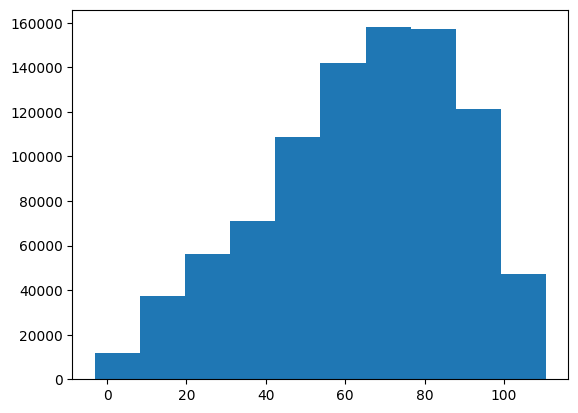

In [49]:
plt.hist(df['x_norm']);

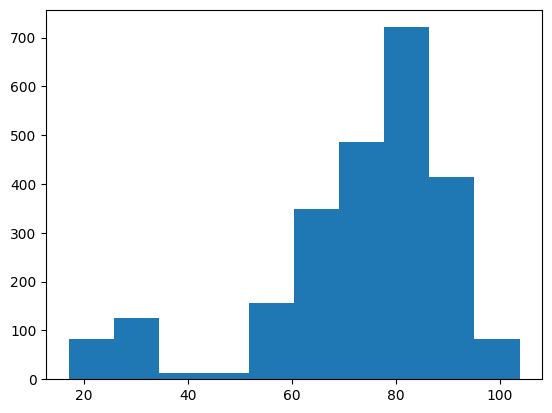

In [98]:
plt.hist(df[df['team_id'] == 3.0]['x_norm']);

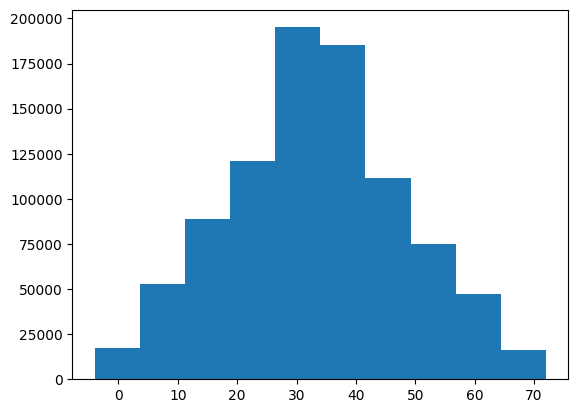

In [50]:
plt.hist(df['y_norm']);

In [86]:
df[df.frame == 35350]

,match_id,time,frame,period,player_id,is_detected,is_ball,x,y,x_rescaled,y_rescaled,team_id,team_name,team_short,player_short_name,player_role,position_group,home_team_id,away_team_id,x_norm,y_norm,attacking_side,ball_in_play,in_possession_team,event_id,player_in_possession_id,frame_start,frame_end
3542,1895412,00:57:47.00,35350,2,1498,True,False,18.51,11.07,71.187981,45.07,31.0,Manchester United,Manchester U,Bruno Fernandes,Left Midfield,Midfield,3.0,31.0,71.187981,45.07,left_to_right,True,31.0,8_692,12112,35306,35350
3543,1895412,00:57:47.00,35350,2,10324,True,False,29.38,9.09,82.162500,43.09,3.0,Arsenal Football Club,Arsenal,T. Partey,Defensive Midfield,Midfield,3.0,31.0,82.162500,43.09,right_to_left,True,31.0,8_692,12112,35306,35350
3544,1895412,00:57:47.00,35350,2,11383,False,False,-5.37,-3.57,47.078365,30.43,31.0,Manchester United,Manchester U,H. Maguire,Center Back,Central Defender,3.0,31.0,47.078365,30.43,left_to_right,True,31.0,8_692,12112,35306,35350
3545,1895412,00:57:47.00,35350,2,11557,False,False,-32.93,1.02,19.253365,35.02,31.0,Manchester United,Manchester U,A. Onana,Goalkeeper,Other,3.0,31.0,19.253365,35.02,left_to_right,True,31.0,8_692,12112,35306,35350
3546,1895412,00:57:47.00,35350,2,11559,False,False,-1.03,-12.50,51.460096,21.50,31.0,Manchester United,Manchester U,M. de Ligt,Right Center Back,Central Defender,3.0,31.0,51.460096,21.50,left_to_right,True,31.0,8_692,12112,35306,35350
3547,1895412,00:57:47.00,35350,2,11590,True,False,35.93,-4.53,88.775481,29.47,3.0,Arsenal Football Club,Arsenal,O. Zinchenko,Left Back,Full Back,3.0,31.0,88.775481,29.47,right_to_left,True,31.0,8_692,12112,35306,35350
3548,1895412,00:57:47.00,35350,2,12112,True,False,29.26,12.16,82.041346,46.16,31.0,Manchester United,Manchester U,Diogo Dalot,Right Wing Back,Full Back,3.0,31.0,82.041346,46.16,left_to_right,True,31.0,8_692,12112,35306,35350
3549,1895412,00:57:47.00,35350,2,12174,True,False,30.44,1.39,83.232692,35.39,3.0,Arsenal Football Club,Arsenal,D. Rice,Left Midfield,Midfield,3.0,31.0,83.232692,35.39,right_to_left,True,31.0,8_692,12112,35306,35350
3550,1895412,00:57:47.00,35350,2,12286,True,False,33.38,12.94,86.200962,46.94,3.0,Arsenal Football Club,Arsenal,W. Saliba,Right Center Back,Central Defender,3.0,31.0,86.200962,46.94,right_to_left,True,31.0,8_692,12112,35306,35350
3551,1895412,00:57:47.00,35350,2,12380,False,False,2.03,14.01,54.549519,48.01,31.0,Manchester United,Manchester U,N. Mazraoui,Left Center Back,Central Defender,3.0,31.0,54.549519,48.01,left_to_right,True,31.0,8_692,12112,35306,35350


In [82]:
def plot_tracking_frame(tracking_df, frame_id, pitch_length=105, pitch_width=68):
    """
    Affiche le terrain avec les positions des joueurs et du ballon pour une frame donnée.
    tracking_df : DataFrame contenant les colonnes :
        - frame
        - team_id
        - player_id
        - x_norm, y_norm (coordonnées normalisées)
    frame_id : identifiant de la frame à visualiser
    """

    # Extraire la frame
    frame_data = tracking_df[tracking_df["frame"] == frame_id]
    if frame_data.empty:
        raise ValueError(f"Aucune donnée pour la frame {frame_id}")

    # Séparer ballon / équipes
    ball_df = frame_data[frame_data["player_id"] == -1]
    players_df = frame_data[frame_data["player_id"] != -1]

    # Identifier les deux équipes
    team_ids = players_df["team_id"].dropna().unique()
    if len(team_ids) != 2:
        raise ValueError("Impossible d'identifier deux équipes distinctes.")
    team1_id, team2_id = team_ids

    team1_df = players_df[players_df["team_id"] == team1_id]
    team2_df = players_df[players_df["team_id"] == team2_id]

    # Créer le terrain (pas de figsize ici)
    pitch = Pitch(
        pitch_type='custom',
        pitch_color='white',
        line_color='black',
        pitch_length=pitch_length,
        pitch_width=pitch_width
    )

    # figsize à spécifier dans draw()
    fig, ax = pitch.draw(figsize=(10, 7))

    # Tracer les joueurs
    pitch.scatter(team1_df["x_norm"], team1_df["y_norm"],
                  s=120, c='blue', edgecolors='black', linewidth=1.2,
                  label=f"Team {team1_id}", ax=ax)
    pitch.scatter(team2_df["x_norm"], team2_df["y_norm"],
                  s=120, c='red', edgecolors='black', linewidth=1.2,
                  label=f"Team {team2_id}", ax=ax)

    # Tracer le ballon
    if not ball_df.empty:
        pitch.scatter(ball_df["x_norm"], ball_df["y_norm"],
                      s=80, c='black', marker='o', label='Ball', ax=ax, zorder=5)

    # Légende + titre
    ax.legend(loc='upper right')
    ax.set_title(f"Frame {frame_id}", fontsize=16, pad=10)

    plt.show()

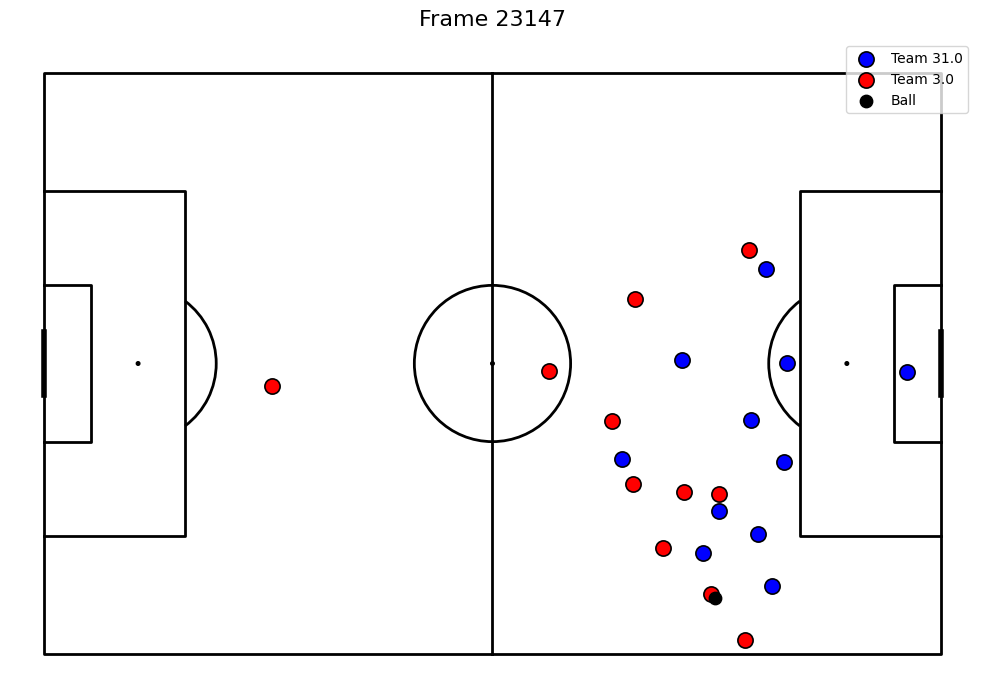

In [102]:
plot_tracking_frame(df, frame_id=23147, pitch_length=105, pitch_width=68)

# Calculate team Pitch Control

In [50]:
match_id = "1895412"
df = pd.read_parquet(f"{POSSESSION_DIR}/{match_id}.parquet", storage_options={"token": "google_default"})
df.head()

,match_id,time,frame,period,player_id,is_detected,is_ball,x,y,x_rescaled,y_rescaled,team_id,team_name,team_short,player_short_name,player_role,position_group,home_team_id,away_team_id,x_norm,y_norm,attacking_side,ball_in_play,in_possession_team,event_id,player_in_possession_id,frame_start,frame_end
0,1895412,00:06:09.40,3704,1,1498,True,False,26.66,4.76,79.416346,38.76,31.0,Manchester United,Manchester U,Bruno Fernandes,Left Midfield,Midfield,3.0,31.0,79.416346,38.76,right_to_left,True,3.0,8_88,11590,3680,3704
1,1895412,00:06:09.40,3704,1,10324,True,False,16.59,14.10,69.249519,48.10,3.0,Arsenal Football Club,Arsenal,T. Partey,Defensive Midfield,Midfield,3.0,31.0,69.249519,48.10,left_to_right,True,3.0,8_88,11590,3680,3704
2,1895412,00:06:09.40,3704,1,11383,True,False,33.62,7.47,86.443269,41.47,31.0,Manchester United,Manchester U,H. Maguire,Center Back,Central Defender,3.0,31.0,86.443269,41.47,right_to_left,True,3.0,8_88,11590,3680,3704
3,1895412,00:06:09.40,3704,1,11557,False,False,47.69,1.37,100.648558,35.37,31.0,Manchester United,Manchester U,A. Onana,Goalkeeper,Other,3.0,31.0,100.648558,35.37,right_to_left,True,3.0,8_88,11590,3680,3704
4,1895412,00:06:09.40,3704,1,11559,True,False,33.18,19.33,85.999038,53.33,31.0,Manchester United,Manchester U,M. de Ligt,Right Center Back,Central Defender,3.0,31.0,85.999038,53.33,right_to_left,True,3.0,8_88,11590,3680,3704


In [120]:
df.player_role.unique()


array(['Goalkeeper', 'Left Forward', 'Right Back', 'Attacking Midfield',
       'Right Defensive Midfield', 'Defensive Midfield',
       'Left Center Back', 'Center Forward', 'Left Midfield',
       'Right Midfield', 'Right Winger', 'Right Center Back',
       'Right Forward', 'Left Back', 'Left Winger',
       'Left Defensive Midfield', None], dtype=object)

In [173]:
df.position_group.unique()

array(['Central Defender', 'Other', 'Midfield', 'Full Back',
       'Center Forward', 'Wide Attacker', None], dtype=object)

In [69]:
df.shape

(6279, 27)

In [98]:
df.frame.nunique()

260

In [99]:
df.event_id.nunique()

260

In [87]:
df.head()

,match_id,time,frame,period,player_id,is_detected,is_ball,x,y,x_rescaled,y_rescaled,team_id,team_name,team_short,player_short_name,player_role,position_group,home_team_id,away_team_id,x_norm,y_norm,attacking_side,ball_in_play,in_possession_team,event_id,player_in_possession_id,frame_start,frame_end
0,1972418,00:01:20.20,812,1,3066,False,False,47.25,1.58,100.204327,35.58,39.0,Aston Villa,Aston Villa,E. Martínez,Goalkeeper,Other,3.0,39.0,100.204327,35.58,right_to_left,True,3.0,8_16,13908,774,812
1,1972418,00:01:20.20,812,1,6109,True,False,32.79,19.29,85.605288,53.29,3.0,Arsenal Football Club,Arsenal,L. Trossard,Left Forward,Wide Attacker,3.0,39.0,85.605288,53.29,left_to_right,True,3.0,8_16,13908,774,812
2,1972418,00:01:20.20,812,1,10324,True,False,10.19,-9.38,62.787981,24.62,3.0,Arsenal Football Club,Arsenal,T. Partey,Right Back,Full Back,3.0,39.0,62.787981,24.62,left_to_right,True,3.0,8_16,13908,774,812
3,1972418,00:01:20.20,812,1,11041,True,False,13.23,19.73,65.857212,53.73,39.0,Aston Villa,Aston Villa,Y. Tielemans,Attacking Midfield,Midfield,3.0,39.0,65.857212,53.73,right_to_left,True,3.0,8_16,13908,774,812
4,1972418,00:01:20.20,812,1,11304,True,False,24.43,19.00,77.164904,53.00,39.0,Aston Villa,Aston Villa,B. Kamara,Right Defensive Midfield,Midfield,3.0,39.0,77.164904,53.00,right_to_left,True,3.0,8_16,13908,774,812


In [186]:
df.frame.nunique()

260

In [55]:
def get_player_id_position(tracking_df, player_position: str) -> dict:
    """
    Retourne les IDs des joueurs occupant une position donnée pour chaque équipe.
    Si aucun joueur n'est trouvé pour une équipe, la valeur correspondante est None.
    """
    home_team_id = tracking_df["home_team_id"].iloc[0]
    away_team_id = tracking_df["away_team_id"].iloc[0]

    def get_player_id(team_id):
        filtered = tracking_df[
            (tracking_df["position_group"] == player_position)
            & (tracking_df["team_id"] == team_id)
        ]
        return filtered["player_id"].iloc[0] if not filtered.empty else None

    return {
        home_team_id: get_player_id(home_team_id),
        away_team_id: get_player_id(away_team_id),
    }

In [57]:
player_id_position_dict = get_player_id_position(df, "Center Forward")
player_id_position_dict

{3.0: 12485, 31.0: 33020}

In [58]:
def build_team_tracking(df, team_side='home'):
    """
    Construit un format similaire à Metrica : une ligne = un frame,
    avec les positions et vitesses de chaque joueur de l'équipe.
    """
    team_id = df[f'{team_side}_team_id'].iloc[0]
    df_team = df[df['team_id'] == team_id].copy()
    team_name = df_team['team_name'].iloc[0]
    
    # Liste des joueurs
    players = df_team['player_id'].unique()
    
    tracking = (
        df_team
        .pivot(index='frame', columns='player_id', values=['x_norm', 'y_norm'])
        .sort_index()
    )
    tracking.columns = [f"{c[0]}_{int(c[1])}" for c in tracking.columns]
    tracking = tracking.reset_index()

    # Ajoute ball data
    ball = (
        df[df['is_ball']]
        .set_index('frame')[['x_norm', 'y_norm']]
        .rename(columns={'x_norm': 'ball_x', 'y_norm': 'ball_y'})
    )
    tracking = tracking.merge(ball, on='frame', how='left')
    
    tracking['player_id_in_possession'] = df.groupby('frame')['player_in_possession_id'].first().values
    tracking['Period'] = df.groupby('frame')['period'].first().values
    tracking['Time [s]'] = df.groupby('frame')['time'].first().values
    tracking['team_name'] = team_name
    
    return tracking, players

In [59]:
tracking, players = build_team_tracking(df, team_side='home')   

In [153]:
tracking.sample(10)

,frame,x_norm_12788,x_norm_13978,x_norm_14210,x_norm_26154,x_norm_26219,x_norm_32416,x_norm_32442,x_norm_34082,x_norm_34083,x_norm_36830,x_norm_61779,y_norm_12788,y_norm_13978,y_norm_14210,y_norm_26154,y_norm_26219,y_norm_32416,y_norm_32442,y_norm_34082,y_norm_34083,y_norm_36830,y_norm_61779,ball_x,ball_y,player_id_in_possession,Period,Time [s],team_name
202,46965,78.265385,83.242788,85.696154,71.187981,81.152885,80.405769,69.077885,100.577885,83.717308,80.345192,86.130288,39.33,26.14,42.98,39.38,54.25,32.49,32.93,35.75,47.10,34.73,35.58,72.237981,38.23,4681,2,01:17:03.50,Chelsea
193,38791,91.461058,80.547115,65.100000,95.509615,92.198077,82.909615,94.732212,32.873077,96.377885,85.766827,63.928846,23.34,39.07,22.57,21.89,31.54,20.91,32.28,32.40,15.87,30.45,32.66,95.045192,21.16,26154,2,01:03:26.10,Chelsea
186,38551,86.150481,74.025000,55.437981,84.686538,89.027885,76.619712,94.681731,26.310577,71.076923,78.840865,55.791346,34.70,52.86,29.83,27.15,47.17,37.29,24.84,35.22,21.25,44.11,39.25,75.640385,52.47,13978,2,01:03:02.10,Chelsea
40,9089,77.356731,52.994712,51.480288,72.076442,81.698077,61.727885,80.224038,20.888942,75.993750,73.843269,47.078365,57.93,48.69,18.51,18.79,9.69,32.38,34.08,33.15,24.42,45.41,35.76,79.941346,23.38,34083,1,00:15:07.90,Chelsea
145,32028,55.256250,91.854808,89.835577,72.157212,69.350481,66.311538,55.225962,101.940865,88.704808,86.231250,90.390865,14.47,20.81,30.87,35.86,47.37,25.82,31.45,31.94,36.00,26.30,22.36,89.209615,19.86,12104,2,00:52:09.80,Chelsea
152,32175,78.578365,83.515385,83.000481,74.277404,83.707212,76.266346,64.100481,99.265385,82.859135,75.943269,83.475000,3.66,8.75,30.89,31.97,44.22,14.24,16.53,32.18,35.41,21.60,17.45,78.396635,1.71,12104,2,00:52:24.50,Chelsea
63,16661,70.501442,63.837981,49.794231,73.843269,73.833173,68.946635,83.909135,21.908654,62.091346,65.261538,48.724038,65.18,66.73,35.63,27.15,8.04,46.94,60.45,38.31,34.55,56.83,54.15,62.969712,65.71,13978,1,00:27:45.10,Chelsea
76,22028,83.798077,74.974038,57.174519,84.898558,88.058654,87.937500,84.454327,22.665865,65.190865,77.730288,58.729327,59.95,55.64,38.39,35.53,27.77,55.87,52.72,36.11,27.59,39.47,47.48,84.565385,53.90,32442,1,00:36:41.80,Chelsea
87,22490,79.416346,58.335577,54.882692,79.678846,74.408654,70.592308,81.526442,23.453365,67.553365,68.310577,52.671635,59.88,42.98,16.67,13.82,2.30,44.58,32.14,31.84,16.99,30.95,28.02,76.357212,3.53,26219,1,00:37:28.00,Chelsea
128,27626,95.691346,71.299038,63.625962,87.745673,92.904808,80.072596,101.829808,23.685577,101.829808,89.966827,56.205288,44.90,44.46,19.60,21.89,24.96,28.48,25.91,32.69,11.78,36.81,28.93,92.490865,25.79,26219,1,00:46:01.60,Chelsea


In [38]:
players

array([  6109,  10324,  12174,  12485,  12841,  13908,  14379,  18544,
        23130,  24466, 669442,   8846], dtype=int64)

In [61]:
def calculate_player_velocities(tracking, players, frame_rate=4):
    """
    Calcule vx, vy pour chaque joueur (en m/s)
    """
    for pid in players:
        for axis in ['x', 'y']:
            col = f"{axis}_norm_{pid}"
            vcol = f"v{axis}_{pid}"
            tracking[vcol] = tracking[col].diff() * frame_rate
    return tracking

In [103]:
tr_sp = calculate_player_velocities(tracking, players)

In [67]:
tr_sp

,frame,x_norm_6109,x_norm_8846,x_norm_10324,x_norm_12174,x_norm_12485,x_norm_12841,x_norm_13908,x_norm_14379,x_norm_18544,x_norm_23130,x_norm_24466,x_norm_669442,y_norm_6109,y_norm_8846,y_norm_10324,y_norm_12174,y_norm_12485,y_norm_12841,y_norm_13908,y_norm_14379,y_norm_18544,y_norm_23130,y_norm_24466,y_norm_669442,ball_x,ball_y,Period,Time [s],vx_6109,vy_6109,vx_10324,vy_10324,vx_12174,vy_12174,vx_12485,vy_12485,vx_12841,vy_12841,vx_13908,vy_13908,vx_14379,vy_14379,vx_18544,vy_18544,vx_23130,vy_23130,vx_24466,vy_24466,vx_669442,vy_669442,vx_8846,vy_8846
0,10,47.381250,NaN,35.417308,41.929327,52.378846,34.872115,41.787981,48.895673,13.599519,50.753365,38.234135,36.447115,49.15,NaN,17.65,25.44,43.88,33.79,36.38,24.44,33.54,16.34,25.94,44.68,52.823077,33.35,1,00:00:00.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11,47.239904,NaN,35.397115,41.888942,52.459615,34.791346,41.757692,48.895673,13.326923,50.733173,37.991827,36.366346,49.11,NaN,17.63,25.39,43.86,33.76,36.42,24.44,33.53,16.35,25.91,44.67,52.722115,33.07,1,00:00:00.10,-0.565385,-0.16,-0.080769,-0.08,-0.161538,-0.20,0.323077,-0.08,-0.323077,-0.12,-0.121154,0.16,0.000000,0.00,-1.090385,-0.04,-0.080769,0.04,-0.969231,-0.12,-0.323077,-0.04,NaN,NaN
2,12,47.108654,NaN,35.387019,41.858654,52.560577,34.720673,41.737500,48.915865,13.074519,50.712981,37.769712,36.285577,49.08,NaN,17.61,25.35,43.82,33.74,36.46,24.46,33.52,16.36,25.88,44.66,52.712019,33.26,1,00:00:00.20,-0.525000,-0.12,-0.040385,-0.08,-0.121154,-0.16,0.403846,-0.16,-0.282692,-0.08,-0.080769,0.16,0.080769,0.08,-1.009615,-0.04,-0.080769,0.04,-0.888462,-0.12,-0.323077,-0.04,NaN,NaN
3,13,46.997596,NaN,35.387019,41.838462,52.681731,34.670192,41.717308,48.936058,12.852404,50.682692,37.577885,36.204808,49.05,NaN,17.60,25.32,43.77,33.72,36.51,24.49,33.51,16.37,25.86,44.65,52.742308,33.42,1,00:00:00.30,-0.444231,-0.12,0.000000,-0.04,-0.080769,-0.12,0.484615,-0.20,-0.201923,-0.08,-0.080769,0.20,0.080769,0.12,-0.888462,-0.04,-0.121154,0.04,-0.767308,-0.08,-0.323077,-0.04,NaN,NaN
4,14,46.896635,NaN,35.387019,41.828365,52.833173,34.619712,41.697115,48.976442,12.650481,50.642308,37.396154,36.144231,49.03,NaN,17.59,25.30,43.70,33.70,36.55,24.54,33.51,16.39,25.84,44.64,53.146154,33.46,1,00:00:00.40,-0.403846,-0.08,0.000000,-0.04,-0.040385,-0.08,0.605769,-0.28,-0.201923,-0.08,-0.080769,0.16,0.161538,0.20,-0.807692,0.00,-0.161538,0.08,-0.726923,-0.08,-0.242308,-0.04,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39584,60154,90.289904,87.109615,104.888942,95.681250,97.962981,100.194231,97.326923,89.027885,35.134615,NaN,103.475481,77.821154,41.24,28.19,34.83,28.14,29.41,30.69,25.98,10.82,32.83,NaN,33.04,35.11,104.131731,35.89,2,01:37:35.40,0.161538,0.68,-0.525000,-0.24,-0.686538,0.32,0.282692,-0.16,-0.484615,0.44,-0.605769,0.00,0.080769,1.24,0.121154,0.08,NaN,NaN,-0.646154,0.16,-0.282692,0.56,-0.080769,0.16
39585,60155,90.330288,87.089423,104.727404,95.489423,98.033654,100.062981,97.155288,89.078365,35.185096,NaN,103.293750,77.760577,41.40,28.22,34.75,28.25,29.36,30.82,25.97,11.14,32.85,NaN,33.06,35.25,104.525481,35.66,2,01:37:35.50,0.161538,0.64,-0.646154,-0.32,-0.767308,0.44,0.282692,-0.20,-0.525000,0.52,-0.686538,-0.04,0.201923,1.28,0.201923,0.08,NaN,NaN,-0.726923,0.08,-0.242308,0.56,-0.080769,0.12
39586,60156,90.370673,87.059135,104.525481,95.287500,98.094231,99.911538,96.983654,89.159135,35.255769,NaN,103.091827,77.710096,41.55,28.23,34.66,28.38,29.28,30.97,25.95,11.46,32.86,NaN,33.06,35.40,104.828365,35.71,2,01:37:35.60,0.161538,0.60,-0.807692,-0.36,-0.807692,0.52,0.242308,-0.32,-0.605769,0.60,-0.686538,-0.08,0.323077,1.28,0.282692,0.04,NaN,NaN,-0.807692,0.00,-0.201923,0.60,-0.121154,0.04
39587,60157,90.411058,87.028846,104.283173,95.075481,98.164904,99.760096,96.801923,89.250000,35.346635,NaN,102.8596

In [62]:
def time_to_intercept(player, target, params):
    """
    Calcule le temps minimal pour que `player` atteigne `target`, en tenant compte de :
    - projection de la vitesse sur la direction cible (direction),
    - accélération maximale (a_max),
    - vitesse maximale (v_max),
    - temps de réaction (reaction_time).
    player: dict avec keys 'x','y','vx','vy'
    target: tuple (tx, ty)
    params: dict contenant 'v_max', 'a_max', 'reaction_time'
    Retour: t_intercept (en secondes)
    """
    v_max = params['v_max']
    a_max = params['a_max']
    reaction_time = params['reaction_time']

    px, py = float(player['x']), float(player['y'])
    vx, vy = float(player.get('vx', 0.0)), float(player.get('vy', 0.0))
    tx, ty = float(target[0]), float(target[1])

    dx = tx - px
    dy = ty - py
    d = np.hypot(dx, dy)
    if d < 1e-6:
        return reaction_time  # déjà quasiment dessus

    # direction unitaire vers la cible
    ux, uy = dx / d, dy / d

    # projection de la vitesse sur la direction cible
    v_proj = vx * ux + vy * uy
    v_proj = max(0.0, v_proj)  # si va dans l'autre sens => 0 contribution immédiate

    # on suppose que dès la réaction, le joueur applique une accélération a_max dans la direction cible
    # avec vitesse initiale v_proj (projection). il ne peut dépasser v_max.
    # on calcule le temps nécessaire pour parcourir la distance d, après le temps de reaction_time.

    # CAS 1: si la vitesse initiale est déjà >= v_max (rare), on parcourt d à vitesse v_proj (coupée à v_max)
    v0 = min(v_proj, v_max)

    # Si acceleration nulle (a_max == 0) fallback
    if a_max <= 1e-6:
        motion_time = d / max(1e-6, v0 if v0 > 1e-6 else v_max)
        return reaction_time + motion_time

    # Temps pour accélérer de v0 à v_max
    if v0 < v_max:
        t_acc = (v_max - v0) / a_max
        # distance parcourue pendant accélération
        dist_acc = v0 * t_acc + 0.5 * a_max * t_acc**2
    else:
        t_acc = 0.0
        dist_acc = 0.0

    # Si la distance pour atteindre la cible est inférieure à dist_acc,
    # le joueur n'atteint pas v_max avant d'arriver. Résolution de la quadratique :
    # 0.5 * a * t^2 + v0 * t - d = 0  (t >= 0)
    if dist_acc >= d and a_max > 0:
        # solve 0.5 a t^2 + v0 t - d = 0
        A = 0.5 * a_max
        B = v0
        C = -d
        disc = B*B - 4*A*C
        if disc < 0:
            disc = 0.0
        t_motion = (-B + np.sqrt(disc)) / (2*A)
        motion_time = t_motion
    else:
        # il atteint v_max (peut etre), et parcours le reste avec v_max
        dist_rem = max(0.0, d - dist_acc)
        if v_max <= 1e-6:
            # degenerate fallback
            motion_time = t_acc + dist_rem / (v0 + 1e-6)
        else:
            motion_time = t_acc + dist_rem / v_max

    return reaction_time + motion_time

In [63]:
def calculate_pitch_control_at_target_full(target_pos, attacking_players, defending_players, params):
    """
    Version complète inspirée de 'Physics of Possession'.
    - compute t_i for chaque joueur (avec direction + accel + v_max + reaction)
    - discrétise le temps t = 0..time_max par pas dt
    - à chaque pas t, calcule des poids w_i(t) = exp(-lambda*(t - t_i)) pour t >= t_i (0 sinon)
    - normalise les poids entre tous les joueurs encore 'disponibles' pour l'instant t
    - distribue la probabilité d'interception à ce pas à chaque joueur proportionnellement
    - accumule la probabilité par équipe
    Retourne {'P_att':..., 'P_def':...}
    """
    # paramètres
    lambda_param = params.get('lambda_param', 3.0)   # vitesse de décroissance des poids temporels
    time_max = params.get('time_max', 6.0)           # horizon (s)
    dt = params.get('dt', 0.02)                      # pas d'intégration (s)
    goalkeeper_ids = params.get('goalkeeper_ids', set())  # si on veut traiter gardien différemment (option)

    # filtrer joueurs valides
    att_valid = [p for p in attacking_players if (p is not None and not np.isnan(p['x']) and not np.isnan(p['y']))]
    def_valid = [p for p in defending_players if (p is not None and not np.isnan(p['x']) and not np.isnan(p['y']))]

    # cas limites
    if len(att_valid) == 0 and len(def_valid) == 0:
        return {'P_att': 0.5, 'P_def': 0.5}
    if len(att_valid) == 0:
        return {'P_att': 0.0, 'P_def': 1.0}
    if len(def_valid) == 0:
        return {'P_att': 1.0, 'P_def': 0.0}

    # calcul des temps d'arrivée moyens (ti) pour chaque joueur
    all_players = []
    for p in att_valid:
        ti = time_to_intercept(p, target_pos, params)
        all_players.append({'team': 'att', 'player': p, 't_mean': ti})
    for p in def_valid:
        ti = time_to_intercept(p, target_pos, params)
        all_players.append({'team': 'def', 'player': p, 't_mean': ti})

    # tri optionnel (non nécessaire), on fera l'intégration
    # discrétisation temporelle
    t_arr = np.arange(0.0, time_max + dt/2, dt)

    # probabilités accumulées par joueur et par équipe
    prob_player = np.zeros(len(all_players))  # prob mass accumulée par joueur
    prob_team_att = 0.0
    prob_team_def = 0.0

    # on suit la probabilité totale déjà capturée (pour arrêter si proche de 1)
    captured_total = 0.0

    # pour chaque pas de temps on calcule les poids et on distribue la petite masse de probabilité
    
    # intuition : plus le joueur arrive tôt (ti), mieux c'est, car on sommera potentiellement plus de poids (selon le pas dt choisi) sur des t >= ti
    # intuition : mais plus on calcule les poids sur des t qui s'éloigne de ti, moins le poids est grand (exponentielle décroissante), donc pour des t > aux ti de plusieurs joueurs, l'avantage d'arriver en premier diminue.
    for k, t in enumerate(t_arr):
        # poids pour chaque joueur à ce temps (0 si t < t_mean)
        weights = np.array([np.exp(-lambda_param * max(0.0, (t - pl['t_mean']))) if t >= pl['t_mean'] else 0.0 for pl in all_players])

        sumw = np.sum(weights)
        if sumw <= 0:
            continue  # rien à distribuer à ce pas

        # la 'masse' de probabilité disponible à ce pas : la portion qui n'a pas encore été capturée
        mass = (1.0 - captured_total)
        # on peut pondérer mass par dt (pour faire une intégration), en effet on veut approx integral
        # méthode simple : attribuer mass * (dt / time_max) ou mieux : suppose que distribution se normalise
        # Ici on distribue mass * (dt / (remaining_time_estimate)) - méthode pratique :
        # mais plus simple et stable : on suppose qu'on distribue mass * (lambda_norm * dt)
        # où lambda_norm est relative à la somme des exponentielles (on s'assure que intégré sur t donne 1).
        # pour stabilité on défini une petite fraction par pas :
        small_mass = mass * (1 - np.exp(-lambda_param * dt))  # heuristique -> approx mass * lambda*dt for small dt

        # distribuer small_mass proportionnellement aux weights
        probs_at_t = small_mass * (weights / sumw)

        # ajouter à prob_player & aux équipes
        prob_player += probs_at_t
        # mettre à jour captured_total
        captured_total = np.sum(prob_player)
        if captured_total >= 0.9999:
            break

    # somme par équipe
    for idx, pl in enumerate(all_players):
        if pl['team'] == 'att':
            prob_team_att += prob_player[idx]
        else:
            prob_team_def += prob_player[idx]

    # normalisation (sécurité numérique)
    total = prob_team_att + prob_team_def
    if total <= 0:
        return {'P_att': 0.5, 'P_def': 0.5}
    P_att = prob_team_att / total
    P_def = prob_team_def / total

    return {'P_att': float(P_att), 'P_def': float(P_def)}

In [64]:
def get_players_state(tracking, frame, players):
    """
    Récupère positions et vitesses des joueurs pour une frame donnée, en ignorant les NaN.
    Retourne liste de dicts [{'id', 'x', 'y', 'vx', 'vy'}, ...]
    """
    row = tracking.loc[tracking['frame'] == frame]
    if row.empty:
        return []
    row = row.iloc[0]
    player_states = []
    for pid in players:
        x = row.get(f'x_norm_{pid}', np.nan)
        y = row.get(f'y_norm_{pid}', np.nan)
        vx = row.get(f'vx_{pid}', np.nan)
        vy = row.get(f'vy_{pid}', np.nan)
        if pd.isna(x) or pd.isna(y):
            continue
        player_states.append({
            'id': pid,
            'x': float(x),
            'y': float(y),
            'vx': 0.0 if pd.isna(vx) else float(vx),
            'vy': 0.0 if pd.isna(vy) else float(vy)
        })
    return player_states

In [65]:
def plot_pitch_control_frame(
    frame,
    home_tracking,
    away_tracking,
    home_players,
    away_players,
    params,
    pitch_length=105,
    pitch_width=68,
    resolution=2
):
    """
    Calcule et affiche la carte de Pitch Control pour une frame donnée,
    avec affichage amélioré et cohérent avec le papier "Physics of Possession".
    """

    # ---- 1. Création de la grille ----
    n_grid_x = int(50 * resolution)
    n_grid_y = int(32 * resolution)
    x = np.linspace(0, pitch_length, n_grid_x)
    y = np.linspace(0, pitch_width, n_grid_y)
    P_att_grid = np.zeros((len(y), len(x)))

    # ---- 2. Extraction des états des joueurs ----
    att_players = get_players_state(home_tracking, frame, home_players)
    def_players = get_players_state(away_tracking, frame, away_players)

    # ---- 3. Calcul du pitch control ----
    for ix, xx in enumerate(x):
        for iy, yy in enumerate(y):
            try:
                p = calculate_pitch_control_at_target_full(
                    (xx, yy), att_players, def_players, params
                )
                P_att_grid[iy, ix] = (
                    p["P_att"] if not np.isnan(p["P_att"]) else 0.5
                )
            except Exception:
                P_att_grid[iy, ix] = 0.5

    # ---- 4. Création du pitch ----
    pitch = Pitch(
        pitch_type="custom",
        pitch_length=pitch_length,
        pitch_width=pitch_width,
        line_color="black",
        pitch_color="white",
    )

    # Couleur : bleu = défense, rouge = attaque, blanc = équilibre (0.5)
    cmap = plt.cm.RdBu_r  # RdBu inversé : rouge = P_att élevé, bleu = faible
    cmap.set_bad(color='white')  # valeurs manquantes = blanc

    bin_statistic = dict(statistic=P_att_grid, x_grid=x, y_grid=y)

    # ---- 5. Plot ----
    fig, ax = pitch.draw(figsize=(10, 7))
    pcm = pitch.heatmap(
        bin_statistic,
        ax=ax,
        cmap=cmap,
        vmin=0, vmax=1,  # 0 → bleu, 1 → rouge
        alpha=0.9,
    )

    # ---- 6. Échelle de couleur ----
    cbar = plt.colorbar(pcm, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Probability of Control (Attacking team)', fontsize=11)

    # ---- 7. Positions des joueurs ----
    att_x = np.array([p["x"] for p in att_players if not np.isnan(p["x"])])
    att_y = np.array([p["y"] for p in att_players if not np.isnan(p["y"])])
    def_x = np.array([p["x"] for p in def_players if not np.isnan(p["x"])])
    def_y = np.array([p["y"] for p in def_players if not np.isnan(p["y"])])
    att_vx = np.array([p["vx"] for p in att_players if not np.isnan(p["vx"])])
    att_vy = np.array([p["vy"] for p in att_players if not np.isnan(p["vy"])])
    def_vx = np.array([p["vx"] for p in def_players if not np.isnan(p["vx"])])
    def_vy = np.array([p["vy"] for p in def_players if not np.isnan(p["vy"])])

    # --- 8. Couleurs cohérentes avec la heatmap ---
    pitch.scatter(att_x, att_y, c="red", s=60, label=home_tracking.team_name.iloc[0], ax=ax, edgecolors='black', linewidth=0.5)
    pitch.scatter(def_x, def_y, c="blue", s=60, label=away_tracking.team_name.iloc[0], ax=ax, edgecolors='black', linewidth=0.5)

    # ---- 9. Ajout des flèches de vitesse ----
    arrow_scale = 3  # facteur pour ajuster la longueur des flèches
    pitch.arrows(
        att_x, att_y, att_x + att_vx * arrow_scale, att_y + att_vy * arrow_scale,
        color="red", ax=ax, width=1.5, headwidth=6, alpha=0.8, zorder=5
    )
    pitch.arrows(
        def_x, def_y, def_x + def_vx * arrow_scale, def_y + def_vy * arrow_scale,
        color="blue", ax=ax, width=1.5, headwidth=6, alpha=0.8, zorder=5
    )

    # ---- 10. Ajout de l’échelle de vitesse ----
    ref_speed = 5  # en m/s (typique d’un sprint)
    ref_arrow_len = ref_speed * arrow_scale
    x0, y0 = 5, pitch_width - 5  # position de la flèche
    pitch.arrows(
        x0, y0, x0 + ref_arrow_len, y0,
        color="black", ax=ax, width=1.5, headwidth=6, alpha=0.9, zorder=7
    )
    ax.text(
        x0 + ref_arrow_len + 1, y0 - 0.5, "5 m/s", fontsize=10, color="black"
    )

    # ---- 11. Position du ballon ----
    if "ball_x" in home_tracking.columns and "ball_y" in home_tracking.columns:
        ball_x = home_tracking.loc[home_tracking.frame == frame, "ball_x"].values[0]
        ball_y = home_tracking.loc[home_tracking.frame == frame, "ball_y"].values[0]
        pitch.scatter(ball_x, ball_y, c="black", s=30, label="Ball", ax=ax, zorder=5)

    plt.legend(loc="upper right")
    plt.title(f"Pitch Control — Frame {frame}", fontsize=14)
    plt.tight_layout()
    plt.show()

    return P_att_grid

In [66]:
params = {
    'v_max': 5.0,
    'a_max': 7.0,
    'reaction_time': 0.7,
    'lambda_param': 3.0,
    'time_max': 6.0,
    'dt': 0.02
}

In [67]:
# Créer les datasets équipe
home_tr, home_players = build_team_tracking(df, 'home')
away_tr, away_players = build_team_tracking(df, 'away')

# Calculer vitesses
home_tr = calculate_player_velocities(home_tr, home_players)
away_tr = calculate_player_velocities(away_tr, away_players)

In [52]:
# Calculer pitch control pour un point donné
frame = 10
att = get_players_state(home_tr, frame, home_players)
def_ = get_players_state(away_tr, frame, away_players)
target = (50, 50)  # exemple centre du terrain

pc = calculate_pitch_control_at_target_full(target, att, def_, params)
print(pc)

{'P_att': 0.6247621746341098, 'P_def': 0.3752378253658902}


In [68]:
df.columns

Index(['match_id', 'time', 'frame', 'period', 'player_id', 'is_detected',
       'is_ball', 'x', 'y', 'x_rescaled', 'y_rescaled', 'team_id', 'team_name',
       'team_short', 'player_short_name', 'player_role', 'position_group',
       'home_team_id', 'away_team_id', 'x_norm', 'y_norm', 'attacking_side',
       'ball_in_play', 'in_possession_team'],
      dtype='object')

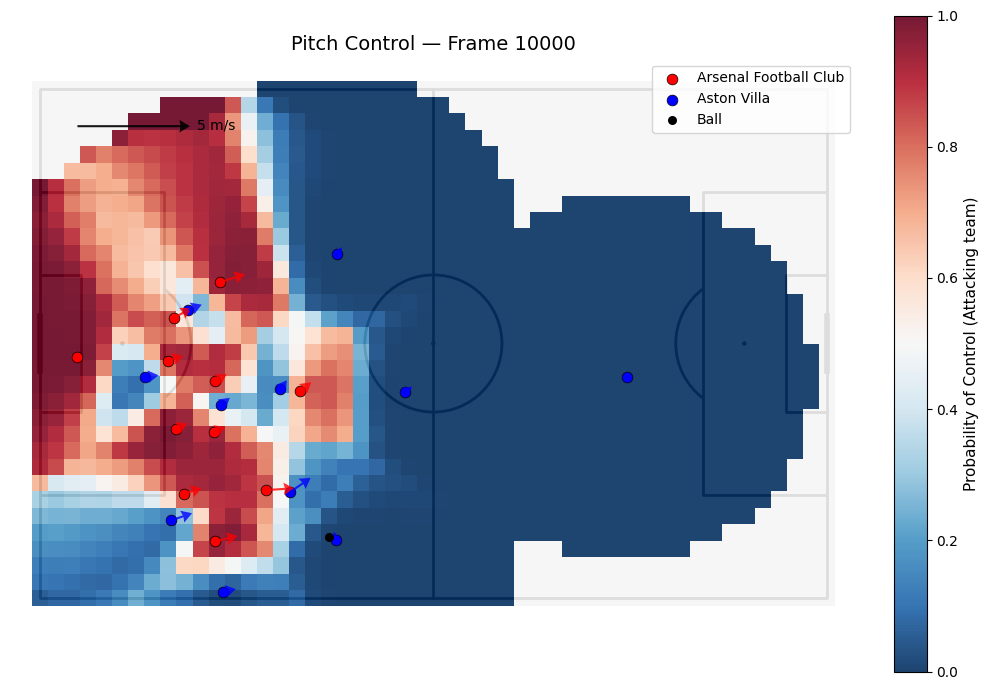

In [59]:
P_att_grid = plot_pitch_control_frame(
    frame=10000,
    home_tracking=home_tr,
    away_tracking=away_tr,
    home_players=home_players,
    away_players=away_players,
    params=params,
    resolution=1
)

In [60]:
P_att_grid.shape

(32, 50)

In [58]:
P_att_grid[8,0]

0.9970799411683784

In [ ]:
# Analyse du Pitch Control seulement lorsque l'équipe en possession attaque dans le final third du terrain adverse (ou le camp adverse)
# On pourra calculer et afficher seulement sur la moitié du terrain pour limiter le temps de calcul

# Calculate player Pitch Control

In [ ]:
# ajouter fonction pour calculer pitch control pour un seul joueur
# il faut créer 2 dataframes : un où l'équipe home attaque de gauche à droite, et un où l'équipe away attaque de gauche à droite (si on veut intégrer les frames des 2 équipes dans le modèle)
# retirer les frames où le joueur est hors jeu (parce que l'espace créé n'est pas pertinent dans le clustering)
# on pourrait afficher les lignes de défense adverse (clustering module 2): à intégrer dans le clustering pour ajouter cette dimension supplémentaire (donner une 2eme map comme input avec les lignes ?)
# sur quoi veut on faire les clusters ? sur la moyenne de chaque zone durant la possession ? sur la totalité de la zone contrôlée pendant la possession ?
# on ne veut pas forcément moyenniser : une fois qu'on aura identifier les différents types de pitch control d'un attaquant, on pourra avoir la part de chaque cluster pour chaque attaquant
# 10 frames par seconde c'est sans doute trop, on pourrait moyenniser par seconde

In [ ]:
# une fois les clusters identifiés :
# on pourra regarder la répartition des clusters par joueur
# estimer le % de réception dans ces espaces (la passe est-elle faite dans un espace contrôlé par l'attaquant, dont on a prédit qu'elle appartenait à telle cluster id ?)
# quelle est le xT moyen des passes faites dans ces espaces ? (info dynamic data Skillcorner)
# mesurer comment l'attaquant bonifie ces espaces une fois qu'il a le ballon (delta xT positif ensuite ?)
# Evolution des clusters au cours d'un match

In [67]:
df.columns

Index(['match_id', 'time', 'frame', 'period', 'player_id', 'is_detected',
       'is_ball', 'x', 'y', 'x_rescaled', 'y_rescaled', 'team_id', 'team_name',
       'team_short', 'player_short_name', 'player_role', 'position_group',
       'home_team_id', 'away_team_id', 'x_norm', 'y_norm', 'attacking_side',
       'ball_in_play', 'in_possession_team'],
      dtype='object')

In [70]:
df.tail()

,match_id,time,frame,period,player_id,is_detected,is_ball,x,y,x_rescaled,y_rescaled,team_id,team_name,team_short,player_short_name,player_role,position_group,home_team_id,away_team_id,x_norm,y_norm,attacking_side,ball_in_play,in_possession_team,event_id,player_in_possession_id,frame_start,frame_end
4273,1895412,01:33:27.20,56752,2,25966,True,False,23.68,-16.04,76.407692,17.96,31.0,Manchester United,Manchester U,M. Ugarte,Right Midfield,Midfield,3.0,31.0,76.407692,17.96,left_to_right,True,31.0,8_998,1498,56748,56752
4274,1895412,01:33:27.20,56752,2,31709,True,False,24.41,-30.29,77.144712,3.71,31.0,Manchester United,Manchester U,Antony,Center Forward,Center Forward,3.0,31.0,77.144712,3.71,left_to_right,True,31.0,8_998,1498,56748,56752
4275,1895412,01:33:27.20,56752,2,64677,True,False,36.00,-13.48,88.846154,20.52,3.0,Arsenal Football Club,Arsenal,J. Kiwior,Left Center Back,Central Defender,3.0,31.0,88.846154,20.52,right_to_left,True,31.0,8_998,1498,56748,56752
4276,1895412,01:33:27.20,56752,2,152232,True,False,16.02,-20.82,68.674038,13.18,31.0,Manchester United,Manchester U,L. Yoro,Right Center Back,Central Defender,3.0,31.0,68.674038,13.18,left_to_right,True,31.0,8_998,1498,56748,56752
4277,1895412,01:33:27.20,56752,2,-1,True,True,34.53,-18.04,87.362019,15.96,NaN,None,None,None,None,None,NaN,NaN,87.362019,15.96,left_to_right,True,31.0,8_998,1498,56748,56752


In [71]:
df.position_group.unique()

array(['Other', 'Wide Attacker', 'Full Back', 'Midfield',
       'Central Defender', 'Center Forward', None], dtype=object)

In [ ]:
Attacking Midfield

In [54]:
df[(df['player_role'] == 'Center Forward') & (df['team_id'] == 31.0)]['player_short_name'].iloc[0]

'R. Højlund'

In [52]:
df[(df['position_group'] == 'Center Forward') & (df['team_id'] == 3.0)]['player_short_name'].iloc[0]

'K. Havertz'

In [103]:
df[(df['position_group'] == 'Center Forward') & (df['team_id'] == 3.0)]['player_id'].iloc[0]

12485

In [130]:
def plot_individual_pitch_control(
    player_id,
    frame,
    home_tracking,
    away_tracking,
    home_players,
    away_players,
    params,
    pitch_length=105,
    pitch_width=68,
    resolution=3,
    arrow_scale=1,
    half_pitch=False
):
    """
    Calcule et affiche le Pitch Control d’un joueur spécifique (player_id)
    contre tous les adversaires, à un instant donné (frame).
    
    Si half_pitch=True, le calcul et le plot ne concernent que la moitié droite du terrain.
    """

    # ---- 1. Identifier les équipes et joueurs ----
    
    if player_id in home_players:
        player_team = 'home'
        att_players = get_players_state(home_tracking, frame, [player_id])
        def_players = get_players_state(away_tracking, frame, away_players)
        att_team_name = home_tracking.team_name.iloc[0]
        def_team_name = away_tracking.team_name.iloc[0]
    elif player_id in away_players:
        player_team = 'away'
        att_players = get_players_state(away_tracking, frame, [player_id])
        def_players = get_players_state(home_tracking, frame, home_players)
        att_team_name = away_tracking.team_name.iloc[0]
        def_team_name = home_tracking.team_name.iloc[0]
        
    else:
        raise ValueError(f"player_id {player_id} not found in tracking data")

    # ---- 2. Grille spatiale ----
    n_grid_x = int(50 * resolution)
    n_grid_y = int(32 * resolution)

    if half_pitch:
        x_min, x_max = pitch_length / 2, pitch_length
    else:
        x_min, x_max = 0, pitch_length

    x = np.linspace(x_min, x_max, n_grid_x)
    y = np.linspace(0, pitch_width, n_grid_y)
    P_player_grid = np.zeros((len(y), len(x)))

    # ---- 3. Calcul du pitch control sur chaque cellule ----
    for ix, xx in enumerate(x):
        for iy, yy in enumerate(y):
            try:
                p = calculate_pitch_control_at_target_full(
                    (xx, yy), att_players, def_players, params
                )
                P_player_grid[iy, ix] = (
                    p["P_att"] if not np.isnan(p["P_att"]) else 0.5
                )
            except Exception:
                P_player_grid[iy, ix] = 0.5

    P_player_grid[P_player_grid == 0.5] = 0

    # ---- 4. Définition du pitch ----
    pitch = Pitch(
        pitch_type="custom",
        pitch_length=pitch_length,
        pitch_width=pitch_width,
        line_color="black",
        pitch_color="white"
    )

    cmap = plt.cm.RdBu_r
    cmap.set_bad(color="white")
    bin_statistic = dict(statistic=P_player_grid, x_grid=x, y_grid=y)

    # ---- 5. Plot ----
    fig, ax = pitch.draw(figsize=(10 if half_pitch else 11, 7))
    pcm = pitch.heatmap(
        bin_statistic,
        ax=ax,
        cmap=cmap,
        vmin=0,
        vmax=1,
        alpha=0.9,
    )

    if half_pitch:
        ax.set_xlim(pitch_length / 2, pitch_length)
        ax.set_ylim(0, pitch_width)

    # ---- 6. Barre de couleur ----
    cbar = plt.colorbar(pcm, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Probability of Control", fontsize=11)

    # ---- 7. Scatter du joueur + adversaires ----
    def extract_xyv(players):
        x = np.array([p["x"] for p in players if not np.isnan(p["x"])])
        y = np.array([p["y"] for p in players if not np.isnan(p["y"])])
        vx = np.array([p["vx"] for p in players if not np.isnan(p["vx"])])
        vy = np.array([p["vy"] for p in players if not np.isnan(p["vy"])])
        return x, y, vx, vy

    att_x, att_y, att_vx, att_vy = extract_xyv(att_players)
    def_x, def_y, def_vx, def_vy = extract_xyv(def_players)

    pitch.scatter(
        att_x, att_y, c="red", s=100, marker="*", 
        label=f"Player {player_id}", ax=ax, edgecolors="black", linewidth=1.2, zorder=6
    )
    pitch.scatter(
        def_x, def_y, c="blue", s=60, label=def_team_name, 
        ax=ax, edgecolors="black", linewidth=0.5, zorder=5
    )

    # ---- 8. Flèches de vitesse ----
    pitch.arrows(
        att_x, att_y, att_x + att_vx * arrow_scale, att_y + att_vy * arrow_scale,
        color="red", ax=ax, width=1.5, headwidth=5, alpha=0.9, zorder=7
    )
    pitch.arrows(
        def_x, def_y, def_x + def_vx * arrow_scale, def_y + def_vy * arrow_scale,
        color="blue", ax=ax, width=1.2, headwidth=4, alpha=0.8, zorder=5
    )

    # ---- 9. Ballon ----
    if {"ball_x", "ball_y"}.issubset(home_tracking.columns):
        ball_x = home_tracking.loc[home_tracking.frame == frame, "ball_x"].values[0]
        ball_y = home_tracking.loc[home_tracking.frame == frame, "ball_y"].values[0]
        pitch.scatter(ball_x, ball_y, c="black", s=30, label="Ball", ax=ax, zorder=8)

    ## ---- 10. Échelle de vitesse ----
    #ref_speed = 5  # m/s
    #ref_arrow_len = ref_speed * arrow_scale
    #x0, y0 = x_min + 5, pitch_width - 5
    #pitch.arrows(
    #    x0, y0, x0 + ref_arrow_len, y0,
    #    color="black", ax=ax, width=1.2, headwidth=5, alpha=0.9, zorder=7
    #)
    #ax.text(x0 + ref_arrow_len + 1, y0 - 0.5, "5 m/s", fontsize=10, color="black")

    # ---- 11. Mise en forme finale ----
    team_label = att_team_name if player_team == 'home' else def_team_name
    #plt.legend(loc="upper right")
    plt.title(
        f"Individual Pitch Control - K. Havertz | Frame {frame}",
        fontsize=14
    )
    plt.tight_layout()
    plt.show()

    return P_player_grid

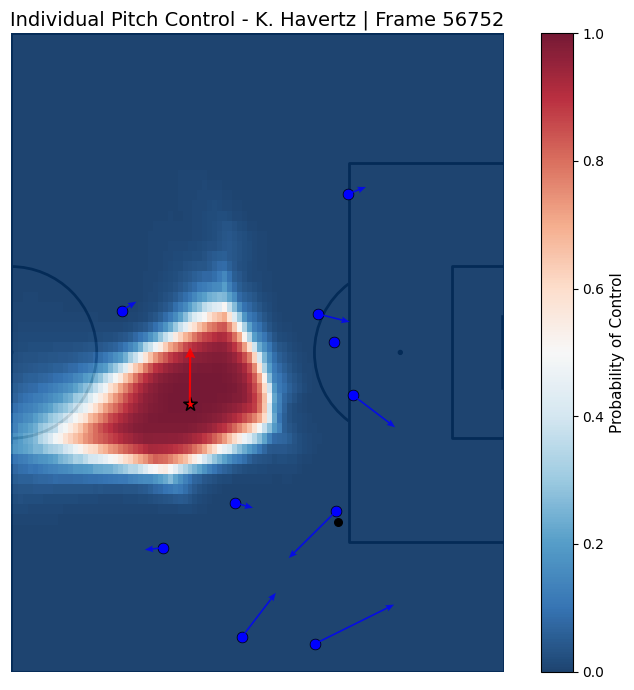

In [131]:
P_individual = plot_individual_pitch_control(
    player_id=12485,
    frame=56752,
    home_tracking=home_tr,
    away_tracking=away_tr,
    home_players=home_players,
    away_players=away_players,
    params=params,
    resolution=2,
    half_pitch=True
)

In [148]:
P_individual.shape

(32, 50)

In [119]:
from scipy.ndimage import gaussian_filter

def generate_array(reference_array, max_val=0.6, sparsity=0.7, smooth_sigma=1.0):
    """
    Génère un nouvel array avec les mêmes positions nulles que reference_array,
    des valeurs aléatoires proches les unes des autres et majoritairement 0.
    
    Parameters:
    - reference_array : np.array de shape (32, 50)
    - max_val : valeur maximale des valeurs aléatoires
    - sparsity : proportion de zéros
    - smooth_sigma : sigma pour le filtre gaussien (lissage spatial)
    """
    
    # Création d'un masque pour conserver les positions nulles
    mask_nonnull = reference_array != 0
    
    # Génération d'un array aléatoire majoritairement zéro
    random_array = np.random.rand(*reference_array.shape)
    random_array[random_array > (1 - sparsity)] = 0  # met une majorité de valeurs à 0
    random_array *= max_val  # scale les valeurs non-nulles
    
    # Appliquer un lissage pour créer une progression douce
    smoothed_array = gaussian_filter(random_array, sigma=smooth_sigma)
    
    # Remettre les positions nulles à 0
    smoothed_array[~mask_nonnull] = 0
    
    return smoothed_array

# Exemple d'utilisation
reference_array = np.random.randint(0, 2, size=(32, 50))  # exemple de matrice 0/1
new_array = generate_array(reference_array)

print(new_array)

In [137]:
def generate_progressive_array(reference_array, threshold=0.5, activation_ratio=0.2, smooth_sigma=1.5):
    """
    Génère un nouvel array à partir d'une matrice de référence :
      - valeurs <= 0.5 -> 0
      - valeurs > 0.5 -> majorité de 0, 1/5 proches de 1,
        avec une décroissance progressive dans le voisinage
    """
    
    # Étape 1 : Initialisation
    new_array = np.zeros_like(reference_array)
    
    # Étape 2 : Masque des valeurs > 0.5
    mask_high = reference_array > threshold
    
    # Étape 3 : Sélection de 1/5 des points à activer
    high_indices = np.argwhere(mask_high)
    n_active = int(len(high_indices) * activation_ratio)
    
    if n_active > 0:
        active_indices = high_indices[np.random.choice(len(high_indices), n_active, replace=False)]
        for i, j in active_indices:
            new_array[i, j] = 1  # activation centrale
    
    # Étape 4 : Diffusion pour créer la décroissance progressive
    new_array = gaussian_filter(new_array, sigma=smooth_sigma)
    
    # Étape 5 : Réappliquer le masque (pour garder 0 ailleurs)
    new_array[~mask_high] = 0
    
    # Étape 6 : Normalisation [0, 1]
    if new_array.max() > 0:
        new_array /= new_array.max()
        new_array *= 0.1
    
    return new_array

In [138]:
def plot_fake_x_pass(
    player_id,
    frame,
    home_tracking,
    away_tracking,
    home_players,
    away_players,
    params,
    pitch_length=105,
    pitch_width=68,
    resolution=3,
    arrow_scale=1,
    half_pitch=False
):
    """
    Calcule et affiche le Pitch Control d’un joueur spécifique (player_id)
    contre tous les adversaires, à un instant donné (frame).
    
    Si half_pitch=True, le calcul et le plot ne concernent que la moitié droite du terrain.
    """

    # ---- 1. Identifier les équipes et joueurs ----
    
    if player_id in home_players:
        player_team = 'home'
        att_players = get_players_state(home_tracking, frame, [player_id])
        def_players = get_players_state(away_tracking, frame, away_players)
        att_team_name = home_tracking.team_name.iloc[0]
        def_team_name = away_tracking.team_name.iloc[0]
    elif player_id in away_players:
        player_team = 'away'
        att_players = get_players_state(away_tracking, frame, [player_id])
        def_players = get_players_state(home_tracking, frame, home_players)
        att_team_name = away_tracking.team_name.iloc[0]
        def_team_name = home_tracking.team_name.iloc[0]
        
    else:
        raise ValueError(f"player_id {player_id} not found in tracking data")

    # ---- 2. Grille spatiale ----
    n_grid_x = int(50 * resolution)
    n_grid_y = int(32 * resolution)

    if half_pitch:
        x_min, x_max = pitch_length / 2, pitch_length
    else:
        x_min, x_max = 0, pitch_length

    x = np.linspace(x_min, x_max, n_grid_x)
    y = np.linspace(0, pitch_width, n_grid_y)
    P_player_grid = np.zeros((len(y), len(x)))

    # ---- 3. Calcul du pitch control sur chaque cellule ----
    for ix, xx in enumerate(x):
        for iy, yy in enumerate(y):
            try:
                p = calculate_pitch_control_at_target_full(
                    (xx, yy), att_players, def_players, params
                )
                P_player_grid[iy, ix] = (
                    p["P_att"] if not np.isnan(p["P_att"]) else 0.5
                )
            except Exception:
                P_player_grid[iy, ix] = 0.5

    P_player_grid[P_player_grid == 0.5] = 0
    
    Xpass_grid = generate_progressive_array(P_player_grid)

    # ---- 4. Définition du pitch ----
    pitch = Pitch(
        pitch_type="custom",
        pitch_length=pitch_length,
        pitch_width=pitch_width,
        line_color="black",
        pitch_color="white"
    )

    cmap = plt.cm.RdBu_r
    cmap.set_bad(color="white")
    bin_statistic = dict(statistic=Xpass_grid, x_grid=x, y_grid=y)

    # ---- 5. Plot ----
    fig, ax = pitch.draw(figsize=(10 if half_pitch else 11, 7))
    pcm = pitch.heatmap(
        bin_statistic,
        ax=ax,
        cmap=cmap,
        vmin=0,
        vmax=1,
        alpha=0.9,
    )

    if half_pitch:
        ax.set_xlim(pitch_length / 2, pitch_length)
        ax.set_ylim(0, pitch_width)

    # ---- 6. Barre de couleur ----
    cbar = plt.colorbar(pcm, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("xThreat probability", fontsize=11)


    # ---- 11. Mise en forme finale ----
    plt.title(
        f"xThreat in controled zones - K. Havertz | Frame {frame}",
        fontsize=14
    )
    plt.tight_layout()
    plt.show()

    return Xpass_grid

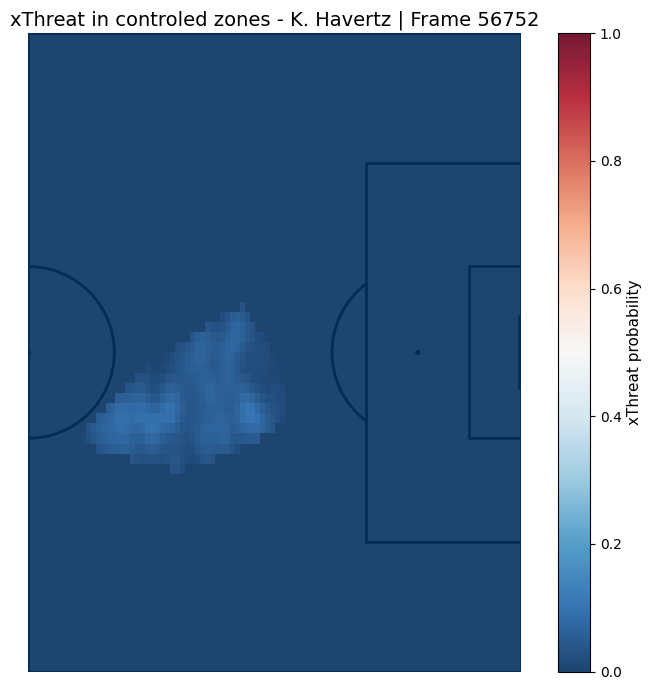

In [139]:
P_x_pass = plot_fake_x_pass(
    player_id=12485,
    frame=56752,
    home_tracking=home_tr,
    away_tracking=away_tr,
    home_players=home_players,
    away_players=away_players,
    params=params,
    resolution=2,
    half_pitch=True
)

In [10]:
def calculate_individual_pitch_control_all_pitch(
    player_id,
    frame,
    home_tracking,
    away_tracking,
    home_players,
    away_players,
    params,
    pitch_length=105,
    pitch_width=68,
    resolution=3,
    half_pitch=False
):
    """
    Calcule le Pitch Control d’un joueur spécifique (player_id)
    contre tous les adversaires, à un instant donné (frame).
    
    Si half_pitch=True, le calcul ne concerne que la moitié droite du terrain.
    """

    # ---- 1. Identifier les équipes et joueurs ----
    if player_id in home_players:
        att_players = get_players_state(home_tracking, frame, [player_id])
        def_players = get_players_state(away_tracking, frame, away_players)
    elif player_id in away_players:
        att_players = get_players_state(away_tracking, frame, [player_id])
        def_players = get_players_state(home_tracking, frame, home_players)
    else:
        raise ValueError(f"player_id {player_id} not found in tracking data")

    # ---- 2. Grille spatiale ----
    n_grid_x = int(50 * resolution)
    n_grid_y = int(32 * resolution)

    if half_pitch:
        x_min, x_max = pitch_length / 2, pitch_length
    else:
        x_min, x_max = 0, pitch_length

    x = np.linspace(x_min, x_max, n_grid_x)
    y = np.linspace(0, pitch_width, n_grid_y)
    P_player_grid = np.zeros((len(y), len(x)))

    # ---- 3. Calcul du pitch control sur chaque cellule ----
    for ix, xx in enumerate(x):
        for iy, yy in enumerate(y):
            try:
                p = calculate_pitch_control_at_target_full(
                    (xx, yy), att_players, def_players, params
                )
                P_player_grid[iy, ix] = (
                    p["P_att"] if not np.isnan(p["P_att"]) else 0.5
                )
            except Exception:
                P_player_grid[iy, ix] = 0.5

    P_player_grid[P_player_grid == 0.5] = 0

    return P_player_grid

In [144]:
frames = list(home_tr.frame.unique())[:100]

In [151]:

frames_list = []
for frame in frames:
    P_player_grid = calculate_individual_pitch_control_all_pitch(
        player_id=12485,
        frame=frame,
        home_tracking=home_tr,
        away_tracking=away_tr,
        home_players=home_players,
        away_players=away_players,
        params=params,
        resolution=1,
        half_pitch=True
    )
    frames_list.append(P_player_grid)

In [152]:
pitch_control_maps = np.stack(frames_list)

In [153]:
pitch_control_maps.shape

(100, 32, 50)

# Identify defensive lines

In [238]:
away_tr.head()

,frame,x_norm_3066,x_norm_6149,x_norm_6355,x_norm_11041,x_norm_11304,x_norm_12476,x_norm_18568,x_norm_18661,x_norm_18948,x_norm_18952,x_norm_29799,x_norm_32163,x_norm_33234,x_norm_66458,x_norm_68806,y_norm_3066,y_norm_6149,y_norm_6355,y_norm_11041,y_norm_11304,y_norm_12476,y_norm_18568,y_norm_18661,y_norm_18948,y_norm_18952,y_norm_29799,y_norm_32163,y_norm_33234,y_norm_66458,y_norm_68806,ball_x,ball_y,Period,Time [s],team_name,vx_3066,vy_3066,vx_11041,vy_11041,vx_11304,vy_11304,vx_12476,vy_12476,vx_18568,vy_18568,vx_18661,vy_18661,vx_18948,vy_18948,vx_18952,vy_18952,vx_29799,vy_29799,vx_32163,vy_32163,vx_33234,vy_33234,vx_68806,vy_68806,vx_6355,vy_6355,vx_66458,vy_66458,vx_6149,vy_6149
0,812,100.204327,NaN,NaN,65.857212,77.164904,83.394231,85.908173,74.186538,56.447596,83.959615,81.324519,70.481250,77.720192,NaN,NaN,35.58,NaN,NaN,53.73,53.00,38.69,55.11,63.43,42.22,47.13,30.87,31.23,39.67,NaN,NaN,71.914904,65.52,1,00:01:20.20,Aston Villa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,863,98.881731,NaN,NaN,62.071154,69.946154,80.577404,79.678846,72.571154,61.697596,80.385577,80.193750,67.735096,76.125000,NaN,NaN,35.27,NaN,NaN,56.12,55.86,37.52,58.47,61.22,44.13,44.71,24.70,29.07,34.12,NaN,NaN,62.485096,59.16,1,00:01:25.30,Aston Villa,-5.290385,-1.24,-15.144231,9.56,-28.875000,11.44,-11.267308,-4.68,-24.917308,13.44,-6.461538,-8.84,21.000000,7.64,-14.296154,-9.68,-4.523077,-24.68,-10.984615,-8.64,-6.380769,-22.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,885,99.921635,NaN,NaN,65.200962,77.346635,82.091827,76.811538,76.064423,63.747115,83.848558,82.081731,69.522115,78.325962,NaN,NaN,35.93,NaN,NaN,59.58,57.70,39.68,66.96,65.07,45.55,50.25,27.65,31.28,36.82,NaN,NaN,78.356250,66.12,1,00:01:27.50,Aston Villa,4.159615,2.64,12.519231,13.84,29.601923,7.36,6.057692,8.64,-11.469231,33.96,13.973077,15.40,8.198077,5.68,13.851923,22.16,7.551923,11.80,7.148077,8.84,8.803846,10.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,903,101.193750,NaN,NaN,71.157692,84.888462,86.140385,80.890385,78.124038,65.039423,87.856731,84.100962,73.812981,81.839423,NaN,NaN,35.85,NaN,NaN,58.61,59.61,43.72,66.78,63.92,45.00,51.89,29.35,32.22,38.31,NaN,NaN,83.050962,60.69,1,00:01:29.30,Aston Villa,5.088462,-0.32,23.826923,-3.88,30.167308,7.64,16.194231,16.16,16.315385,-0.72,8.238462,-4.60,5.169231,-2.20,16.032692,6.56,8.076923,6.80,17.163462,3.76,14.053846,5.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,923,101.900481,NaN,NaN,81.284135,82.727885,87.543750,86.059615,80.012019,65.291827,88.472596,86.998558,79.416346,84.565385,NaN,NaN,35.41,NaN,NaN,53.89,54.65,43.49,59.21,58.39,44.00,47.61,29.54,32.57,37.77,NaN,NaN,82.596635,54.20,1,00:01:31.30,Aston Villa,2.826923,-1.76,40.505769,-18.88,-8.642308,-19.84,5.613462,-0.92,20.676923,-30.28,7.551923,-22.12,1.009615,-4.00,2.463462,-17.12,11.590385,0.76,22.413462,1.40,10.903846,-2.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [98]:
from sklearn.cluster import AgglomerativeClustering

def identify_and_plot_defensive_lines(
    frame,
    away_tracking,
    away_players,
    n_clusters_options=(2, 3),
    pitch_length=105,
    pitch_width=68,
    half_pitch=True
):

    # 1️⃣ Extraire les positions (x, y) des joueurs adverses pour la frame
    positions = []
    player_ids = []
    row = away_tracking.loc[away_tracking['frame'] == frame]
    for pid in away_players:
        if f"x_norm_{pid}" in row.columns and f"y_norm_{pid}" in row.columns:
            x = row[f"x_norm_{pid}"].values[0]
            y = row[f"y_norm_{pid}"].values[0]
            if not np.isnan(x) and not np.isnan(y):
                positions.append([x, y])
                player_ids.append(pid)

    if len(positions) < 4:
        print(f"Frame {frame}: pas assez de joueurs adverses pour former des lignes défensives.")
        return None

    positions = np.array(positions)

    # Identifier et retirer le gardien (le joueur avec le x le plus faible)
    gk_index = np.argmax(positions[:, 0])  # le plus proche du but (à gauche)
    positions = np.delete(positions, gk_index, axis=0)
    player_ids = np.delete(player_ids, gk_index)

    # 2️⃣ Tester plusieurs nombres de clusters (2 ou 3 typiquement)
    best_model = None
    best_score = np.inf

    for n_clusters in n_clusters_options:
        model = AgglomerativeClustering(n_clusters=n_clusters)
        labels = model.fit_predict(positions[:, [0]])  # on clusterise selon x uniquement
        # mesurer la cohésion intra-cluster (écart-type moyen)
        intra_var = np.mean([np.std(positions[labels == k, 0]) for k in range(n_clusters)])
        if intra_var < best_score:
            best_score = intra_var
            best_model = model

    # 3️⃣ Récupérer les clusters finaux
    labels = best_model.fit_predict(positions[:, [0]])
    n_clusters = len(np.unique(labels))

    # 4️⃣ Calculer la ligne moyenne par cluster
    line_means = []
    for k in range(n_clusters):
        cluster_pts = positions[labels == k]
        x_mean = np.mean(cluster_pts[:, 0])
        y_mean = np.mean(cluster_pts[:, 1])
        line_means.append((x_mean, y_mean))

    # Trier les lignes de la plus proche du but à la plus éloignée
    line_means = sorted(line_means, key=lambda l: l[0])

    # 5️⃣ Plot sur un half pitch
    pitch = Pitch(
        pitch_type='custom',
        pitch_length=pitch_length,
        pitch_width=pitch_width,
        line_color='black',
        pitch_color='white'
    )
    fig, ax = pitch.draw(figsize=(8, 6))

    # Limiter au half pitch si demandé
    if half_pitch:
        ax.set_xlim(pitch_length / 2, pitch_length)
        ax.set_ylim(0, pitch_width)

    # 6️⃣ Afficher les positions et les lignes
    ax.scatter(positions[:, 0], positions[:, 1], color='blue', s=60, label=f'Defending players')

    for i, (x_mean, y_mean) in enumerate(line_means):
        # Tracer la ligne horizontale
        ax.axvline(x=x_mean, color='red', linestyle='--', linewidth=2)
        ax.text(x_mean + 1, pitch_width - 3, f'Ligne {i+1}', color='red', fontsize=10)

    plt.title(f"Lignes défensives (Frame {frame})", fontsize=14)
    plt.legend()
    plt.show()

    return {
        'frame': frame,
        'n_lines': n_clusters,
        'line_means': line_means,
        'positions': positions,
        'labels': labels
    }

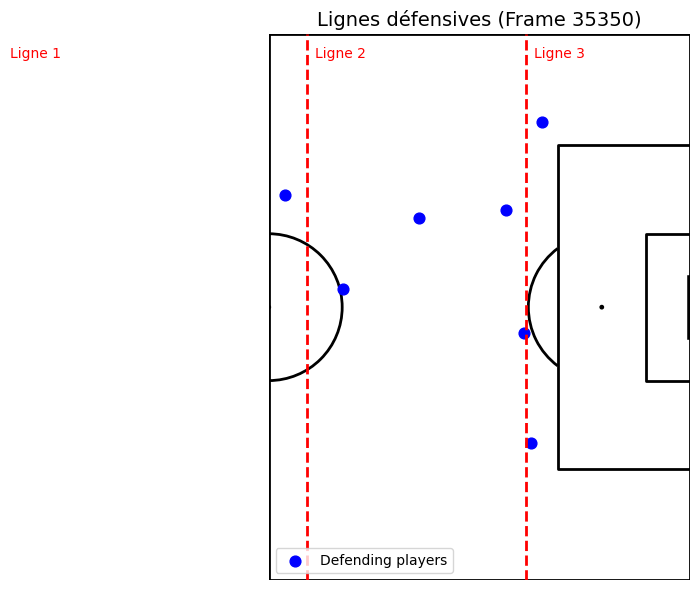

In [99]:
result = identify_and_plot_defensive_lines(
    frame=35350,
    away_tracking=away_tr,
    away_players=away_players
)

In [32]:
from sklearn.cluster import AgglomerativeClustering

def calculate_defensive_lines(
    frame,
    away_tracking,
    away_players,
    n_clusters_options=(2, 3)
):

    # 1️⃣ Extraire les positions (x, y) des joueurs adverses pour la frame
    positions = []
    player_ids = []
    row = away_tracking.loc[away_tracking['frame'] == frame]
    for pid in away_players:
        if f"x_norm_{pid}" in row.columns and f"y_norm_{pid}" in row.columns:
            x = row[f"x_norm_{pid}"].values[0]
            y = row[f"y_norm_{pid}"].values[0]
            if not np.isnan(x) and not np.isnan(y):
                positions.append([x, y])
                player_ids.append(pid)

    if len(positions) < 4:
        print(f"Frame {frame}: pas assez de joueurs adverses pour former des lignes défensives.")
        return None

    positions = np.array(positions)

    # Identifier et retirer le gardien (le joueur avec le x le plus faible)
    gk_index = np.argmax(positions[:, 0])  # le plus proche du but (à gauche)
    positions = np.delete(positions, gk_index, axis=0)
    player_ids = np.delete(player_ids, gk_index)

    # 2️⃣ Tester plusieurs nombres de clusters (2 ou 3 typiquement)
    best_model = None
    best_score = np.inf

    for n_clusters in n_clusters_options:
        model = AgglomerativeClustering(n_clusters=n_clusters)
        labels = model.fit_predict(positions[:, [0]])  # on clusterise selon x uniquement
        # mesurer la cohésion intra-cluster (écart-type moyen)
        intra_var = np.mean([np.std(positions[labels == k, 0]) for k in range(n_clusters)])
        if intra_var < best_score:
            best_score = intra_var
            best_model = model

    # 3️⃣ Récupérer les clusters finaux
    labels = best_model.fit_predict(positions[:, [0]])
    n_clusters = len(np.unique(labels))

    # 4️⃣ Calculer la ligne moyenne par cluster
    line_means = []
    for k in range(n_clusters):
        cluster_pts = positions[labels == k]
        x_mean = np.mean(cluster_pts[:, 0])
        line_means.append(x_mean)

    # Trier les lignes de la plus proche du but à la plus éloignée
    line_means = sorted(line_means)

    return line_means

In [286]:
result = calculate_defensive_lines(
    frame=3863,
    away_tracking=away_tr,
    away_players=away_players
)

# Extract contextual information from a frame

In [12]:
def extract_player_context(
    frame: int,
    player_id: str,
    home_tr: pd.DataFrame,
    away_tr: pd.DataFrame,
    home_players: list,
    away_players: list
):
    """
    Extrait les informations de contexte d’un joueur à une frame donnée :
    - position du joueur
    - position du ballon
    - en possession du ballon (True/False)
    - distance au ballon
    - distance au coéquipier le plus proche
    - distance au joueur adverse le plus proche
    """

    # Déterminer si le joueur est à domicile ou à l'extérieur
    if player_id in home_players:
        team_tr, opp_tr = home_tr, away_tr
        teammates = [p for p in home_players if p != player_id]
        opponents = away_players
    elif player_id in away_players:
        team_tr, opp_tr = away_tr, home_tr
        teammates = [p for p in away_players if p != player_id]
        opponents = home_players
    else:
        raise ValueError(f"Le player_id {player_id} n'appartient à aucune des deux équipes.")

    # Extraire la ligne correspondant à la frame
    row_team = team_tr.loc[team_tr["frame"] == frame]
    row_opp = opp_tr.loc[opp_tr["frame"] == frame]
    if row_team.empty or row_opp.empty:
        raise ValueError(f"La frame {frame} est absente du tracking fourni.")

    # ---- 1️⃣ Position du joueur ----
    player_pos = np.array([
        row_team[f"x_norm_{player_id}"].values[0],
        row_team[f"y_norm_{player_id}"].values[0]
    ])

    # ---- 2️⃣ Position du ballon ----
    ball_pos = np.array([
        row_team["ball_x"].values[0],
        row_team["ball_y"].values[0]
    ])

    # ---- 3️⃣ Est-ce que le joueur est en possession ? ----
    player_in_possession_id = row_team["player_id_in_possession"].values[0]
    in_possession = player_in_possession_id == player_id

    # ---- 4️⃣ Distance au ballon ----
    distance_to_ball = np.linalg.norm(player_pos - ball_pos)

    # ---- 5️⃣ Distance au coéquipier le plus proche ----
    teammate_positions = []
    for pid in teammates:
        x, y = row_team[f"x_norm_{pid}"].values[0], row_team[f"y_norm_{pid}"].values[0]
        if not np.isnan(x) and not np.isnan(y):
            teammate_positions.append([x, y])

    if teammate_positions:
        teammate_positions = np.array(teammate_positions)
        distance_to_nearest_teammate = np.min(np.linalg.norm(teammate_positions - player_pos, axis=1))
    else:
        distance_to_nearest_teammate = np.nan

    # ---- 6️⃣ Distance au joueur adverse le plus proche ----
    opponent_positions = []
    for pid in opponents:
        x, y = row_opp[f"x_norm_{pid}"].values[0], row_opp[f"y_norm_{pid}"].values[0]
        if not np.isnan(x) and not np.isnan(y):
            opponent_positions.append([x, y])

    if opponent_positions:
        opponent_positions = np.array(opponent_positions)
        distance_to_nearest_opponent = np.min(np.linalg.norm(opponent_positions - player_pos, axis=1))
    else:
        distance_to_nearest_opponent = np.nan

    # ---- Résumé ----
    return {
        "frame": frame,
        "player_id": player_id,
        "player_position": tuple(player_pos),
        "ball_position": tuple(ball_pos),
        "in_possession": in_possession,
        "distance_to_ball": distance_to_ball,
        "distance_to_nearest_teammate": distance_to_nearest_teammate,
        "distance_to_nearest_opponent": distance_to_nearest_opponent
    }

In [266]:
player_context = extract_player_context(
    frame=3863,
    player_id=12485,
    home_tr=home_tr,
    away_tr=away_tr,
    home_players=home_players,
    away_players=away_players
)

In [267]:
player_context

{'frame': 3863,
 'player_id': 12485,
 'player_position': (86.27163461538463, 36.93),
 'ball_position': (79.275, 7.329999999999998),
 'distance_to_ball': 30.415668592703966,
 'distance_to_nearest_teammate': 5.78285622097638,
 'distance_to_nearest_opponent': 0.9454063847089875}

# Global extraction function for a frame

In [88]:
def extract_player_pitch_control_and_contextual(
    player_id,
    frame,
    home_tracking,
    away_tracking,
    home_players,
    away_players,
    params,
    pitch_length=105,
    pitch_width=68,
    resolution=1,
    half_pitch=True
):

    # ---- 1. Calcul du pitch control individuel ----
    P_player_grid = calculate_individual_pitch_control_all_pitch(
        player_id,
        frame,
        home_tracking,
        away_tracking,
        home_players,
        away_players,
        params,
        pitch_length,
        pitch_width,
        resolution,
        half_pitch
    )

    # ---- 2. Identify defensive lines ----
    line_means = calculate_defensive_lines(
        frame,
        away_tracking,
        away_players,
        n_clusters_options=(2, 3)
    )

    # ---- 3. Extraction du contexte du joueur ----
    player_context = extract_player_context(
        frame,
        player_id,
        home_tracking,
        away_tracking,
        home_players,
        away_players
    )

    player_frame_info = {
        "pitch_control_map": P_player_grid,
        "defensive_lines": line_means
    }

    player_frame_info.update(player_context)

    return player_frame_info

In [104]:
player_frame_info = extract_player_pitch_control_and_contextual(
        player_id=12485,
        frame=23147,
        home_tracking=home_tr,
        away_tracking=away_tr,
        home_players=home_players,
        away_players=away_players,
        params=params,
        resolution=3,
        half_pitch=True
    )

In [105]:
player_frame_info

{'pitch_control_map': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'defensive_lines': [67.68461538461538, 76.99326923076923, 84.98269230769229],
 'frame': 23147,
 'player_id': 12485,
 'player_position': (78.09374999999999, 6.989999999999998),
 'ball_position': (78.60865384615384, 6.489999999999998),
 'in_possession': True,
 'distance_to_ball': 0.7177227673580061,
 'distance_to_nearest_teammate': 6.685252498655833,
 'distance_to_nearest_opponent': 4.853895953397157}

In [ ]:
def plot_player_pitch_control_and_defensive_lines(
    player_id,
    frame,
    home_tracking,
    away_tracking,
    home_players,
    away_players,
    player_frame_info,
    params,
    pitch_length=105,
    pitch_width=68,
    resolution=3,
    half_pitch=True
):
    """
    Affiche le Pitch Control individuel d’un joueur + les lignes défensives adverses.
    """
    # ---- 1️⃣ Identifier les équipes ----
    if player_id in home_players:
        player_team = "home"
        att_players = get_players_state(home_tracking, frame, [player_id])
        def_players = get_players_state(away_tracking, frame, away_players)
        att_team_name = home_tracking.team_name.iloc[0]
        def_team_name = away_tracking.team_name.iloc[0]
    elif player_id in away_players:
        player_team = "away"
        att_players = get_players_state(away_tracking, frame, [player_id])
        def_players = get_players_state(home_tracking, frame, home_players)
        att_team_name = away_tracking.team_name.iloc[0]
        def_team_name = home_tracking.team_name.iloc[0]
    else:
        raise ValueError(f"player_id {player_id} not found in tracking data")

    # ---- 2️⃣ Grille spatiale ----
    n_grid_x = int(50 * resolution)
    n_grid_y = int(32 * resolution)

    if half_pitch:
        x_min, x_max = pitch_length / 2, pitch_length
    else:
        x_min, x_max = 0, pitch_length

    x = np.linspace(x_min, x_max, n_grid_x)
    y = np.linspace(0, pitch_width, n_grid_y)
    P_player_grid = np.array(player_frame_info.get("pitch_control_map"))

    # ---- 3️⃣ Définir le pitch ----
    pitch = Pitch(
        pitch_type="custom",
        pitch_length=pitch_length,
        pitch_width=pitch_width,
        line_color="black",
        pitch_color="white"
    )

    cmap = plt.cm.RdBu_r
    cmap.set_bad(color="white")
    bin_statistic = dict(statistic=P_player_grid, x_grid=x, y_grid=y)

    # ---- 4️⃣ Plot principal ----
    fig, ax = pitch.draw(figsize=(10 if half_pitch else 11, 7))
    pcm = pitch.heatmap(
        bin_statistic, ax=ax,
        cmap=cmap, vmin=0, vmax=1, alpha=0.9
    )

    if half_pitch:
        ax.set_xlim(pitch_length / 2, pitch_length)
        ax.set_ylim(0, pitch_width)

    # ---- 5️⃣ Barre de couleur ----
    cbar = plt.colorbar(pcm, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Probability of Control (Individual)", fontsize=11)

    # ---- 6️⃣ Extraire coordonnées ----
    def extract_xyv(players):
        x = np.array([p["x"] for p in players if not np.isnan(p["x"])])
        y = np.array([p["y"] for p in players if not np.isnan(p["y"])])
        vx = np.array([p["vx"] for p in players if not np.isnan(p["vx"])])
        vy = np.array([p["vy"] for p in players if not np.isnan(p["vy"])])
        return x, y, vx, vy

    att_x, att_y, att_vx, att_vy = extract_xyv(att_players)
    def_x, def_y, def_vx, def_vy = extract_xyv(def_players)

    # ---- 7️⃣ Scatter des joueurs ----
    pitch.scatter(
        att_x, att_y, c="red", s=120, marker="*",
        label=f"Player {player_id}", ax=ax,
        edgecolors="black", linewidth=1.2, zorder=6
    )
    pitch.scatter(
        def_x, def_y, c="blue", s=60,
        label=def_team_name, ax=ax,
        edgecolors="black", linewidth=0.5, zorder=5
    )

    # ---- 8️⃣ Ballon ----
    if {"ball_x", "ball_y"}.issubset(home_tracking.columns):
        ball_row = home_tracking.loc[home_tracking.frame == frame]
        if not ball_row.empty:
            ball_x = ball_row["ball_x"].values[0]
            ball_y = ball_row["ball_y"].values[0]
            pitch.scatter(ball_x, ball_y, c="black", s=50, label="Ball", ax=ax, zorder=8)

    # ---- 9️⃣ Lignes défensives (rouges) ----
    defensive_lines = player_frame_info.get("defensive_lines", [])
    for i, x_mean in enumerate(defensive_lines):
        if not np.isnan(x_mean):
            ax.axvline(x=x_mean, color="red", linestyle="--", linewidth=2)
            ax.text(x_mean + 0.5, pitch_width - 3, f"Ligne {i+1}",
                    color="red", fontsize=10, weight="bold")

    # ---- 🔟 Mise en forme ----
    plt.legend(loc="upper left")
    plt.title(
        f"Pitch Control (Player {player_id}) + Defensive Lines — Frame {frame}",
        fontsize=14
    )
    plt.tight_layout()
    plt.show()

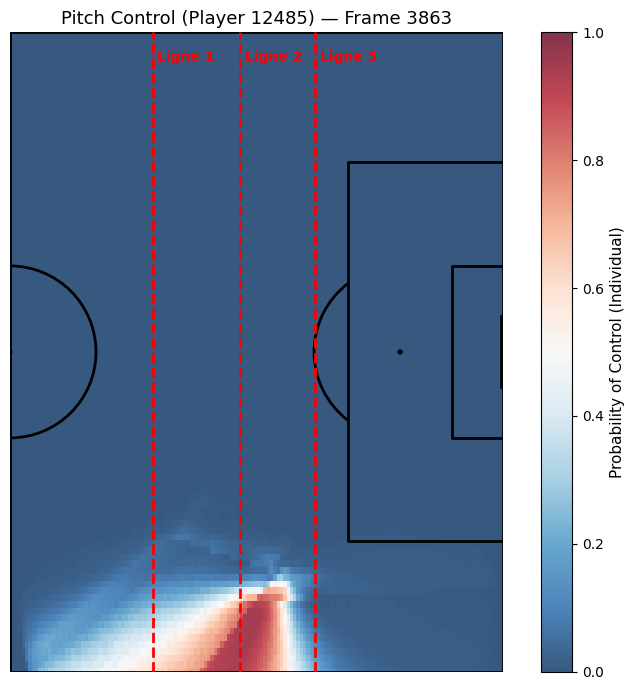

In [117]:
plot_player_pitch_control_and_defensive_lines(
    player_frame_info=player_frame_info,
    home_tracking=home_tr,
    away_tracking=away_tr,
    att_players=home_players,
    def_players=away_players,
    player_id=12485,
    frame=3863
)

# Global function to process all frames of a game

In [38]:
def extract_all_for_position_across_match(
    match_id: str,
    player_position: str,
    params: dict,
    resolution: int = 1,
    pitch_length: float = 105,
    pitch_width: float = 68
):
    """
    Calcule les cartes de pitch control et le contexte joueur pour une position donnée,
    sur tous les fichiers de tracking d’un répertoire de possessions.

    Retourne une liste de dictionnaires contenant :
      - frame
      - pitch_control_map
      - defensive_lines
      - player_id
      - player_position (x, y)
      - ball_position (x, y)
      - in_possession (True/False)
      - distance_to_ball
      - distance_to_nearest_teammate
      - distance_to_nearest_opponent
    """

    all_results = []

    # ---- 2️⃣ Charger le dataframe ----
    df = pd.read_parquet(f"{POSSESSION_DIR}/{match_id}.parquet", storage_options={"token": "google_default"})

    # ---- 3️⃣ Identifier les player_id correspondant à la position ----
    player_ids_by_team = get_player_id_position(df, player_position)
    home_team_id = df["home_team_id"].iloc[0]
    away_team_id = df["away_team_id"].iloc[0]
    home_player_id = player_ids_by_team[home_team_id]
    away_player_id = player_ids_by_team[away_team_id]

    # ---- 4️⃣ Construire les tracking datasets ----
    home_tr, home_players = build_team_tracking(df, "home")
    away_tr, away_players = build_team_tracking(df, "away")

    # ---- 5️⃣ Calculer les vitesses ----
    home_tr = calculate_player_velocities(home_tr, home_players)
    away_tr = calculate_player_velocities(away_tr, away_players)

    # ---- 6️⃣ Itérer sur les frames ----
    frames = list(df["frame"].unique())
    #frames_test = frames[-5:]  # pour test rapide
    #frames_test = random.sample(frames, 50)
    for frame in tqdm(frames, desc=f"Match {match_id}", leave=False):

        # Identifier l’équipe en possession
        in_possession_team = df.loc[df["frame"] == frame, "in_possession_team"].values[0]

        # Déterminer le player_id du joueur concerné
        if in_possession_team == home_team_id:
            player_id = home_player_id
            if player_id is None:
                continue  # aucune correspondance -> on saute
        elif in_possession_team == away_team_id:
            player_id = away_player_id
            if player_id is None:
                continue
        else:
            continue  # frame invalide ou sans possession claire

        # ---- 7️⃣ Calcul complet pour la frame ----
        player_frame_info = extract_player_pitch_control_and_contextual(
            player_id=player_id,
            frame=frame,
            home_tracking=home_tr,
            away_tracking=away_tr,
            home_players=home_players,
            away_players=away_players,
            params=params,
            pitch_length=pitch_length,
            pitch_width=pitch_width,
            resolution=resolution,
            half_pitch=True
        )

        # ---- 8️⃣ Ajout d’informations globales ----
        player_frame_info.update({
            "frame": frame,
            "player_id": player_id,
            "player_position_role": player_position
        })

        all_results.append(player_frame_info)

    print(f"\n✅ Traitement terminé : {len(all_results)} frames analysées au total.")
    return all_results

In [15]:
params = {
    'v_max': 5.0,
    'a_max': 7.0,
    'reaction_time': 0.7,
    'lambda_param': 3.0,
    'time_max': 6.0,
    'dt': 0.02
}

In [238]:
results = extract_all_for_position_across_match(
        match_id=1972418,
        player_position="Attacking Midfield",
        params=params,
        resolution=1
    )


✅ Traitement terminé : 2 frames analysées au total.


In [239]:
results

[{'pitch_control_map': array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]),
  'defensive_lines': [20.071153846153848,
   54.67824519230769,
   74.07548076923077],
  'frame': 56812,
  'player_id': 11041,
  'player_position': (76.26634615384614, 26.700000000000003),
  'ball_position': (71.82403846153846, 33.7),
  'in_possession': False,
  'distance_to_ball': 8.290602971626127,
  'distance_to_nearest_teammate': 9.906013954311677,
  'distance_to_nearest_opponent': 5.484397119975951,
  'player_position_role': 'Attacking Midfield'},
 {'pitch_control_map': array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 

In [240]:
PITCH_CONTROL_DIR = ROOT / "PremierLeague_data/2024/pitch_control"
outpath = PITCH_CONTROL_DIR / f"{str(1972418)}.npz"
np.savez_compressed(outpath, results=results)

In [241]:
data = np.load(outpath, allow_pickle=True)
results_loaded = data["results"].tolist()

In [243]:
len(results_loaded)

2

In [28]:
def save_npz_to_gcs(array_dict: dict, gcs_path: str):
    """Sauvegarde un .npz directement sur GCS."""
    with io.BytesIO() as buffer:
        np.savez_compressed(buffer, **array_dict)
        buffer.seek(0)
        with fsspec.open(gcs_path, "wb") as f:
            f.write(buffer.read())

In [ ]:
parquet_files = fs.glob(f"{POSSESSION_DIR}/*.parquet")
for file_path in parquet_files:
    match_id = Path(file_path).stem
    outpath = f"{PITCH_CONTROL_DIR}/{match_id}.npz"

    if fs.exists(outpath):
        print(f" Fichier déjà existant pour le match {match_id}")
        continue

    print(f" Traitement du match {match_id}...")
    results = extract_all_for_position_across_match(
        match_id=match_id,
        player_position="Center Forward",
        params=params,
        resolution=1
    )
    save_npz_to_gcs({"results": results}, outpath)
    print(f" Fichier sauvegardé : {outpath}")

 Traitement du match 1650385...



✅ Traitement terminé : 241 frames analysées au total.
 Fichier sauvegardé : gs://arthur_tmp/pitch_control/1650385.npz
 Traitement du match 1650961...



✅ Traitement terminé : 267 frames analysées au total.
 Fichier sauvegardé : gs://arthur_tmp/pitch_control/1729518.npz
 Traitement du match 1729520...



✅ Traitement terminé : 233 frames analysées au total.
 Fichier sauvegardé : gs://arthur_tmp/pitch_control/1729520.npz
 Traitement du match 1730528...



✅ Traitement terminé : 275 frames analysées au total.
 Fichier sauvegardé : gs://arthur_tmp/pitch_control/1730528.npz
 Traitement du match 1732598...


KeyboardInterrupt: 

In [40]:
import concurrent.futures

In [44]:
import gcsfs

In [45]:
fs = gcsfs.GCSFileSystem()

In [48]:
def process_match(file_path):
    """Fonction exécutée en parallèle pour un match donné."""
    fs = gcsfs.GCSFileSystem()
    
    match_id = Path(file_path).stem
    outpath = f"{PITCH_CONTROL_DIR}/{match_id}.npz"

    if fs.exists(outpath):
        print(f"🟡 Fichier déjà existant pour le match {match_id}")
        return match_id

    print(f"🚀 Traitement du match {match_id}...")
    try:
        results = extract_all_for_position_across_match(
            match_id=match_id,
            player_position="Center Forward",
            params=params,
            resolution=1
        )
        save_npz_to_gcs({"results": results}, outpath)
        print(f"✅ Fichier sauvegardé : {outpath}")
    except Exception as e:
        print(f"❌ Erreur sur le match {match_id} : {e}")
    return match_id

In [ ]:
parquet_files = fs.glob(f"{POSSESSION_DIR}/*.parquet")

MAX_WORKERS = 16

with concurrent.futures.ProcessPoolExecutor(max_workers=MAX_WORKERS) as executor:
    list(executor.map(process_match, parquet_files))

🟡 Fichier déjà existant pour le match 1666917🟡 Fichier déjà existant pour le match 1666058

🟡 Fichier déjà existant pour le match 1666919🟡 Fichier déjà existant pour le match 1650961
🟡 Fichier déjà existant pour le match 1654741
🟡 Fichier déjà existant pour le match 1666922
🟡 Fichier déjà existant pour le match 1666921🟡 Fichier déjà existant pour le match 1657085


🟡 Fichier déjà existant pour le match 1653146
🟡 Fichier déjà existant pour le match 1666920🟡 Fichier déjà existant pour le match 1650385🟡 Fichier déjà existant pour le match 1666918


🟡 Fichier déjà existant pour le match 1651700
🟡 Fichier déjà existant pour le match 1651703🟡 Fichier déjà existant pour le match 1651702

🟡 Fichier déjà existant pour le match 1651701
🟡 Fichier déjà existant pour le match 1668692
🟡 Fichier déjà existant pour le match 1681563
🟡 Fichier déjà existant pour le match 1669604
🟡 Fichier déjà existant pour le match 1683028
🟡 Fichier déjà existant pour le match 1680836
🟡 Fichier déjà existant pour le ma


✅ Traitement terminé : 86 frames analysées au total.


Match 1747412:  28%|██▊       | 86/304 [05:17<14:08,  3.89s/it]]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/1751820.npz


Match 1747409:  55%|█████▍    | 87/159 [05:18<04:32,  3.79s/it]

🚀 Traitement du match 1766991...



✅ Traitement terminé : 159 frames analysées au total.


Match 1747410:  41%|████▏     | 112/271 [07:01<09:58,  3.77s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/1747409.npz


Match 1732599:  49%|████▉     | 112/227 [07:02<07:17,  3.80s/it]

🚀 Traitement du match 1766992...



✅ Traitement terminé : 196 frames analysées au total.


Match 1766991:  17%|█▋        | 35/208 [02:09<10:53,  3.78s/it]]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/1755069.npz


Match 1766989:  62%|██████▏   | 133/216 [07:31<05:24,  3.91s/it]

🚀 Traitement du match 1766993...



✅ Traitement terminé : 157 frames analysées au total.


Match 1766992:  15%|█▌        | 41/266 [02:33<14:11,  3.79s/it]]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/1732598.npz


Match 1747407:  74%|███████▍  | 230/309 [09:38<04:54,  3.72s/it]

🚀 Traitement du match 1770288...



✅ Traitement terminé : 216 frames analysées au total.
✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/1766989.npz


Match 1770288:  16%|█▌        | 29/184 [01:47<09:40,  3.74s/it]]

🚀 Traitement du match 1770289...



✅ Traitement terminé : 191 frames analysées au total.


Match 1770288:  20%|██        | 37/184 [02:17<09:00,  3.68s/it]]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/1766988.npz


Match 1750708:  72%|███████▏  | 200/278 [11:58<04:34,  3.52s/it]

🚀 Traitement du match 1770290...



✅ Traitement terminé : 235 frames analysées au total.


Match 1747407:  91%|█████████ | 280/309 [12:48<01:52,  3.89s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/1748494.npz


Match 1766002:  92%|█████████▏| 205/223 [12:47<01:07,  3.72s/it]

🚀 Traitement du match 1799222...



✅ Traitement terminé : 208 frames analysées au total.


Match 1770289:  14%|█▍        | 23/167 [01:27<08:54,  3.71s/it]]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/1748495.npz


Match 1747412:  69%|██████▉   | 210/304 [12:58<05:49,  3.72s/it]

🚀 Traitement du match 1799223...



✅ Traitement terminé : 223 frames analysées au total.


Match 1747410:  83%|████████▎ | 224/271 [13:58<02:54,  3.72s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/1766002.npz


Match 1799223:   6%|▌         | 15/267 [00:56<15:53,  3.78s/it]

🚀 Traitement du match 1800187...



✅ Traitement terminé : 309 frames analysées au total.


Match 1770290:  16%|█▌        | 33/209 [02:02<10:59,  3.75s/it]]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/1747407.npz


Match 1747410:  83%|████████▎ | 226/271 [14:05<02:42,  3.61s/it]

🚀 Traitement du match 1800188...



✅ Traitement terminé : 227 frames analysées au total.


Match 1750708:  86%|████████▌ | 238/278 [14:19<02:29,  3.73s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/1732599.npz


Match 1799222:  15%|█▍        | 24/162 [01:29<08:32,  3.72s/it]]

🚀 Traitement du match 1800189...



✅ Traitement terminé : 278 frames analysées au total.


Match 1770290:  25%|██▌       | 53/209 [03:18<09:36,  3.70s/it]]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/1750708.npz


Match 1770288:  50%|█████     | 92/184 [05:39<05:30,  3.59s/it]]

🚀 Traitement du match 1800190...



✅ Traitement terminé : 271 frames analysées au total.


Match 1766991:  83%|████████▎ | 172/208 [10:28<02:15,  3.77s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/1747410.npz


Match 1799222:  30%|██▉       | 48/162 [02:59<07:03,  3.71s/it]

🚀 Traitement du match 1800191...



✅ Traitement terminé : 208 frames analysées au total.


Match 1770289:  47%|████▋     | 78/167 [04:53<05:28,  3.69s/it]]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/1766991.npz


Match 1747412:  88%|████████▊ | 267/304 [16:24<02:15,  3.66s/it]

🚀 Traitement du match 1802141...



✅ Traitement terminé : 50 frames analysées au total.


Match 1770289:  54%|█████▍    | 90/167 [05:40<05:06,  3.98s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/1800187.npz


Match 1800191:   8%|▊         | 21/266 [01:18<15:21,  3.76s/it]]

🚀 Traitement du match 1803128...



✅ Traitement terminé : 304 frames analysées au total.


Match 1766993:  77%|███████▋  | 250/325 [11:04<01:20,  1.08s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/1747412.npz


Match 1770290:  51%|█████     | 106/209 [06:37<06:32,  3.81s/it]

🚀 Traitement du match 1806021...



✅ Traitement terminé : 325 frames analysées au total.


Match 1770290:  57%|█████▋    | 119/209 [07:26<05:36,  3.74s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/1766993.npz


Match 1799222:  65%|██████▌   | 106/162 [06:37<03:31,  3.77s/it]

🚀 Traitement du match 1815119...



✅ Traitement terminé : 167 frames analysées au total.


Match 1802141:  16%|█▌        | 82/524 [04:02<26:47,  3.64s/it]]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/1770289.npz


Match 1800189:  53%|█████▎    | 99/188 [06:07<05:35,  3.77s/it]

🚀 Traitement du match 1816810...



✅ Traitement terminé : 184 frames analysées au total.


Match 1806021:  14%|█▍        | 38/273 [02:24<14:22,  3.67s/it]]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/1770288.npz


Match 1816810:   2%|▏         | 9/469 [00:32<27:27,  3.58s/it]]]

🚀 Traitement du match 1816811...



✅ Traitement terminé : 266 frames analysées au total.


Match 1766990:  85%|████████▌ | 362/425 [22:17<03:59,  3.80s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/1766992.npz


Match 1800189:  68%|██████▊   | 128/188 [07:54<03:48,  3.80s/it]

🚀 Traitement du match 1816812...



✅ Traitement terminé : 162 frames analysées au total.


Match 1802141:  24%|██▎       | 124/524 [06:35<24:05,  3.61s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/1799222.npz


Match 1766990:  90%|█████████ | 383/425 [23:02<00:24,  1.69it/s]

🚀 Traitement du match 1816813...



✅ Traitement terminé : 425 frames analysées au total.


Match 1816813:   0%|          | 0/204 [00:00<?, ?it/s] 3.61s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/1766990.npz



✅ Traitement terminé : 377 frames analysées au total.
🚀 Traitement du match 1817721...


Match 1803128:  66%|██████▌   | 140/213 [05:53<04:32,  3.73s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/1747411.npz


Match 1816811:  13%|█▎        | 31/235 [01:59<13:08,  3.87s/it]]

🚀 Traitement du match 1819620...



✅ Traitement terminé : 209 frames analysées au total.


Match 1770290: 100%|█████████▉| 208/209 [13:01<00:03,  3.77s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/1800188.npz


Match 1806021:  37%|███▋      | 101/273 [06:21<10:52,  3.80s/it]

🚀 Traitement du match 1819621...



✅ Traitement terminé : 209 frames analysées au total.


Match 1806021:  37%|███▋      | 102/273 [06:25<10:43,  3.77s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/1770290.npz


Match 1802141:  30%|███       | 159/524 [08:40<22:19,  3.67s/it]

🚀 Traitement du match 1819622...



✅ Traitement terminé : 188 frames analysées au total.


Match 1800191:  70%|██████▉   | 186/266 [10:11<05:10,  3.88s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/1800189.npz


Match 1819621:   6%|▌         | 15/266 [00:57<16:05,  3.85s/it]]

🚀 Traitement du match 1819623...



✅ Traitement terminé : 213 frames analysées au total.


Match 1819621:  15%|█▌        | 41/266 [02:36<14:00,  3.74s/it]]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/1803128.npz


Match 1800190:  89%|████████▊ | 201/227 [12:22<01:37,  3.73s/it]

🚀 Traitement du match 1832248...



✅ Traitement terminé : 267 frames analysées au total.


Match 1817721:  41%|████      | 91/224 [04:40<07:08,  3.22s/it]]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/1799223.npz


Match 1832248:   0%|          | 1/285 [00:03<17:10,  3.63s/it]

🚀 Traitement du match 1832948...



✅ Traitement terminé : 227 frames analysées au total.



✅ Traitement terminé : 266 frames analysées au total.


Match 1816810:  30%|██▉       | 139/469 [08:22<19:18,  3.51s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/1800191.npz
✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/1800190.npz


Match 1832248:   7%|▋         | 19/285 [01:09<16:02,  3.62s/it]

🚀 Traitement du match 1832949...
🚀 Traitement du match 1832950...



✅ Traitement terminé : 273 frames analysées au total.


Match 1832950:  23%|██▎       | 21/92 [01:16<04:21,  3.68s/it]t]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/1806021.npz


Match 1816813:  56%|█████▋    | 115/204 [07:10<05:32,  3.73s/it]

🚀 Traitement du match 1832951...



✅ Traitement terminé : 131 frames analysées au total.


Match 1819623:  33%|███▎      | 71/214 [04:25<08:52,  3.72s/it]]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/1816812.npz


Match 1819620:  42%|████▏     | 120/289 [07:21<09:49,  3.49s/it]

🚀 Traitement du match 1832952...



✅ Traitement terminé : 204 frames analysées au total.


Match 1832951:  32%|███▏      | 55/174 [03:22<07:17,  3.68s/it]]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/1816813.npz


Match 1832948:  61%|██████    | 94/154 [05:49<03:48,  3.81s/it]

🚀 Traitement du match 1832953...



✅ Traitement terminé : 92 frames analysées au total.


Match 1819623:  72%|███████▏  | 154/214 [08:33<03:25,  3.43s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/1832950.npz


Match 1832949:  46%|████▌     | 93/204 [05:41<06:47,  3.67s/it]]

🚀 Traitement du match 1834552...



✅ Traitement terminé : 235 frames analysées au total.


Match 1816810:  53%|█████▎    | 249/469 [14:58<13:08,  3.58s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/1816811.npz


Match 1832951:  51%|█████     | 88/174 [05:13<05:16,  3.68s/it]]

🚀 Traitement du match 1835431...



✅ Traitement terminé : 224 frames analysées au total.


Match 1819620:  73%|███████▎  | 210/289 [12:47<04:37,  3.51s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/1817721.npz


Match 1816810:  55%|█████▍    | 256/469 [15:24<12:54,  3.63s/it]

🚀 Traitement du match 1837900...



✅ Traitement terminé : 189 frames analysées au total.


Match 1816810:  58%|█████▊    | 270/469 [16:15<12:28,  3.76s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/1819622.npz


Match 1837900:   4%|▍         | 13/321 [00:49<19:22,  3.77s/it]]

🚀 Traitement du match 1846872...



✅ Traitement terminé : 154 frames analysées au total.


Match 1846872:   4%|▍         | 9/233 [00:33<13:51,  3.71s/it]t]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/1832948.npz


Match 1834552:  18%|█▊        | 44/243 [02:43<11:51,  3.57s/it]]

🚀 Traitement du match 1846873...



✅ Traitement terminé : 214 frames analysées au total.


Match 1832248:  93%|█████████▎| 266/285 [10:37<00:00, 27.11it/s]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/1819623.npz


Match 1832248:  99%|█████████▊| 281/285 [10:38<00:00, 27.56it/s]

🚀 Traitement du match 1846874...



✅ Traitement terminé : 285 frames analysées au total.


Match 1832952:  81%|████████  | 128/158 [07:52<01:47,  3.60s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/1832248.npz


Match 1802141:  73%|███████▎  | 381/524 [21:59<08:28,  3.56s/it]

🚀 Traitement du match 1846875...



✅ Traitement terminé : 310 frames analysées au total.


Match 1846873:  10%|▉         | 17/174 [01:03<09:32,  3.65s/it]]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/1815119.npz


Match 1832951:  79%|███████▊  | 137/174 [08:13<02:13,  3.59s/it]

🚀 Traitement du match 1847630...



✅ Traitement terminé : 158 frames analysées au total.


Match 1846875:  12%|█▏        | 29/235 [01:45<13:00,  3.79s/it]]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/1832952.npz

Match 1832949:  90%|█████████ | 184/204 [11:16<01:13,  3.66s/it]


🚀 Traitement du match 1847631...



✅ Traitement terminé : 204 frames analysées au total.


Match 1846874:  11%|█         | 31/286 [01:54<16:01,  3.77s/it]]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/1832949.npz


Match 1832951:  96%|█████████▌| 167/174 [10:02<00:25,  3.67s/it]

🚀 Traitement du match 1849276...



✅ Traitement terminé : 289 frames analysées au total.


Match 1835431:  50%|████▉     | 89/179 [05:10<05:32,  3.70s/it]]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/1819620.npz


Match 1834552:  41%|████      | 99/243 [06:03<08:44,  3.65s/it]]

🚀 Traitement du match 1849277...



✅ Traitement terminé : 174 frames analysées au total.


Match 1819621:  98%|█████████▊| 262/266 [15:42<00:13,  3.45s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/1832951.npz


Match 1834552:  41%|████      | 100/243 [06:06<08:43,  3.66s/it]

🚀 Traitement du match 1849278...



✅ Traitement terminé : 266 frames analysées au total.


Match 1834552:  43%|████▎     | 104/243 [06:21<08:30,  3.67s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/1819621.npz


Match 1802141:  81%|████████  | 425/524 [24:37<05:49,  3.53s/it]

🚀 Traitement du match 1849279...



✅ Traitement terminé : 179 frames analysées au total.


Match 1849279:  35%|███▍      | 85/243 [05:19<09:56,  3.77s/it]]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/1835431.npz
🚀 Traitement du match 1873885...

Match 1837900:  53%|█████▎    | 169/321 [10:27<09:14,  3.65s/it]


✅ Traitement terminé : 524 frames analysées au total.


Match 1846873:  89%|████████▊ | 154/174 [09:37<01:16,  3.84s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/1802141.npz


Match 1846875:  59%|█████▉    | 139/235 [08:36<06:06,  3.82s/it]

🚀 Traitement du match 1873886...



✅ Traitement terminé : 187 frames analysées au total.


Match 1849276:  56%|█████▌    | 126/226 [07:25<06:16,  3.76s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/1847630.npz


Match 1873886:   5%|▍         | 11/232 [00:41<13:40,  3.71s/it]]

🚀 Traitement du match 1873888...



✅ Traitement terminé : 174 frames analysées au total.


Match 1847631:  59%|█████▊    | 130/222 [08:02<05:47,  3.78s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/1846873.npz


Match 1849277:  47%|████▋     | 122/262 [07:33<08:16,  3.54s/it]

🚀 Traitement du match 1873889...



✅ Traitement terminé : 469 frames analysées au total.


Match 1847631:  60%|█████▉    | 133/222 [08:13<05:32,  3.74s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/1816810.npz


Match 1849277:  50%|█████     | 131/262 [07:44<01:58,  1.10it/s]

🚀 Traitement du match 1873890...



✅ Traitement terminé : 243 frames analysées au total.


Match 1873888:  41%|████      | 28/69 [01:47<02:41,  3.93s/it]t]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/1834552.npz


Match 1873890:   6%|▌         | 17/283 [01:04<16:39,  3.76s/it]]

🚀 Traitement du match 1874584...



✅ Traitement terminé : 321 frames analysées au total.


Match 1846872:  90%|█████████ | 210/233 [13:08<01:26,  3.74s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/1837900.npz


Match 1873888:  49%|████▉     | 34/69 [02:09<02:11,  3.75s/it]t]

🚀 Traitement du match 1874585...



✅ Traitement terminé : 235 frames analysées au total.


Match 1849278:  47%|████▋     | 154/326 [09:42<11:00,  3.84s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/1846875.npz


Match 1873890:  11%|█▏        | 32/283 [02:00<16:13,  3.88s/it]]

🚀 Traitement du match 1876099...



✅ Traitement terminé : 233 frames analysées au total.


Match 1876099:   3%|▎         | 12/375 [00:46<23:09,  3.83s/it]]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/1846872.npz


Match 1849279:  68%|██████▊   | 165/243 [10:17<04:47,  3.69s/it]

🚀 Traitement du match 1876897...



✅ Traitement terminé : 369 frames analysées au total.


Match 2009695:  54%|█████▍    | 108/200 [06:32<05:30,  3.59s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2006584.npz


Match 2009828:   6%|▌         | 17/295 [01:03<17:03,  3.68s/it]]

🚀 Traitement du match 2010150...



✅ Traitement terminé : 200 frames analysées au total.


Match 2009783:  47%|████▋     | 109/232 [06:42<07:18,  3.57s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2009695.npz


Match 2009785:  21%|██        | 91/430 [05:31<21:13,  3.76s/it]

🚀 Traitement du match 2010151...



✅ Traitement terminé : 291 frames analysées au total.

Match 2009694:  37%|███▋      | 123/331 [07:38<13:25,  3.87s/it]

Match 2009784:  47%|████▋     | 100/211 [06:00<06:26,  3.49s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2006857.npz


Match 2009783:  48%|████▊     | 111/232 [06:49<07:19,  3.63s/it]

🚀 Traitement du match 2010152...



✅ Traitement terminé : 214 frames analysées au total.


Match 2009786:  62%|██████▏   | 144/234 [07:37<05:30,  3.67s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2007863.npz


Match 2009694:  47%|████▋     | 156/331 [09:42<10:52,  3.73s/it]

🚀 Traitement du match 2010153...



✅ Traitement terminé : 267 frames analysées au total.


Match 2010150:  29%|██▉       | 78/268 [04:49<11:36,  3.67s/it]]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2007737.npz


Match 2009787:  53%|█████▎    | 130/246 [07:38<07:14,  3.75s/it]

🚀 Traitement du match 2010154...



✅ Traitement terminé : 290 frames analysées au total.


Match 2009901:  40%|████      | 117/290 [07:09<10:29,  3.64s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2009693.npz


Match 2009828:  41%|████      | 121/295 [07:29<11:02,  3.81s/it]

🚀 Traitement du match 2010324...



✅ Traitement terminé : 307 frames analysées au total.


Match 2009828:  42%|████▏     | 123/295 [07:37<10:49,  3.77s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2007558.npz


Match 2010152:  58%|█████▊    | 93/160 [05:30<04:02,  3.62s/it]]

🚀 Traitement du match 2010325...



✅ Traitement terminé : 313 frames analysées au total.


Match 2010325:   3%|▎         | 8/300 [00:29<17:56,  3.69s/it]t]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2007736.npz


Match 2010153:  34%|███▍      | 65/191 [03:59<07:49,  3.73s/it]]

🚀 Traitement du match 2010414...



✅ Traitement terminé : 232 frames analysées au total.


Match 2009828:  52%|█████▏    | 153/295 [09:28<08:38,  3.65s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2009783.npz
🚀 Traitement du match 2010636...



✅ Traitement terminé : 246 frames analysées au total.


Match 2010151:  89%|████████▊ | 126/142 [07:39<01:00,  3.79s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2009787.npz


Match 2010323:  22%|██▏       | 47/212 [02:54<10:00,  3.64s/it]

🚀 Traitement du match 2011150...



✅ Traitement terminé : 234 frames analysées au total.


Match 2010153:  47%|████▋     | 90/191 [05:30<06:04,  3.61s/it]]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2009786.npz


Match 2010325:  11%|█▏        | 34/300 [02:01<16:01,  3.62s/it]

🚀 Traitement du match 2011202...



✅ Traitement terminé : 142 frames analysées au total.


Match 2011150:   5%|▌         | 16/294 [00:58<16:57,  3.66s/it]]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2010151.npz


Match 2010152:  89%|████████▉ | 143/160 [08:34<01:01,  3.62s/it]

🚀 Traitement du match 2011203...



✅ Traitement terminé : 160 frames analysées au total.


Match 2010636:  20%|██        | 34/169 [02:06<08:10,  3.64s/it]]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2010152.npz


Match 2011150:  11%|█         | 31/294 [01:54<16:13,  3.70s/it]

🚀 Traitement du match 2011204...



✅ Traitement terminé : 331 frames analysées au total.


Match 2011202:  20%|██        | 53/260 [03:14<12:53,  3.74s/it]]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2009694.npz


Match 2010323:  48%|████▊     | 101/212 [06:12<06:32,  3.54s/it]

🚀 Traitement du match 2011205...



✅ Traitement terminé : 144 frames analysées au total.


Match 2010636:  47%|████▋     | 80/169 [05:00<05:33,  3.75s/it]]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2010154.npz


Match 2011150:  27%|██▋       | 78/294 [04:48<13:05,  3.63s/it]

🚀 Traitement du match 2011367...



✅ Traitement terminé : 212 frames analysées au total.



✅ Traitement terminé : 268 frames analysées au total.


Match 2011205:  28%|██▊       | 91/330 [01:58<15:13,  3.82s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2010323.npz


Match 2011150:  29%|██▉       | 86/294 [05:18<12:54,  3.73s/it]]

🚀 Traitement du match 2011368...
✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2010150.npz


Match 2010325:  40%|████      | 121/300 [07:20<10:41,  3.59s/it]

🚀 Traitement du match 2011442...



✅ Traitement terminé : 191 frames analysées au total.


Match 2009785:  72%|███████▏  | 309/430 [18:38<07:24,  3.67s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2010153.npz


Match 2011204:  26%|██▌       | 56/214 [03:25<09:40,  3.68s/it]]

🚀 Traitement du match 2011443...



✅ Traitement terminé : 207 frames analysées au total.


Match 2009828:  85%|████████▌ | 252/295 [15:36<02:41,  3.76s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2010324.npz


Match 2011202:  37%|███▋      | 96/260 [05:53<10:26,  3.82s/it]

🚀 Traitement du match 2011600...



✅ Traitement terminé : 295 frames analysées au total.


Match 2011368:  11%|█         | 28/260 [01:42<14:00,  3.62s/it]]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2009828.npz


Match 2010414:  69%|██████▊   | 193/281 [08:33<05:19,  3.63s/it]

🚀 Traitement du match 2011870...



✅ Traitement terminé : 290 frames analysées au total.


Match 2011600:  12%|█▏        | 26/214 [01:36<11:41,  3.73s/it]]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2009901.npz


Match 2011442:  15%|█▌        | 36/238 [02:13<12:30,  3.72s/it]

🚀 Traitement du match 2012175...



✅ Traitement terminé : 169 frames analysées au total.


Match 2011367:  30%|███       | 81/269 [04:54<11:32,  3.69s/it]]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2010636.npz


Match 2011600:  29%|██▉       | 62/214 [03:51<10:03,  3.97s/it]

🚀 Traitement du match 2012176...



✅ Traitement terminé : 281 frames analysées au total.


Match 2011442:  32%|███▏      | 75/238 [04:39<10:49,  3.98s/it]]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2010414.npz


Match 2011367:  32%|███▏      | 85/269 [05:08<10:55,  3.57s/it]

🚀 Traitement du match 2012177...



✅ Traitement terminé : 210 frames analysées au total.


Match 2011367:  33%|███▎      | 88/269 [05:20<11:02,  3.66s/it]]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2011203.npz
🚀 Traitement du match 2012232...



✅ Traitement terminé : 430 frames analysées au total.

Match 2011202:  78%|███████▊  | 203/260 [12:33<03:30,  3.69s/it]

Match 2011870:  56%|█████▋    | 101/179 [05:29<04:26,  3.42s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2009785.npz


Match 2011150:  70%|██████▉   | 205/294 [12:36<05:23,  3.64s/it]

🚀 Traitement du match 2012233...



✅ Traitement terminé : 214 frames analysées au total.


Match 2012176:  56%|█████▌    | 53/95 [03:20<02:34,  3.69s/it]t]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2011204.npz


Match 2011205:  67%|██████▋   | 221/330 [09:53<07:00,  3.86s/it]

🚀 Traitement du match 2012369...



✅ Traitement terminé : 179 frames analysées au total.


Match 2012176:  61%|██████    | 58/95 [03:39<02:17,  3.73s/it]]]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2011870.npz


Match 2012232:  22%|██▏       | 53/244 [03:14<11:25,  3.59s/it]]

🚀 Traitement du match 2012370...



✅ Traitement terminé : 294 frames analysées au total.


Match 2011367:  54%|█████▍    | 145/269 [08:45<07:18,  3.54s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2011150.npz


Match 2011205:  69%|██████▉   | 228/330 [10:19<06:24,  3.77s/it]

🚀 Traitement du match 2012371...



✅ Traitement terminé : 300 frames analysées au total.


Match 2012371:   2%|▏         | 2/96 [00:07<05:56,  3.79s/it]it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2010325.npz


Match 2011367:  55%|█████▌    | 148/269 [08:55<07:05,  3.51s/it]

🚀 Traitement du match 2012372...



✅ Traitement terminé : 214 frames analysées au total.


Match 2012369:  20%|██        | 47/231 [01:14<00:16, 11.05it/s]]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2011600.npz


Match 2012372:   3%|▎         | 10/309 [00:38<18:53,  3.79s/it]]

🚀 Traitement du match 2012598...

Match 2011205:  73%|███████▎  | 242/330 [11:10<05:24,  3.68s/it]


✅ Traitement terminé : 95 frames analysées au total.


Match 2012233:  17%|█▋        | 50/293 [03:08<15:17,  3.78s/it]]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2012176.npz


Match 2012177:  33%|███▎      | 90/275 [05:43<11:55,  3.87s/it]

🚀 Traitement du match 2012757...



✅ Traitement terminé : 238 frames analysées au total.


Match 2012233:  17%|█▋        | 51/293 [03:12<15:12,  3.77s/it]]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2011442.npz


Match 2012177:  33%|███▎      | 91/275 [05:47<11:52,  3.87s/it]

🚀 Traitement du match 2012907...



✅ Traitement terminé : 260 frames analysées au total.


Match 2011205:  82%|████████▏ | 269/330 [12:48<03:41,  3.64s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2011202.npz


Match 2011443:  78%|███████▊  | 196/250 [10:41<03:23,  3.78s/it]

🚀 Traitement du match 2013340...



✅ Traitement terminé : 330 frames analysées au total.


Match 2012372:  14%|█▍        | 43/309 [02:41<16:44,  3.78s/it]]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2011205.npz


Match 2012175:  72%|███████▏  | 142/198 [08:56<03:27,  3.71s/it]

🚀 Traitement du match 2013341...



✅ Traitement terminé : 250 frames analysées au total.


Match 2012372:  17%|█▋        | 54/309 [03:23<16:04,  3.78s/it]]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2011443.npz


Match 2011367:  76%|███████▌  | 204/269 [12:22<03:59,  3.69s/it]

🚀 Traitement du match 2013342...



✅ Traitement terminé : 96 frames analysées au total.


Match 2012233:  38%|███▊      | 112/293 [06:59<11:33,  3.83s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2012371.npz


Match 2012369:  57%|█████▋    | 131/231 [06:26<05:56,  3.57s/it]

🚀 Traitement du match 2013343...



✅ Traitement terminé : 260 frames analysées au total.



✅ Traitement terminé : 269 frames analysées au total.


Match 2012233:  40%|███▉      | 116/293 [07:14<11:08,  3.77s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2011368.npz


Match 2012370:  55%|█████▌    | 120/217 [06:21<05:46,  3.58s/it]

🚀 Traitement du match 2013344...
✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2011367.npz


Match 2012369:  58%|█████▊    | 135/231 [06:41<05:39,  3.54s/it]

🚀 Traitement du match 2013551...



✅ Traitement terminé : 198 frames analysées au total.


Match 2013343:   3%|▎         | 5/172 [00:18<10:18,  3.70s/it]t]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2012175.npz


Match 2012369:  59%|█████▉    | 137/231 [06:48<05:38,  3.60s/it]

🚀 Traitement du match 2013552...



✅ Traitement terminé : 275 frames analysées au total.


Match 2012233:  48%|████▊     | 141/293 [08:47<09:34,  3.78s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2012177.npz


Match 2013551:  15%|█▌        | 24/157 [01:30<08:23,  3.78s/it]

🚀 Traitement du match 2014169...



✅ Traitement terminé : 244 frames analysées au total.


Match 2012598:  41%|████      | 122/301 [07:33<10:42,  3.59s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2012232.npz


Match 2013551:  22%|██▏       | 34/157 [02:08<07:46,  3.79s/it]]

🚀 Traitement du match 2014723...



✅ Traitement terminé : 109 frames analysées au total.


Match 2012757:  46%|████▋     | 119/257 [07:24<08:31,  3.71s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2013341.npz


Match 2012907:  38%|███▊      | 116/307 [07:22<12:13,  3.84s/it]

🚀 Traitement du match 2014780...



✅ Traitement terminé : 217 frames analysées au total.


Match 2014723:   7%|▋         | 22/310 [01:20<17:34,  3.66s/it]]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2012370.npz


Match 2012907:  39%|███▉      | 120/307 [07:37<11:32,  3.70s/it]

🚀 Traitement du match 2014830...



✅ Traitement terminé : 231 frames analysées au total.


Match 2014723:  18%|█▊        | 56/310 [03:27<15:36,  3.69s/it]]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2012369.npz


Match 2013342:  41%|████      | 145/353 [08:19<12:45,  3.68s/it]

🚀 Traitement du match 2014831...



✅ Traitement terminé : 309 frames analysées au total.


Match 2014780:  22%|██▏       | 55/249 [03:26<12:25,  3.84s/it]]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2012372.npz


Match 2014169:  52%|█████▏    | 86/164 [05:15<05:01,  3.87s/it]

🚀 Traitement du match 2014832...



✅ Traitement terminé : 114 frames analysées au total.


Match 2014169:  56%|█████▌    | 92/164 [05:37<04:19,  3.61s/it]]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2013552.npz


Match 2013344:  62%|██████▏   | 116/188 [07:12<04:32,  3.78s/it]

🚀 Traitement du match 2014999...



✅ Traitement terminé : 157 frames analysées au total.


Match 2012598:  69%|██████▉   | 208/301 [12:53<05:38,  3.64s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2013551.npz


Match 2012233:  81%|████████  | 237/293 [14:46<03:28,  3.72s/it]

🚀 Traitement du match 2015000...



✅ Traitement terminé : 188 frames analysées au total.


Match 2012907:  67%|██████▋   | 207/307 [13:03<05:57,  3.57s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2013344.npz


Match 2014831:  23%|██▎       | 53/228 [03:18<10:24,  3.57s/it]]

🚀 Traitement du match 2015001...



✅ Traitement terminé : 172 frames analysées au total.


Match 2015000:  14%|█▍        | 35/246 [02:09<13:04,  3.72s/it]]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2013343.npz


Match 2012233:  93%|█████████▎| 273/293 [16:59<01:12,  3.63s/it]

🚀 Traitement du match 2015068...



✅ Traitement terminé : 257 frames analysées au total.


Match 2012907:  77%|███████▋  | 235/307 [14:49<04:38,  3.87s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2012757.npz


Match 2013340:  68%|██████▊   | 237/350 [14:34<06:36,  3.50s/it]

🚀 Traitement du match 2015490...



✅ Traitement terminé : 293 frames analysées au total.


Match 2014830:  54%|█████▍    | 118/218 [07:20<06:02,  3.62s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2012233.npz
🚀 Traitement du match 2016341...



✅ Traitement terminé : 164 frames analysées au total.


Match 2014832:  46%|████▌     | 80/175 [04:47<05:17,  3.35s/it]]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2014169.npz


Match 2013342:  69%|██████▉   | 245/353 [14:19<06:26,  3.58s/it]

🚀 Traitement du match 2016342...



✅ Traitement terminé : 301 frames analysées au total.


Match 2013342:  74%|███████▍  | 262/353 [15:21<05:35,  3.69s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2012598.npz


Match 2016341:  12%|█▏        | 28/229 [01:43<12:29,  3.73s/it]

🚀 Traitement du match 2016343...



✅ Traitement terminé : 307 frames analysées au total.


Match 2015000:  47%|████▋     | 116/246 [07:11<08:02,  3.71s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2012907.npz


Match 2015490:  29%|██▉       | 63/219 [03:52<09:24,  3.62s/it]

🚀 Traitement du match 2016344...



✅ Traitement terminé : 175 frames analysées au total.


Match 2015490:  30%|███       | 66/219 [04:03<09:04,  3.56s/it]]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2014832.npz


Match 2014999:  49%|████▉     | 124/252 [07:40<07:56,  3.72s/it]

🚀 Traitement du match 2016345...



✅ Traitement terminé : 155 frames analysées au total.


Match 2013340:  93%|█████████▎| 324/350 [19:52<01:36,  3.72s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2015001.npz


Match 2015000:  57%|█████▋    | 139/246 [08:34<06:37,  3.72s/it]

🚀 Traitement du match 2016514...



✅ Traitement terminé : 218 frames analysées au total.


Match 2016514:   3%|▎         | 9/261 [00:33<15:17,  3.64s/it]t]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2014830.npz


Match 2016344:   7%|▋         | 35/522 [01:55<19:56,  2.46s/it]]

🚀 Traitement du match 2016515...



✅ Traitement terminé : 228 frames analysées au total.


Match 2016342:  34%|███▎      | 87/259 [05:23<10:34,  3.69s/it]]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2014831.npz


Match 2016514:   6%|▌         | 16/261 [00:58<14:59,  3.67s/it]

🚀 Traitement du match 2016516...



✅ Traitement terminé : 249 frames analysées au total.


Match 2016344:   8%|▊         | 43/522 [02:24<27:42,  3.47s/it]]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2014780.npz


Match 2016343:  52%|█████▏    | 93/179 [04:25<05:22,  3.75s/it]

🚀 Traitement du match 2016626...



✅ Traitement terminé : 350 frames analysées au total.


Match 2016344:  10%|▉         | 52/522 [02:56<27:22,  3.50s/it]]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2013340.npz


Match 2016342:  37%|███▋      | 97/259 [06:00<10:02,  3.72s/it]

🚀 Traitement du match 2016627...



✅ Traitement terminé : 353 frames analysées au total.


Match 2016627:   5%|▍         | 6/125 [00:22<07:14,  3.65s/it]t]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2013342.npz


Match 2016342:  40%|████      | 104/259 [06:26<09:38,  3.73s/it]

🚀 Traitement du match 2017367...



✅ Traitement terminé : 231 frames analysées au total.


Match 2016627:  53%|█████▎    | 66/125 [00:35<00:02, 25.32it/s]]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2015068.npz


Match 2015000:  72%|███████▏  | 176/246 [10:51<04:25,  3.80s/it]

🚀 Traitement du match 2017368...



✅ Traitement terminé : 310 frames analysées au total.


Match 2017368:   9%|▉         | 31/330 [01:54<18:36,  3.73s/it]]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2014723.npz


Match 2015000:  85%|████████▍ | 208/246 [12:49<02:25,  3.82s/it]

🚀 Traitement du match 2017616...



✅ Traitement terminé : 125 frames analysées au total.


Match 2016341:  67%|██████▋   | 153/229 [09:30<04:38,  3.67s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2016627.npz
🚀 Traitement du match 2017698...



✅ Traitement terminé : 179 frames analysées au total.


Match 2016342:  67%|██████▋   | 174/259 [10:48<05:03,  3.57s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2016343.npz


Match 2015490:  94%|█████████▎| 205/219 [11:41<00:51,  3.68s/it]

🚀 Traitement du match 2017699...



✅ Traitement terminé : 246 frames analysées au total.


Match 2016345:  75%|███████▍  | 168/225 [07:42<03:30,  3.69s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2015000.npz


Match 2016341:  82%|████████▏ | 188/229 [11:42<02:31,  3.70s/it]

🚀 Traitement du match 2017700...



✅ Traitement terminé : 252 frames analysées au total.


Match 2017367:  61%|██████    | 91/149 [04:39<01:50,  1.90s/it]]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2014999.npz


Match 2016342:  69%|██████▉   | 180/259 [11:10<04:52,  3.70s/it]

🚀 Traitement du match 2017701...



✅ Traitement terminé : 219 frames analysées au total.


Match 2016344:  28%|██▊       | 147/522 [08:37<21:44,  3.48s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2015490.npz
🚀 Traitement du match 2017924...



✅ Traitement terminé : 105 frames analysées au total.


Match 2017616:  24%|██▍       | 54/223 [03:18<10:15,  3.64s/it]]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2016516.npz


Match 2016626:  67%|██████▋   | 106/159 [06:28<03:14,  3.67s/it]

🚀 Traitement du match 2018120...



✅ Traitement terminé : 229 frames analysées au total.


Match 2017367:  87%|████████▋ | 130/149 [07:04<01:10,  3.74s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2016341.npz
🚀 Traitement du match 2018121...



✅ Traitement terminé : 225 frames analysées au total.


Match 2016515:  97%|█████████▋| 155/160 [09:23<00:17,  3.56s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2016345.npz


Match 2017924:  18%|█▊        | 45/252 [02:42<12:16,  3.56s/it]]

🚀 Traitement du match 2018571...



✅ Traitement terminé : 149 frames analysées au total.



✅ Traitement terminé : 160 frames analysées au total.


Match 2017924:  20%|█▉        | 50/252 [03:01<12:18,  3.66s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2017367.npz


Match 2016514:  65%|██████▌   | 170/261 [10:19<05:04,  3.34s/it]

🚀 Traitement du match 2018572...
✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2016515.npz


Match 2018571:   2%|▏         | 5/243 [00:17<13:33,  3.42s/it]]]

🚀 Traitement du match 2018573...



✅ Traitement terminé : 159 frames analysées au total.


Match 2017699:  28%|██▊       | 70/253 [04:20<11:13,  3.68s/it]]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2016626.npz


Match 2017698:  33%|███▎      | 104/316 [06:23<13:05,  3.71s/it]

🚀 Traitement du match 2018574...



✅ Traitement terminé : 259 frames analysées au total.


Match 2017700:  42%|████▏     | 80/190 [04:39<06:10,  3.37s/it]]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2016342.npz


Match 2016344:  41%|████      | 214/522 [12:37<17:52,  3.48s/it]

🚀 Traitement du match 2018575...



✅ Traitement terminé : 261 frames analysées au total.


Match 2017700:  70%|███████   | 133/190 [07:51<03:32,  3.73s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2016514.npz


Match 2017924:  47%|████▋     | 118/252 [07:09<08:09,  3.66s/it]

🚀 Traitement du match 2018576...



✅ Traitement terminé : 156 frames analysées au total.


Match 2017698:  55%|█████▌    | 174/316 [10:36<09:00,  3.81s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2018120.npz


Match 2018571:  34%|███▎      | 82/243 [04:58<10:11,  3.80s/it]]

🚀 Traitement du match 2018577...



✅ Traitement terminé : 190 frames analysées au total.


Match 2018121:  44%|████▍     | 100/228 [06:10<08:25,  3.95s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2017700.npz


Match 2017699:  57%|█████▋    | 145/253 [08:56<07:20,  4.08s/it]

🚀 Traitement du match 2018578...



✅ Traitement terminé : 223 frames analysées au total.


Match 2018575:  60%|██████    | 71/118 [04:22<03:04,  3.92s/it]]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2017616.npz


Match 2016344:  55%|█████▍    | 287/522 [17:03<15:05,  3.86s/it]

🚀 Traitement du match 2018579...



✅ Traitement terminé : 231 frames analysées au total.


Match 2018571:  53%|█████▎    | 129/243 [07:54<06:48,  3.59s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2017701.npz


Match 2018578:  10%|▉         | 41/423 [02:31<22:57,  3.61s/it]

🚀 Traitement du match 2018580...



✅ Traitement terminé : 118 frames analysées au total.


Match 2016344:  64%|██████▍   | 335/522 [19:58<11:26,  3.67s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2018575.npz



✅ Traitement terminé : 252 frames analysées au total.


Match 2018580:   5%|▌         | 14/258 [00:52<15:00,  3.69s/it]]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2017924.npz



✅ Traitement terminé : 316 frames analysées au total.


Match 2018573:  66%|██████▌   | 176/267 [08:57<05:45,  3.79s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2017698.npz



✅ Traitement terminé : 330 frames analysées au total.


Match 2018121:  83%|████████▎ | 190/228 [11:50<02:20,  3.70s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2017368.npz



✅ Traitement terminé : 205 frames analysées au total.


Match 2018576:  41%|████      | 123/303 [07:39<10:49,  3.61s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2018572.npz



✅ Traitement terminé : 253 frames analysées au total.


Match 2018578:  29%|██▉       | 122/423 [06:47<18:02,  3.60s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2017699.npz



✅ Traitement terminé : 228 frames analysées au total.


Match 2018577:  52%|█████▏    | 134/257 [08:17<07:33,  3.68s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2018121.npz



✅ Traitement terminé : 243 frames analysées au total.


Match 2018577:  53%|█████▎    | 137/257 [08:28<07:17,  3.65s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2018571.npz



✅ Traitement terminé : 267 frames analysées au total.


Match 2018579:  55%|█████▌    | 147/266 [08:35<07:01,  3.54s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2018573.npz

Match 2018578:  37%|███▋      | 158/423 [08:53<16:05,  3.64s/it]


✅ Traitement terminé : 262 frames analysées au total.

Match 2018580:  65%|██████▍   | 167/258 [08:46<05:19,  3.51s/it]

Match 2018576:  66%|██████▌   | 200/303 [12:16<06:05,  3.55s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2018574.npz



✅ Traitement terminé : 266 frames analysées au total.


Match 2016344:  97%|█████████▋| 505/522 [29:44<00:57,  3.37s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2018579.npz



✅ Traitement terminé : 522 frames analysées au total.


Match 2018580:  81%|████████▏ | 210/258 [11:22<02:58,  3.73s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2016344.npz



✅ Traitement terminé : 257 frames analysées au total.


Match 2018578:  59%|█████▉    | 250/423 [14:15<10:13,  3.55s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2018577.npz



✅ Traitement terminé : 258 frames analysées au total.


Match 2018576:  96%|█████████▌| 291/303 [17:45<00:43,  3.64s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2018580.npz



✅ Traitement terminé : 303 frames analysées au total.
✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2018576.npz



✅ Traitement terminé : 423 frames analysées au total.
✅ Fichier sauvegardé : gs://arthur_tmp/pitch_control/2018578.npz


In [253]:
#parquet_files = sorted(list(POSSESSION_DIR.glob("*.parquet")))
#for file_path in parquet_files:
#    match_id = file_path.stem
#    outpath = PITCH_CONTROL_DIR / f"{str(match_id)}.npz"
#
#    if outpath.exists():
#        print(f"✅ Fichier déjà existant pour le match {match_id}")
#        continue
#
#    print(f"⏳ Traitement du match {match_id}...")
#
#    results = extract_all_for_position_across_match(
#        match_id=match_id,
#        player_position="Center Forward",
#        params=params,
#        resolution=1
#    )
#    np.savez_compressed(outpath, results=results)
#    
#    print(f"💾 Fichier sauvegardé : {outpath}")

⏳ Traitement du match 1770290...



✅ Traitement terminé : 50 frames analysées au total.
💾 Fichier sauvegardé : c:\Users\User\Desktop\Repositories\twelve-deep-learning\PremierLeague_data\2024\pitch_control\1770290.npz
⏳ Traitement du match 1832951...



✅ Traitement terminé : 22 frames analysées au total.
💾 Fichier sauvegardé : c:\Users\User\Desktop\Repositories\twelve-deep-learning\PremierLeague_data\2024\pitch_control\1832951.npz
⏳ Traitement du match 1895412...



✅ Traitement terminé : 0 frames analysées au total.
💾 Fichier sauvegardé : c:\Users\User\Desktop\Repositories\twelve-deep-learning\PremierLeague_data\2024\pitch_control\1895412.npz
⏳ Traitement du match 1941551...



✅ Traitement terminé : 50 frames analysées au total.
💾 Fichier sauvegardé : c:\Users\User\Desktop\Repositories\twelve-deep-learning\PremierLeague_data\2024\pitch_control\1941551.npz
✅ Fichier déjà existant pour le match 1972418
⏳ Traitement du match 1972421...



✅ Traitement terminé : 0 frames analysées au total.
💾 Fichier sauvegardé : c:\Users\User\Desktop\Repositories\twelve-deep-learning\PremierLeague_data\2024\pitch_control\1972421.npz
⏳ Traitement du match 1997068...



✅ Traitement terminé : 0 frames analysées au total.
💾 Fichier sauvegardé : c:\Users\User\Desktop\Repositories\twelve-deep-learning\PremierLeague_data\2024\pitch_control\1997068.npz
⏳ Traitement du match 2003328...



✅ Traitement terminé : 38 frames analysées au total.
💾 Fichier sauvegardé : c:\Users\User\Desktop\Repositories\twelve-deep-learning\PremierLeague_data\2024\pitch_control\2003328.npz
⏳ Traitement du match 2007481...



✅ Traitement terminé : 25 frames analysées au total.
💾 Fichier sauvegardé : c:\Users\User\Desktop\Repositories\twelve-deep-learning\PremierLeague_data\2024\pitch_control\2007481.npz
⏳ Traitement du match 2007736...



✅ Traitement terminé : 29 frames analysées au total.
💾 Fichier sauvegardé : c:\Users\User\Desktop\Repositories\twelve-deep-learning\PremierLeague_data\2024\pitch_control\2007736.npz


# Implement clustering

In [263]:
import umap
import hdbscan
from sklearn.preprocessing import StandardScaler

In [257]:
PITCH_CONTROL_DIR = ROOT / "PremierLeague_data/2024/pitch_control"

In [ ]:
# flip des matrices pour qu'un espace contrôlé d'un côté soit considéré comme un espace similaire de l'autre côté
# afficher pour chaque cluster les 3 frames qui sont les plus proches du centroïds (les moyennes ne sont pas toujours lisibles)

In [ ]:
def prepare_clustering_features():
    """
    Transforme la liste de dictionnaires en matrice de features pour le clustering.
    Compatible avec GCS (lecture directe des fichiers .npz depuis un bucket).
    Chaque ligne = une frame analysée.
    """

    #fs = gcsfs.GCSFileSystem()  # utilise les credentials du terminal gcloud
    feature_vectors = []
    meta_info = []
    frames_inputs = []

    # Liste tous les fichiers .npz dans le dossier pitch control du bucket
    pitch_control_files = fs.glob(f"{PITCH_CONTROL_DIR}/*.npz")

    if not pitch_control_files:
        print(f"⚠️ Aucun fichier trouvé dans {PITCH_CONTROL_DIR}")
        return None, None, None

    for gcs_path in sorted(pitch_control_files):
        match_id = gcs_path.split("/")[-1].replace(".npz", "")

        try:
            with fs.open(gcs_path, "rb") as f:
                data = np.load(f, allow_pickle=True)
                results = data["results"].tolist()
        except Exception as e:
            print(f"⚠️ Erreur lors de la lecture du fichier {gcs_path} : {e}")
            continue

        frames_inputs.extend(results)

        for item in results:
            # (1) Flatten du Pitch Control map
            pitch_flat = item["pitch_control_map"].flatten()

            # (2) Features contextuelles
            defensive_lines = np.array(item["defensive_lines"])
            defensive_lines = np.pad(
                defensive_lines, (0, 3 - len(defensive_lines)),
                mode='constant', constant_values=np.nan
            )

            ball_x, ball_y = item["ball_position"]
            in_possession = 1.0 if item["in_possession"] else 0.0

            context_features = np.array([
                *defensive_lines,
                ball_x,
                ball_y,
                in_possession,
                item["distance_to_ball"],
                item["distance_to_nearest_teammate"],
                item["distance_to_nearest_opponent"]
            ])

            # (3) Fusion spatial + contexte
            full_vector = np.concatenate([pitch_flat, context_features])
            feature_vectors.append(full_vector)

            meta_info.append({
                "frame": item["frame"],
                "player_id": item["player_id"],
                "player_position_role": item.get("player_position_role", None)
            })

    if not feature_vectors:
        print("⚠️ Aucun vecteur de features généré (fichiers vides ?)")
        return None, None, None

    X = np.vstack(feature_vectors)

    # ---- Gestion des NaN : remplacement par moyenne colonne ----
    nan_mask = np.isnan(X)
    if np.any(nan_mask):
        col_means = np.nanmean(X, axis=0)
        inds = np.where(nan_mask)
        X[inds] = np.take(col_means, inds[1])

    meta = pd.DataFrame(meta_info)
    return X, meta, frames_inputs

In [309]:
#def prepare_clustering_features():
#    """
#    Transforme la liste de dictionnaires en matrice de features pour le clustering.
#    Chaque ligne = une frame analysée.
#    """
#    feature_vectors = []
#    meta_info = []
#    frames_inputs = []
#
#    pitch_control_files = sorted(list(PITCH_CONTROL_DIR.glob("*.npz")))
#    for file_path in pitch_control_files:
#        match_id = file_path.stem
#        filepath = PITCH_CONTROL_DIR / f"{str(match_id)}.npz"
#        data = np.load(filepath, allow_pickle=True)
#        results = data["results"].tolist()
#        frames_inputs = frames_inputs + results
#
#        for item in results:
#            # (1) Flatten du Pitch Control map
#            pitch_flat = item["pitch_control_map"].flatten()
#
#            # (2) Features contextuelles
#            defensive_lines = np.array(item["defensive_lines"])
#            # on force à 3 valeurs pour la cohérence
#            defensive_lines = np.pad(defensive_lines, (0, 3 - len(defensive_lines)), mode='constant', constant_values=np.nan)
#
#            ball_x, ball_y = item["ball_position"]
#            in_possession = 1.0 if item["in_possession"] else 0.0
#
#            context_features = np.array([
#                *defensive_lines,
#                ball_x,
#                ball_y,
#                in_possession,
#                item["distance_to_ball"],
#                item["distance_to_nearest_teammate"],
#                item["distance_to_nearest_opponent"]
#            ])
#
#            # (3) Fusion spatial + contexte
#            full_vector = np.concatenate([pitch_flat, context_features])
#            feature_vectors.append(full_vector)
#
#            # garder info pour relier plus tard
#            meta_info.append({
#                "frame": item["frame"],
#                "player_id": item["player_id"],
#                "player_position_role": item.get("player_position_role", None)
#            })
#
#    X = np.vstack(feature_vectors)
#
#    # ---- Gestion des NaN : remplacement par moyenne colonne ----
#    nan_mask = np.isnan(X)
#    if np.any(nan_mask):
#        col_means = np.nanmean(X, axis=0)
#        inds = np.where(nan_mask)
#        X[inds] = np.take(col_means, inds[1])
#
#    meta = pd.DataFrame(meta_info)
#    return X, meta, frames_inputs

In [310]:
X, meta, frames_inputs = prepare_clustering_features()

In [260]:
meta

,frame,player_id,player_position_role
0,32028,12166,Attacking Midfield
1,31690,12166,Attacking Midfield
2,6870,12166,Attacking Midfield
3,11271,26154,Attacking Midfield
4,26344,12166,Attacking Midfield
...,...,...,...
211,42054,36830,Attacking Midfield
212,54613,36830,Attacking Midfield
213,42293,36830,Attacking Midfield
214,25357,36830,Attacking Midfield


In [262]:
X.shape

(216, 1609)

In [288]:
len(frames_inputs)

216

In [311]:
def cluster_pitch_control_with_context(X, n_neighbors=20, n_components=20, min_dist=0.1, min_cluster_size=30):
    """
    Applique UMAP + HDBSCAN sur les features combinées PitchControl + Context.
    Retourne les embeddings UMAP et les labels HDBSCAN.
    """
    # ⚖️ Standardisation : utile ici car les context features sont sur des échelles différentes
    X_scaled = StandardScaler().fit_transform(np.nan_to_num(X))

    # 🌀 Réduction UMAP
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric="euclidean",
        random_state=42
    )
    embedding = reducer.fit_transform(X_scaled)

    # 🧩 Clustering HDBSCAN
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=None,
        cluster_selection_epsilon=0.01,
        cluster_selection_method='leaf',
        metric='euclidean'
    ).fit(embedding)

    labels = clusterer.labels_
    probs = clusterer.probabilities_

    return embedding, labels, probs, reducer, clusterer

In [321]:
embedding, labels, probs, reducer, clusterer = cluster_pitch_control_with_context(
    X=X,
    n_neighbors=10,
    n_components=40,
    min_dist=0.05,
    min_cluster_size=5
)

c:\Users\User\anaconda3\envs\twelve-ai\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\User\anaconda3\envs\twelve-ai\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [322]:
labels

array([10,  9,  2,  7,  0, -1,  1, -1, -1, 11,  9, -1, -1, -1,  4,  3, -1,
       -1,  5,  3,  4,  7,  0,  3,  4,  9, -1,  1,  3,  9,  2,  8,  8, -1,
       -1,  8, -1, 10, 11,  9,  3, -1, 10, -1,  8,  3,  3, -1, -1, -1,  5,
        1, -1,  7, -1,  6, -1,  2, -1, -1, -1,  6,  3,  5,  5, -1,  1, 11,
       -1,  7, -1,  1,  9, -1,  9,  0,  7,  7,  1,  0, -1,  0, -1,  2,  4,
        7,  0,  7, 11,  7, 11, -1,  0, -1, 11, -1, -1,  6, -1, 10, 10,  0,
        0, -1,  8,  1, -1,  7, 11, 11, 11,  2,  3,  9,  7, -1, -1, -1, 10,
       -1, 10, -1,  1, -1,  5, -1,  1,  9,  5, -1,  1,  5,  9,  3, -1, -1,
       -1, -1,  3,  5,  4, -1,  1,  6, -1,  5, -1,  4,  1,  6,  5,  5, -1,
        5,  1,  5,  1,  6,  6, -1,  3,  1,  6,  7,  8, 11,  7,  5, -1,  7,
       -1,  7,  8, -1, -1, -1,  1, -1,  6,  1, -1,  6,  8,  1,  7, -1,  6,
        3, -1, -1, 10,  7,  2,  1, -1,  1, -1,  7,  3, -1, -1, -1,  8,  2,
        8, -1, -1, -1,  1,  8,  7,  1, -1,  1, -1, -1], dtype=int64)

In [323]:
len(set(labels)) - (1 if -1 in labels else 0)  # nombre de clusters (excluant le bruit)

12

In [325]:
meta["cluster"] = labels
meta

,frame,player_id,player_position_role,cluster
0,32028,12166,Attacking Midfield,10
1,31690,12166,Attacking Midfield,9
2,6870,12166,Attacking Midfield,2
3,11271,26154,Attacking Midfield,7
4,26344,12166,Attacking Midfield,0
...,...,...,...,...
211,42054,36830,Attacking Midfield,1
212,54613,36830,Attacking Midfield,-1
213,42293,36830,Attacking Midfield,1
214,25357,36830,Attacking Midfield,-1


In [316]:
def plot_cluster_summary_pitch_control_with_pitch(
    results,
    meta,
    n_cols=3,
    pitch_length=105,
    pitch_width=68,
    half_pitch=True
):
    """
    Affiche la carte moyenne de pitch control et les features contextuelles moyennes par cluster.
    """

    # Clusters valides (on exclut les outliers HDBSCAN = -1)
    unique_clusters = sorted([c for c in meta["cluster"].unique() if c != -1])
    if len(unique_clusters) == 0:
        print("Aucun cluster valide (hors -1) trouvé dans meta['cluster'].")
        return

    n_clusters = len(unique_clusters)
    n_rows = int(np.ceil(n_clusters / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 6 * n_rows))
    axes = axes.flatten()

    cmap = plt.cm.RdBu_r
    cmap.set_bad(color="white")

    pcm = None  # utilisé pour la colorbar globale

    for i, cluster_id in enumerate(unique_clusters):
        ax = axes[i]

        # ---- Extraire les éléments du cluster ----
        cluster_indices = meta.index[meta["cluster"] == cluster_id].tolist()
        cluster_items = [results[idx] for idx in cluster_indices]

        if len(cluster_items) == 0:
            ax.axis("off")
            continue

        # ---- Moyenne des cartes de pitch control (ignorer NaN) ----
        maps = np.array([item["pitch_control_map"] for item in cluster_items])
        # maps shape = (n_frames, H, W)
        mean_map = np.nanmean(maps, axis=0)  # si certains éléments contiennent NaN, on les ignore

        # ---- Moyenne des lignes défensives ----
        # On s'assure que chaque defensive_lines est un array de longueur 3 (avec NaN si manquant)
        def_lines_list = []
        for item in cluster_items:
            lines = np.array(item.get("defensive_lines", []), dtype=float)
            if lines.size == 0:
                padded = np.array([np.nan, np.nan, np.nan])
            else:
                padded = np.pad(lines, (0, max(0, 3 - len(lines))), mode="constant", constant_values=np.nan)
            def_lines_list.append(padded)
        all_lines = np.vstack(def_lines_list)  # shape (n_frames, 3)
        mean_lines = np.nanmean(all_lines, axis=0)  # résultat shape (3,)
        # si toutes les valeurs d'une colonne sont NaN, np.nanmean renvoie nan -> on détecte ensuite

        # ---- Moyennes des features contextuelles (ignorer NaN) ----
        # utils : colonne peut contenir NaN
        def nanmean_safe(lst):
            arr = np.array(lst, dtype=float)
            if np.all(np.isnan(arr)):
                return np.nan
            return float(np.nanmean(arr))

        mean_dist_ball = nanmean_safe([item.get("distance_to_ball", np.nan) for item in cluster_items])
        mean_dist_tm = nanmean_safe([item.get("distance_to_nearest_teammate", np.nan) for item in cluster_items])
        mean_dist_op = nanmean_safe([item.get("distance_to_nearest_opponent", np.nan) for item in cluster_items])

        # ---- Possession ratio & nombre de frames ----
        in_poss_array = np.array([1.0 if item.get("in_possession", False) else 0.0 for item in cluster_items], dtype=float)
        possession_ratio = float(np.nanmean(in_poss_array)) if in_poss_array.size > 0 else np.nan
        n_frames = len(cluster_items)

        # ---- Création du pitch + grille ----
        pitch = Pitch(
            pitch_type="custom",
            pitch_length=pitch_length,
            pitch_width=pitch_width,
            line_color="black",
            pitch_color="white"
        )

        H, W = mean_map.shape
        x = np.linspace(0, pitch_length, W)
        y = np.linspace(0, pitch_width, H)
        bin_statistic = dict(statistic=mean_map, x_grid=x, y_grid=y)

        # ---- Plot de la heatmap (utilise mean_map, NaN seront affichés en blanc grâce à cmap.set_bad) ----
        pitch.draw(ax=ax)
        pcm = pitch.heatmap(
            bin_statistic,
            ax=ax,
            cmap=cmap,
            vmin=0,
            vmax=1,
            alpha=0.9,
        )

        if half_pitch:
            ax.set_xlim(pitch_length / 2, pitch_length)
            ax.set_ylim(0, pitch_width)

        # ---- Lignes défensives : ne tracer que les composantes non-NaN ----
        if mean_lines.size > 0 and not np.all(np.isnan(mean_lines)):
            colors = ["black", "gray", "silver"]
            for j, x_mean in enumerate(mean_lines):
                if not np.isnan(x_mean):
                    ax.axvline(x=float(x_mean), color=colors[j % len(colors)], linestyle="--", linewidth=2)

        # ---- Titres & annotations ----
        # formatage des moyennes en remplaçant nan par 'n/a'
        def fmt(v):
            return f"{v:.2f}" if (v is not None and not np.isnan(v)) else "n/a"

        stats_text = (
            f"Frames: {n_frames}  |  Possession: {possession_ratio:.0%}\n"
            f"Dist. Ballon: {fmt(mean_dist_ball)} m  |  "
            f"Dist. Coéquipier: {fmt(mean_dist_tm)} m  |  "
            f"Dist. Adversaire: {fmt(mean_dist_op)} m"
        )

        ax.set_title(f"Cluster {cluster_id}", fontsize=13, fontweight="bold")
        ax.text(0.5, -0.08, stats_text, transform=ax.transAxes, fontsize=10, ha="center", va="top")

    # ---- Supprimer les axes vides (derniers) ----
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    # ---- Ajustement des marges pour éviter le chevauchement ----
    plt.subplots_adjust(right=0.92, wspace=0.35, hspace=0.45)

    # ---- Barre de couleur globale (placée à droite, hors de la zone des subplots) ----
    if pcm is not None:
        cbar_ax = fig.add_axes([0.94, 0.25, 0.02, 0.5])  # [left, bottom, width, height] en fraction de la fig
        cbar = fig.colorbar(pcm, cax=cbar_ax)
        cbar.set_label("Mean Pitch Control Probability", fontsize=11)

    fig.suptitle("Cartes moyennes de Pitch Control par Cluster", fontsize=18, fontweight="bold")
    plt.show()

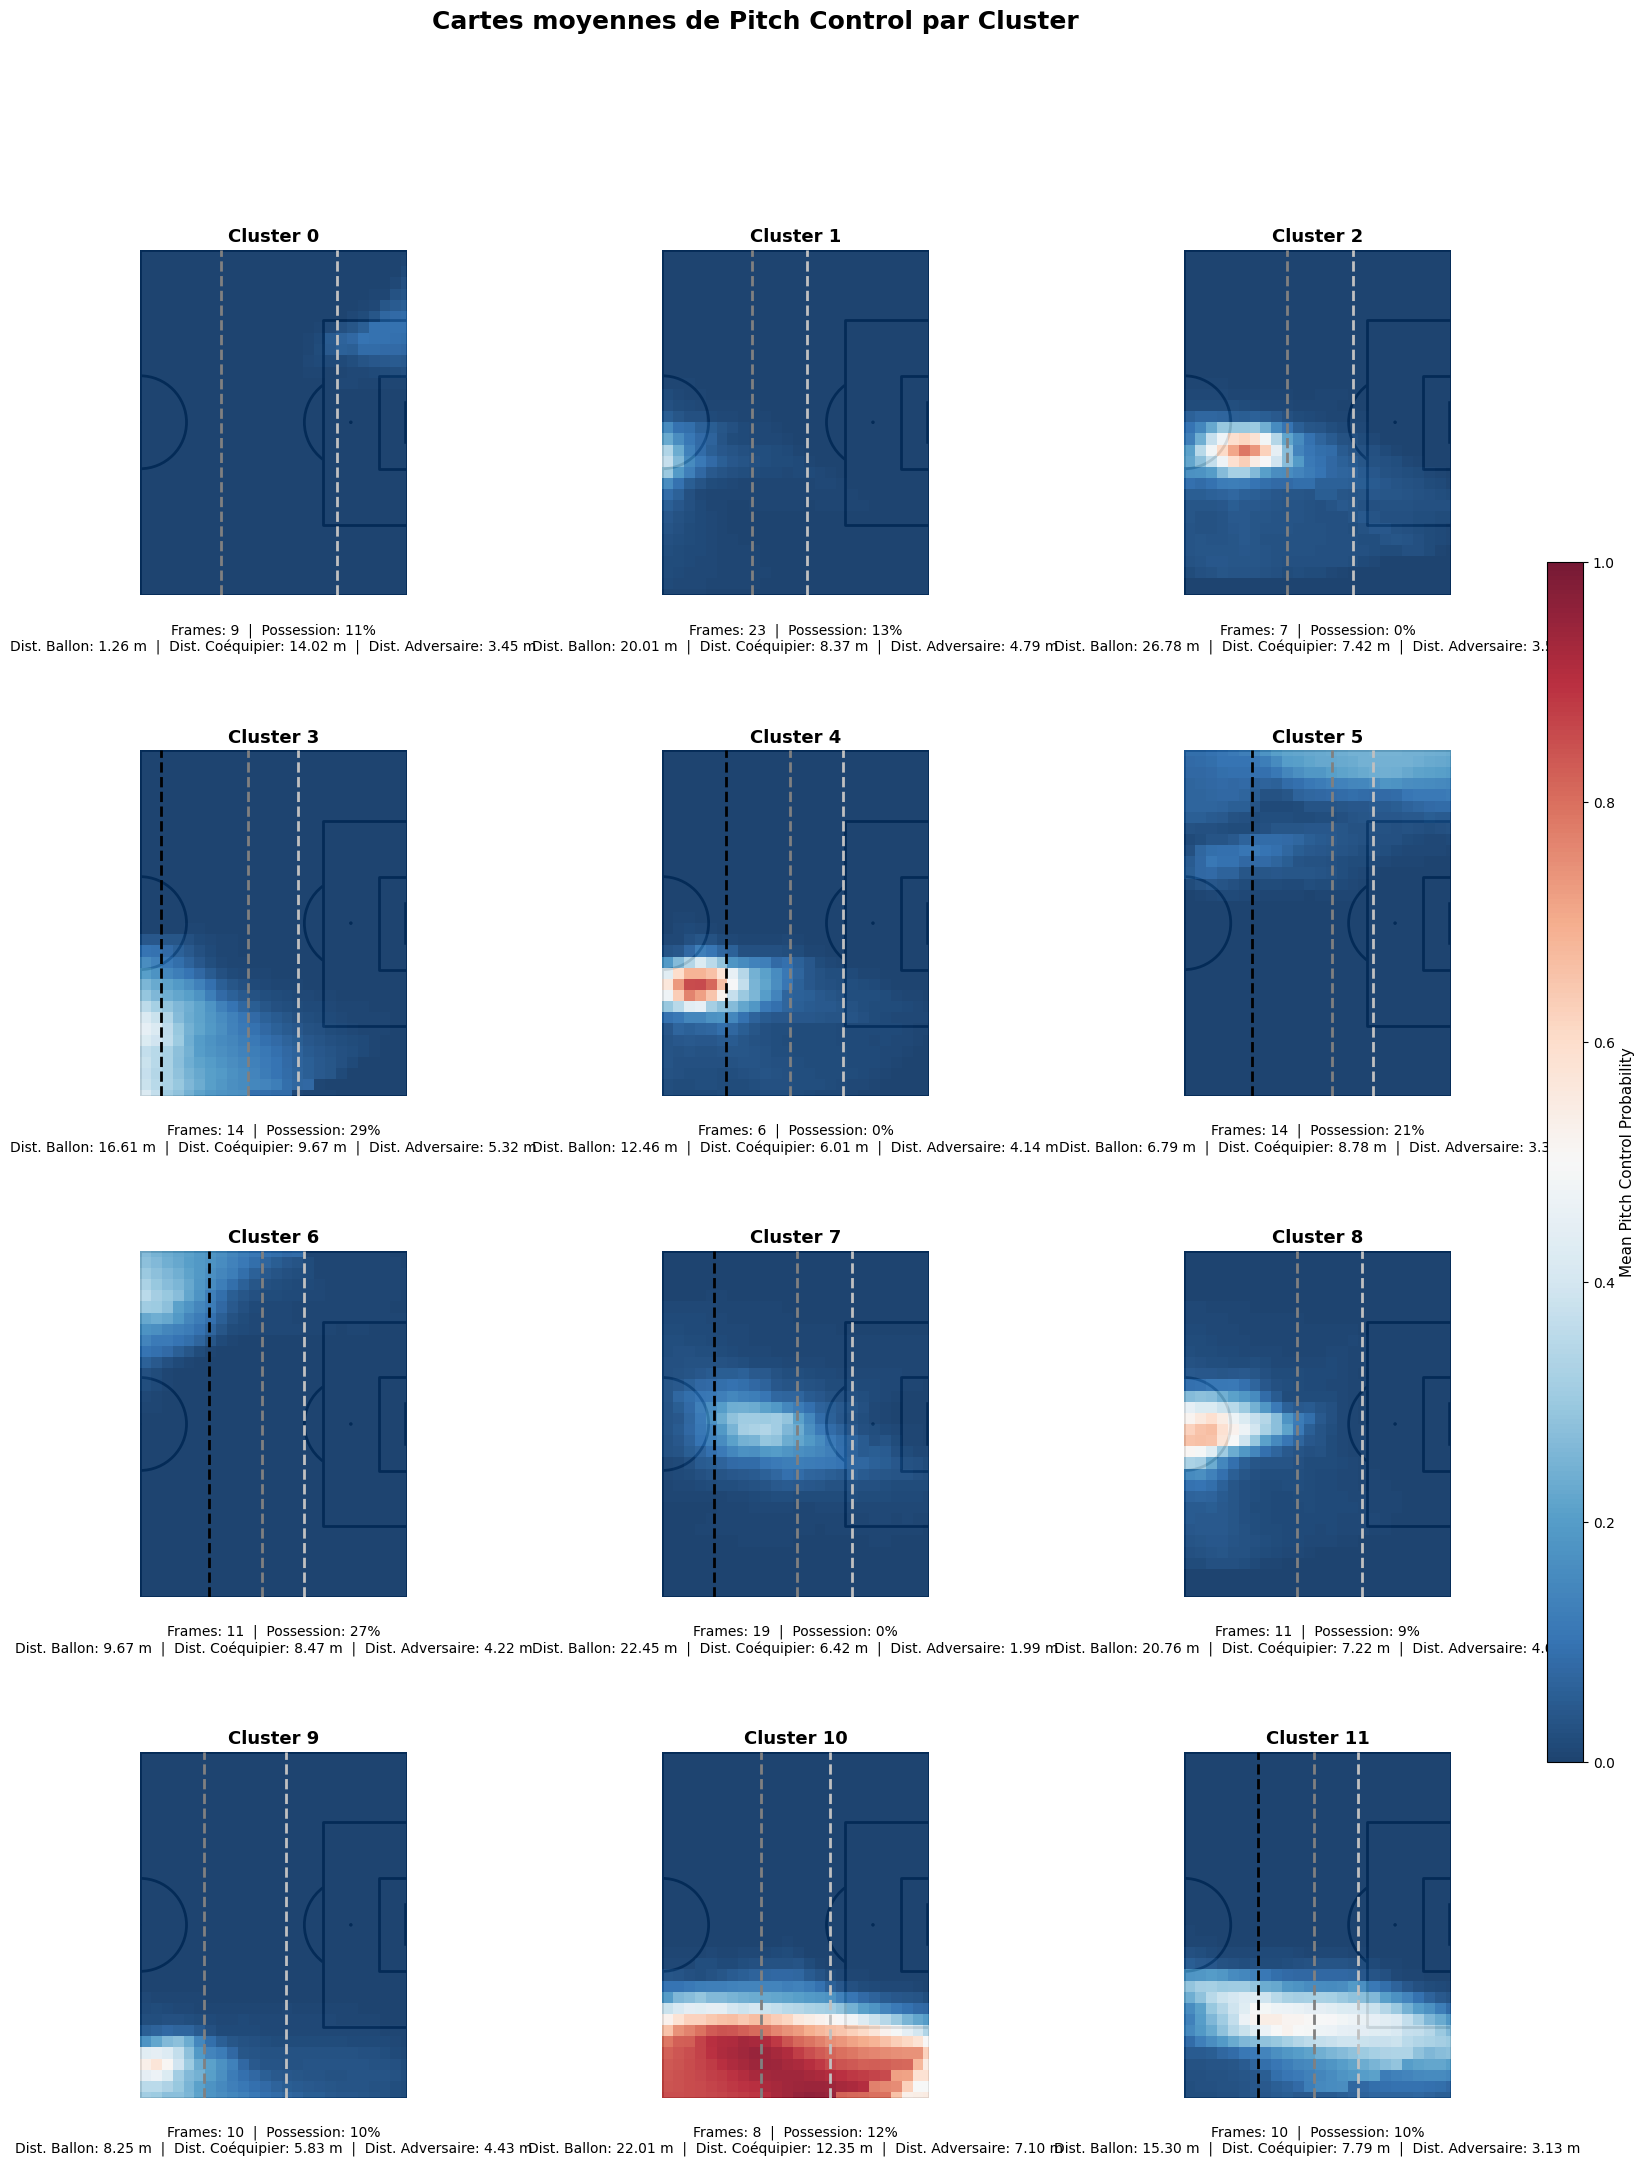

In [326]:
plot_cluster_summary_pitch_control_with_pitch(frames_inputs, meta, n_cols=3)

In [307]:
frames_cluster = meta[meta.cluster == 1].frame.to_list()
frames_cluster

[31690, 6275, 47079, 32089, 32235, 6282, 18000, 49303, 52237, 52149]

In [308]:
[frame for frame in frames_inputs if frame["frame"] in frames_cluster]

[{'pitch_control_map': array([[0.        , 0.        , 0.        , ..., 0.0217002 , 0.01916675,
          0.01896468],
         [0.        , 0.        , 0.        , ..., 0.01413397, 0.01313701,
          0.01209757],
         [0.        , 0.        , 0.        , ..., 0.00684584, 0.00656334,
          0.00609833],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ],
         [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ],
         [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ]]),
  'defensive_lines': [25.593749999999986,
   63.48209134615385,
   83.93336538461539],
  'frame': 31690,
  'player_id': 12166,
  'player_position': (85.14086538461538, 7.760000000000005),
  'ball_position': (93.40961538461539, 6.840000000000003),
  'in_possession': False,
  'distance_to_ball': 8.319773227829002,
  'distance_to_nearest_teammate': 5.6153614462114145,
  'dist

In [156]:
n_frames, H, W = pitch_control_maps.shape

X = pitch_control_maps.reshape(n_frames, -1)  # (n_frames, H*W)
#X_scaled = StandardScaler().fit_transform(X)  # important avant UMAP

In [157]:
X.shape

(100, 1600)

In [197]:
umap_model = umap.UMAP(
    n_neighbors=20,         # influence locale : à ajuster
    min_dist=0.1,           # compacité des clusters
    n_components=20,         # pour visualisation 2D
    random_state=42,
    metric='euclidean'      # ou 'cosine' selon tes essais
)
X_umap = umap_model.fit_transform(X)

In [198]:
X_umap.shape

(100, 20)

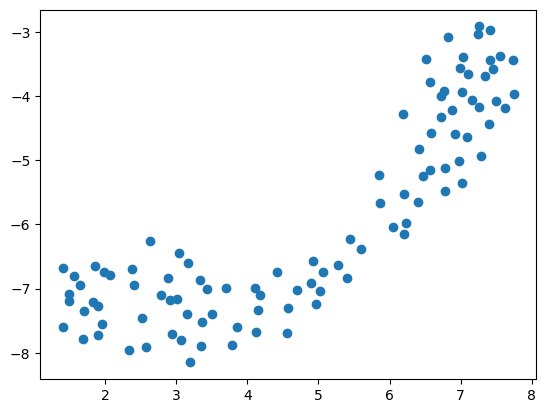

In [160]:
plt.scatter(X_umap[:,0], X_umap[:,1])

In [223]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=5,    # minimum de frames par cluster
    min_samples=5,         # robustesse aux outliers
    cluster_selection_epsilon=0.05
)
labels = clusterer.fit_predict(X_umap)

c:\Users\User\anaconda3\envs\twelve-ai\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\User\anaconda3\envs\twelve-ai\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


<Axes: ylabel='$\\lambda$ value'>

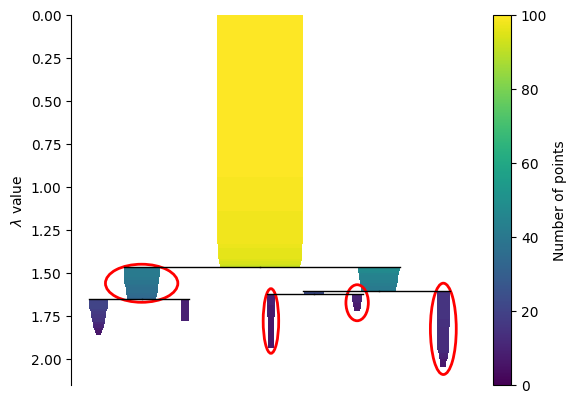

In [224]:
clusterer.condensed_tree_.plot(select_clusters=True)

In [225]:
labels

array([ 0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  1,  1,  1,  1,  1,  3,  1,
        1,  2,  2,  2, -1,  1,  1,  0,  2,  3,  3,  3, -1,  0,  0,  0,  0,
        0,  1,  1,  1,  1, -1,  1,  0,  0,  0,  0,  0,  0,  2, -1,  2,  2,
       -1,  3,  3,  3,  3, -1,  3,  3, -1,  3, -1,  3, -1, -1,  0,  0,  0,
        0,  0,  0,  0,  0, -1,  1, -1,  2,  2, -1, -1, -1,  0,  0,  0,  0,
        0,  0, -1, -1,  3,  0, -1,  0,  0,  0,  0,  0,  0, -1, -1],
      dtype=int64)

In [226]:
unique_labels = [l for l in np.unique(labels) if l != -1]  # -1 = bruit / sans cluster
print(f"Nombre de clusters trouvés : {len(unique_labels)} (et {sum(labels == -1)} outliers)")

Nombre de clusters trouvés : 4 (et 21 outliers)


In [227]:
unique_labels

[0, 1, 2, 3]

In [228]:
pitch_control_maps[labels == 3].shape

(13, 32, 50)

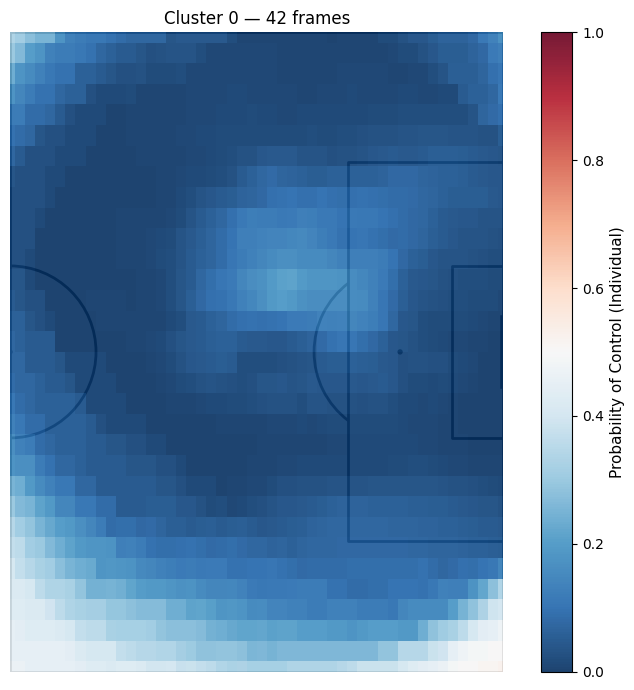

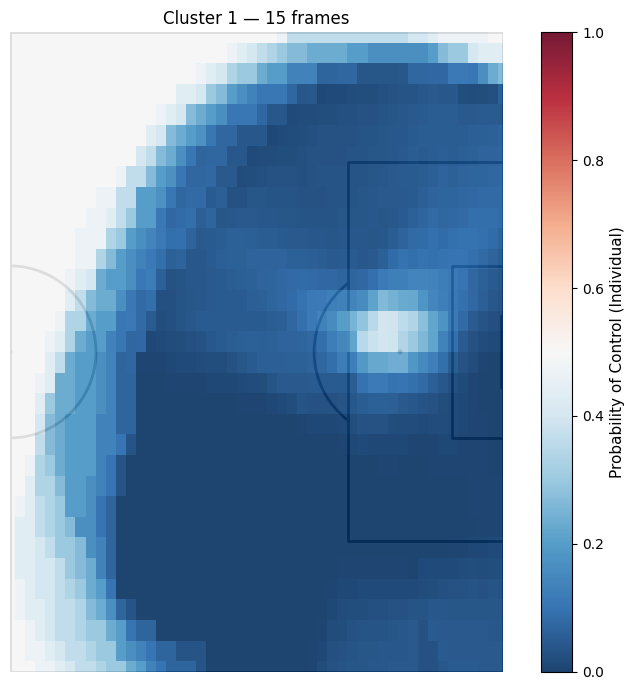

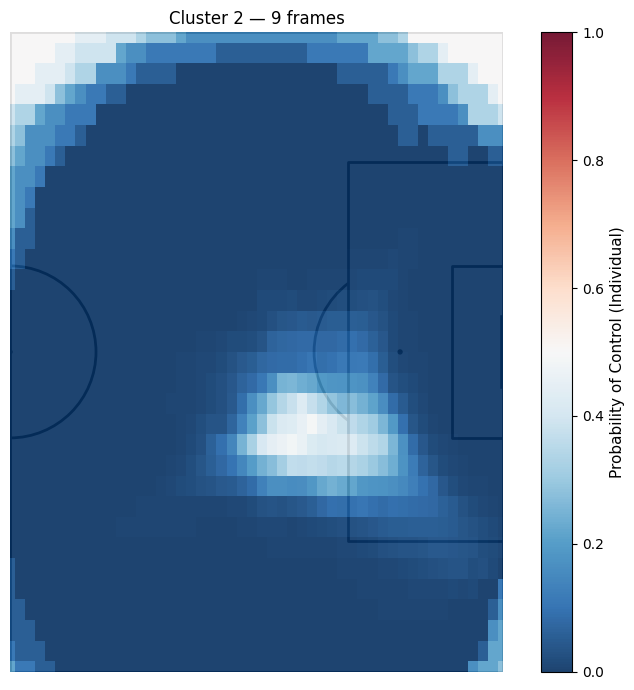

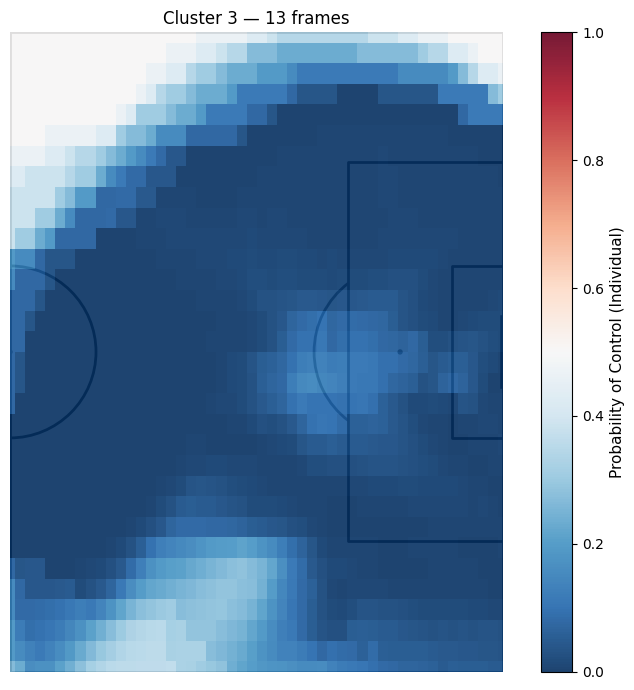

In [229]:
x_min, x_max = 105 / 2, 105

x = np.linspace(x_min, x_max, 50)
y = np.linspace(0, 68, 32)

pitch = Pitch(pitch_type='custom', pitch_length=105, pitch_width=68, pitch_color='white', line_color='black')

cmap = plt.cm.RdBu_r
cmap.set_bad(color="white")

for cl in unique_labels:

    cluster_maps = pitch_control_maps[labels == cl]
    mean_map = np.mean(cluster_maps, axis=0)
    #random_map = cluster_maps[np.random.randint(0, cluster_maps.shape[0])]

    bin_statistic = dict(statistic=mean_map, x_grid=x, y_grid=y)

    fig, ax = pitch.draw(figsize=(10, 7))
    pcm = pitch.heatmap(
        bin_statistic,
        ax=ax,
        cmap=cmap,
        vmin=0,
        vmax=1,
        alpha=0.9,
    )
    ax.set_xlim(105 / 2, 105)
    ax.set_ylim(0, 68)
    # ---- 6. Barre de couleur ----
    cbar = plt.colorbar(pcm, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Probability of Control (Individual)", fontsize=11)

    plt.title(f'Cluster {cl} — {len(cluster_maps)} frames')
    plt.show()